Импортируем необходимые пакеты. Если эта ячейка вылетает с ошибкой, нужно установить библиотеку командой:

`!pip install <имя_пакета>`

Например:

`!pip install fastdtw`

In [2]:
from collections import defaultdict
from pathlib import Path
import pickle
import random
from typing import Callable, List, Dict, Iterable
import warnings

from fastdtw import fastdtw
from matplotlib import rcParams
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

random.seed(42)
np.random.seed(42)
warnings.filterwarnings("ignore", category=FutureWarning)

rcParams["figure.figsize"] = (8, 9)  # Plots' size

In [3]:
patterns_codes_to_names = {
    16: "Промоин разрывных течений",
    20: "Устьевых баров",
    11: "Открытого моря и крупных морских заливов",
    13: "Забаровых лагун и вдольбереговых промоин",
    17: "Продельта",
    8: "Русловых отмелей равнинных меандрирующих рек",
    5: "Барьерных островов",
    10: "Дистальные турбидиты",
    15: "Пляжей"
}

In [4]:
patterns_names_to_codes = {name: code for code, name in patterns_codes_to_names.items()}
patterns_names_to_codes

{'Промоин разрывных течений': 16,
 'Устьевых баров': 20,
 'Открытого моря и крупных морских заливов': 11,
 'Забаровых лагун и вдольбереговых промоин': 13,
 'Продельта': 17,
 'Русловых отмелей равнинных меандрирующих рек': 8,
 'Барьерных островов': 5,
 'Дистальные турбидиты': 10,
 'Пляжей': 15}

In [5]:
def dict_to_pandas(curves_dict: Dict[str, List[np.array]], recode=True):
    """Convert dictionary with curves to our table format
    
    Parameters
    ----------
    curves: Dict[str, List[np.array]]
        Dictionary, where keys are names of the curves and values are lists of SP curves
    recode: bool = True
        If True, recode patterns names to codes. Else, leave them as is
    
    Returns
    -------
    df: pandas DataFrame of our format
    """
    cols = ['UWI', 'Top', 'Bottom', 'Thickness', 'ind_top', 'ind_bot',
            'sp', 'dept', 'gr', 'code', 'Asp', 'Agr', 'UWI_uniq']
    
    df = pd.DataFrame(columns=cols)
    
    names = []
    patterns = []

    for pattern_name, curves in curves_dict.items():
        patterns.extend(np.round(curve, 2) for curve in curves)
        
        if recode:
            # Перекодируем название паттерна в код
            names.extend(patterns_names_to_codes[pattern_name] for _ in curves)
        else:
            names.extend(pattern_name for _ in curves)
    
    df["sp"] = patterns
    df["code"] = names
    
    return df

In [6]:
def normalize(x):
    return 1 - (x - np.min(x)) / (np.max(x) - np.min(x))

Функции и классы для аугментаций. Можно не вчитываться, а просто выполнить ячейки

In [7]:
def normal_distribution_density(x, mean, sd):
    """Generate PDF of normal distribution with given parameters in the point `x`"""
    return np.exp(-(x - mean)**2 / (2 * sd**2)) / np.sqrt(np.pi * sd**2)

In [8]:
def get_soft_change(array: np.array, coef: float) -> np.array:
    """Smoothly increase/decrease `array` by `coef`
    
    array: np.array
        Time-series you want to change
    coef: float
        A number by which you want to multiply array. Changes will be equals to that number
        int the middle of `array` and slowly increasing/decreasing in the edges
        
    Returns
    -------
    Augmented `array`, which is smoothly multiplied by `coef`
    """
    difference = array * coef
    
    # Generate normal distribution for smooth change in amplitude
    mean = len(difference) / 2
    sd = len(difference) / 3
    normal_dist = np.array([normal_distribution_density(x, mean, sd) for x in range(len(difference))])
    
    # Make it from 0 to 1
    normal_dist = (normal_dist - np.min(normal_dist)) / (np.max(normal_dist) - np.min(normal_dist))
    
    # Renormalize normal dist to a height of difference
    if coef < 1:
        normal_dist *= (1 - coef) # Make it from 0 to (1 - coef)
        normal_dist = 1 - normal_dist  # Make it from 1 to coef
    else:
        normal_dist *= (coef - 1)  # Make it from 0 to (coef - 1)
        normal_dist = 1 + normal_dist  # Make it from 1 to coef
        
    array *= normal_dist
        
    return array

In [9]:
def drop_random_points(x: np.array, keep_probability=0.5) -> np.array:
    """Drop random points from array `x`"""
    keep_probabilities = np.random.random(size=len(x))
    return x[keep_probabilities < keep_probability]


def insert_points(x: np.array, insertion_probability=0.5) -> np.array:
    """Insert new points to array `x`

    Insertion probability after each point in `x` can be set with `insertion_probability`.
    Values of new points are interpolated from the closest points."""

    new_array = []

    for i in range(len(x)):
        new_array.append(x[i])

        if np.random.random() <= insertion_probability and i < len(x) - 1:
            new_array.append((x[i] + x[i + 1]) / 2)

    return np.array(new_array)


def stretch_function(x: np.array, stretching_coef: float):
    """Stretch `x` so that it's size will be `len(x)*stretching_coef`"""

    scope = np.arange(len(x))
    f = interp1d(scope, x)

    stretch_times = int(stretching_coef)
    new_points = np.linspace(0, scope[-1], len(scope) * stretch_times)
    interpolated_array = f(new_points)

    insertion_probability = stretching_coef % 1
    array_with_extra_points = insert_points(interpolated_array, insertion_probability)

    return array_with_extra_points


def remove_region(x: np.array, region_start: int, region_end: int) -> np.array:
    """Remove region from `region_start` to `region_end` from `x`"""
    new_array = x[:region_start].tolist()
    new_array.extend(x[region_end:].tolist())

    return np.array(new_array)


def remove_random_region(x: np.array, region_size: int) -> np.array:
    """Remove random region of length `region_size` from `x`"""

    dropping_start = int(np.random.uniform(0, len(x) - region_size))

    return remove_region(
        x, region_start=dropping_start, region_end=dropping_start + region_size
    )


def remove_random_regions(x: np.array, fraction: float, n_regions: int) -> np.array:
    """Remove random region from `x` `n_regions` times"""

    new_array = remove_random_region(x, region_size=int(len(x) * fraction))

    for _ in range(n_regions - 1):
        new_array = remove_random_region(
            new_array, region_size=int(len(new_array) * fraction)
        )

    return new_array


def squeeze_function(
    x: np.array,
    coef: float = 0.8,
    from_: int = 0,
    to: int = None,
    normalize: bool = True,
    smooth: bool = False
):
    """Multiply each point of `x` by `coef` between `from` and `to` indexes"""
    if to is None:
        to = len(x)

    new_array = x.copy()
    if smooth:
        new_array[from_: to] = get_soft_change(new_array[from_: to], coef)
    else:
        new_array[from_: to] *= coef

    if normalize:
        new_array = np.min([new_array, np.ones(len(new_array))], axis=0)

    return new_array


def squeeze_random_regions(x: np.array, fraction: float, n_regions: int, coef: float = .8, normalize: bool = True):
    """Multiply `n_regions` random parts of `x` with the size (len(x) * fraction) by `coef`"""
    new_array = x.copy()

    for _ in range(n_regions):
        start = np.random.randint(len(new_array) * (1 -  fraction))
        end = max(1, int(start + len(new_array) * fraction))
        new_array = squeeze_function(
            new_array,
            coef=coef,
            from_=start,
            to=end,
            normalize=normalize,
            smooth=True
        )

    return new_array


class AugmentationParameter:
    """Class for creating parameter, which value should be randomly generated

    Examples
    --------
    >>> some_parameter = AugmentationParameter(
    >>>     name='score', generating_function=np.random.randint generating_parameters={"low": 3, "high": 10},
    >>> )
    >>> some_parameter.generate()
    {'score': 4}
    >>> some_parameter.generate()
    {'score': 8}
    >>> for _ in range(3):
    >>>     augmentation = SomeAugmentation(**some_parameter.generate())  # Each augmentation will be different
    """

    def __init__(
        self, name: str, generating_function: Callable, generating_parameters: dict
    ):
        """Set `name` of the parameter and function, which will generate it's value

        Parameters
        ----------
        name: str
            Name of the parameter
        generating_function: Callable
            Function, which is used to generate parameter's value
        generating_parameters: dict
            Required parameters of `generating_function`
        """
        self.name = name
        self.generating_function = generating_function
        self.generating_parameters = generating_parameters

    def generate(self):
        """Return dictionary with name of the parameter as a key and random value as a dictionary value"""
        return {self.name: self.generating_function(**self.generating_parameters)}


class Augmentation:
    """Class that helps to create augmentation with specific function, and apply it with different parameters

    Examples
    --------
    >>> removing_regions_augmentation = Augmentation(
    >>>     fun=remove_random_regions,
    >>>     fun_parameters=[
    >>>         AugmentationParameter(
    >>>             name="fraction",
    >>>             generating_function=np.random.randint,
    >>>             generating_parameters={"low": 0.05, "high": 0.15},
    >>>         ),
    >>>         AugmentationParameter(
    >>>             name="n_regions",
    >>>             generating_function=np.random.randint,
    >>>             generating_parameters={"low": 1, "high": 3},
    >>>         ),
    >>>     ]
    >>> )
    >>> x = np.arange(15)
    >>> x
    array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])
    >>> removing_regions_augmentation.generate(x)
    [ 0  1  2  3  4  5 13 14]
    """

    def __init__(self, fun, fun_parameters: List[AugmentationParameter]):
        self.fun = fun
        self.fun_parameters = fun_parameters

    def generate(self, array):
        """Generate augmented array"""
        current_parameters = {}
        for p in self.fun_parameters:
            current_parameters.update(p.generate())

        return self.fun(array, **current_parameters)

Несколько полезных функций, чтобы сократить количество кода

In [10]:
def plot_well_log(depth: np.array, sp: np.array, title: str = "", ax=None, label="", color=None):
    if ax is None:
        ax = plt.subplot()
    ax.plot(sp, depth, label=label, c=color)
    ax.set_xlim(1.1, 0)
    ax.invert_yaxis()
    ax.set_title(title)
    return ax

In [11]:
def align_arrays_with_DTW(array_1, array_2):
    """Make `array_1` and `array_2` the same size, using DTW best matching"""
    
    distance, path = fastdtw(array_1, array_2)
    
    fitted_array_1 = []
    fitted_array_2 = []

    for array_1_idx, array_2_idx in path:
        fitted_array_1.append(array_1[array_1_idx].item())
        fitted_array_2.append(array_2[array_2_idx].item())

    fitted_array_1 = np.array(fitted_array_1)
    fitted_array_2 = np.array(fitted_array_2)
    
    return fitted_array_1, fitted_array_2


def calculate_normalizing_coef(array_1, array_2, correlation_strategy="standard_scaling") -> float:
    array_1_self_corr = np.correlate(array_1, array_1)
    array_2_self_corr = np.correlate(array_2, array_2)
    
    if correlation_strategy == "scaling":
        normalizing_coef = 1 / np.sqrt(array_1_self_corr * array_2_self_corr)
        
    elif correlation_strategy in ("robust_scaling", "standard_scaling", "no_scaling"):
        normalizing_coef = 1 / max(array_1_self_corr, array_2_self_corr)
        
    else:
        raise ValueError(f"Unknown correlation strategy: {correlation_strategy}")
        
    return normalizing_coef


def dtw_correlation_metric(pattern, target, correlation_strategy="standard_scaling") -> float:   
    try:
        fitted_pattern, fitted_target = align_arrays_with_DTW(pattern, target)
    except (KeyError, IndexError):  # It happens if DTW can't be calculated
        return 0

    normalizing_coef = calculate_normalizing_coef(
        fitted_pattern, fitted_target, correlation_strategy=correlation_strategy
    )
    similarity = (np.correlate(fitted_pattern, fitted_target) * normalizing_coef).item()

    return similarity

In [12]:
def check_augmented_curves(
    pattern, 
    augmented_curves,
    similarity_threshold: float = 0.9,
    correlation_strategy="standard_scaling",
    plot_similarities=False
) -> List[np.array]:
    """Checks how similar `augmented_curves` are to the `pattern`
    
    Parameters
    ----------
    pattern: np.array
        Baseline time series
    augmented_curves: Iterable[np.array]
        List (or other iterable) with augmented curves generated from `pattern`
    similarity_threshold: float
        How similar `augmented_curves` should be to the `pattern`
    plot_similarities: bool = False
        If true, plot the distribution of the similarities of `augmented_curves` to the `pattern`
    
    Returns
    -------
    similar_curves: list of `augmented_curves` with similarity to the `pattern` >= `similarity_threshold`
    """
    similar_curves = []
    similarities = []
    
    for augmented_curve in augmented_curves:
        similarity = dtw_correlation_metric(pattern, augmented_curve)
        similarities.append(similarity)
        
        if similarity > similarity_threshold:
            similar_curves.append(augmented_curve)
    
    if plot_similarities and similarities:
        sns.distplot(similarities)
        plt.title("Похожесть исходной и аугментированной кривых", fontdict={"size": 20})
        plt.xlabel("Похожесть", fontdict={"size": 14})
        plt.ylabel("Количество кривых", fontdict={"size": 14})
    
    return similar_curves

In [13]:
def generate_augmented_curves(
    pattern: np.array,
    augmentations: List[Augmentation],
    n_curves: int = 2000,
    n_augmentations: int = 1,
    length_threshold: int = 0
) -> List[np.array]:
    """Create `n_curves` augmented curves from `pattern`"""
    augmented_curves = []

    for i in range(n_curves):
        augmented_curve = pattern.copy()
        
        # Apply random augmentation n_augmentations times
        for _ in range(n_augmentations):
            augmentation = random.choice(augmentations)
            
            if len(augmented_curve) >= length_threshold:
                augmented_curve = augmentation.generate(augmented_curve)
        
        if len(augmented_curve) >= length_threshold:
            augmented_curves.append(augmented_curve)
            
    return augmented_curves

In [53]:
def moving_average(x: np.array, window_size: int) -> np.array:
    """Calculate moving average for the array `x` with the window size `w`"""
    return np.convolve(x, np.ones(window_size), "same") / window_size

In [50]:
def add_connections_between_regions(curve, codes):
    not_coded = (codes == -1).astype(int)

    start_idx, end_idx = 0, 0
    start, end = 0, 0

    for idx, code in enumerate(not_coded[: -1] - not_coded[1: ]):
        if code == -1:  # end of the facies
            end_idx = idx
            end = curve[idx]

        elif code == 1:  # start of the new facies
            start_idx = idx
            start = curve[idx]

            not_coded_length = start_idx - end_idx
            region_in_between = [end + (start-end)/(start_idx - end_idx) * i for i in range(not_coded_length)]

            region_with_noise = np.array(region_in_between) + np.random.normal(0, .02, size=len(region_in_between))
            region_with_noise = np.max([region_with_noise, np.zeros(len(region_with_noise))], axis=0)
            region_with_noise = np.min([region_with_noise, np.ones(len(region_with_noise))], axis=0)
            region_with_noise = moving_average(region_with_noise, window_size=3)

            curve[end_idx: start_idx] = region_with_noise
            
    return curve

In [38]:
def curves_sequence(
    curves: Iterable[np.array], codes: Iterable[int], n_curves_to_stack: int, n_points_in_between: int = 0
) -> List[np.array]:
    """Stack several curves together
    
    Parameters
    ----------
    curves: Iterable[numpy.array]
        Iterable collection of numpy arrays with curves. E. g. list of numpy arrays with numbers
    codes: Iterable[int]
        Collection of codes (1 code for each curve)
    n_curves_to_stack: int
        How many curves you want to stack together. They will be chosen randomly from `curves`
    n_points_in_between: int
        How many points you want to insert between each pair of facies
        
    Returns
    -------
    new_curve, new_codes
        A tuple containing 2 numpy arrays. The first one contains a new curve with several `curves`
        stacked together. The second element of the tuple contains codes for each point of the `new_curve`
    """
    idxs = np.arange(len(curves))

    chosen_idxs = np.random.choice(idxs, n_curves_to_stack)
    np.random.shuffle(chosen_idxs)  # To make sure that the order is different
    
    chosen_curves = curves[chosen_idxs]
    chosen_codes = codes[chosen_idxs]
    
    new_curve_length = sum(len(curve) for curve in chosen_curves) + n_points_in_between * (len(chosen_curves) - 1)
    
    new_curve = np.zeros(new_curve_length)
    new_codes = np.zeros(new_curve_length)
    
    i = 0  # Index of the start of the current curve

    for curve, code in zip(chosen_curves, chosen_codes):
        new_curve[i: i + len(curve)] = curve
        new_codes[i: i + len(curve)] = code
        
        new_curve[i + len(curve): i + len(curve) + n_points_in_between]
        new_codes[i + len(curve): i + len(curve) + n_points_in_between] = -1
        
        i += len(curve) + n_points_in_between
        
    new_curve = add_connections_between_regions(new_curve, new_codes)
        
    return new_curve, new_codes


def plot_curves_stack(curve: np.array, codes: Iterable[int], ax=None, title=""):
    """Plot a stacked curve
    
    Parameters
    ----------
    curve: numpy.array with numbers (e. g. from function `curves_sequence()`)
    codes: numpy.array[int]
        Each element of the array contains a code for corresponding point in `curve`
        
    Returns
    -------
    ax: a matplotlib Axis with plot
    """
    if ax is None:
        ax = plt.subplot()

    plot_well_log(depth=np.arange(len(curve)), sp=curve, ax=ax)

    for code in np.unique(codes):
        curve_with_code = curve.copy()
        x = np.arange(len(curve_with_code), dtype=float)

        curve_with_code[codes != code] = np.nan
        x[codes != code] = np.nan

        plot_well_log(depth=x, sp=curve_with_code, label=code, ax=ax)

    ax.legend(loc="upper left")
    ax.set_title(title)
    
    return ax

Зададим список аугментаций, которые будут использоваться для генерации новых кривых

In [15]:
augmentations = [
    Augmentation(
        fun=drop_random_points,
        fun_parameters=[
            AugmentationParameter(
                name="keep_probability",
                generating_function=np.random.uniform,
                generating_parameters={"low": 0.25, "high": 0.8},
            ),
        ]
    ),
    
    Augmentation(
        fun=remove_random_regions, 
        fun_parameters=[
            AugmentationParameter(
                name="fraction",
                generating_function=np.random.uniform,
                generating_parameters={"low": 0.1, "high": 0.2}
            ),
            AugmentationParameter(
                name="n_regions",
                generating_function=np.random.randint,
                generating_parameters={"low": 2, "high": 4}
            ),
        ]
    ),
    
    Augmentation(
        fun=stretch_function, 
        fun_parameters=[
            AugmentationParameter(
                name="stretching_coef",
                generating_function=np.random.uniform,
                generating_parameters={"low": 1.2, "high": 2}
            ),
        ]
    ),
    
    Augmentation(
        fun=squeeze_function,
        fun_parameters=[
            AugmentationParameter(
                name="coef",
                generating_function=np.random.uniform,
                generating_parameters={"low": .8, "high": 1.2}
            )
        ]
    ),
    
    Augmentation(
        fun=squeeze_random_regions,
        fun_parameters=[
            AugmentationParameter(
                name="fraction",
                generating_function=np.random.uniform,
                generating_parameters={"low": 0.1, "high": 0.2}
            ),
            AugmentationParameter(
                name="n_regions",
                generating_function=np.random.randint,
                generating_parameters={"low": 1, "high": 5},
            ),
            AugmentationParameter(
                name="coef",
                generating_function=np.random.uniform,
                generating_parameters={"low": .7, "high": 1.2}
            )
        ]
    )
]

In [16]:
short_curves_augmentations = [    
    Augmentation(
        fun=stretch_function, 
        fun_parameters=[
            AugmentationParameter(
                name="stretching_coef",
                generating_function=np.random.uniform,
                generating_parameters={"low": 1.2, "high": 2}
            ),
        ]
    ),
    
    Augmentation(
        fun=squeeze_function,
        fun_parameters=[
            AugmentationParameter(
                name="coef",
                generating_function=np.random.uniform,
                generating_parameters={"low": .8, "high": 1.2}
            )
        ]
    ),
    
    Augmentation(
        fun=squeeze_random_regions,
        fun_parameters=[
            AugmentationParameter(
                name="fraction",
                generating_function=np.random.uniform,
                generating_parameters={"low": 0.1, "high": 0.2}
            ),
            AugmentationParameter(
                name="n_regions",
                generating_function=np.random.randint,
                generating_parameters={"low": 1, "high": 5},
            ),
            AugmentationParameter(
                name="coef",
                generating_function=np.random.uniform,
                generating_parameters={"low": .7, "high": 1.2}
            )
        ]
    )
]

## Прочитаем файл с кривыми Муромцева

Нужно указать путь к файлу в следующей ячейке:

In [29]:
muroms_path = Path("data/Muromtsev&Shell_Logs.xlsx")

In [30]:
sheets = [f"sheet{i}" for i in range (1, 5)]

facies = []    
    
for i, sheet in enumerate(sheets):
    df = pd.read_excel(muroms_path, sheet_name=sheet, engine="openpyxl")
    
    cols = []
    
    for column in df.columns:
        if 'ID' in column:
            cols.append(column)
    
    for column in cols:
        for k in range(df.shape[1]):      
            if df.columns[k] == column:                
                facies.append(df.iloc[:,k-4:k+1].dropna())

## Выбор кривой для аугментирования
Нужно задать индекс кривой в массиве `facies`. Вот индексы кривых для удобства:

In [31]:
print("Индекс", "Кривая Муромцева", sep="\t")
for idx, curve in enumerate(facies):
    pattern_name = curve.iloc[0, 3]
    print(f"{idx}\t{pattern_name}")

Индекс	Кривая Муромцева
0	Головных частей разрывных течений
1	Барьерных островов
2	Устьевых баров
3	Вдольбереговых баров (регрессивных) и прибрежных валов
4	Забаровых лагун и вдольбереговых промоин
5	Открытого моря и крупных морских заливов
6	Промоин разрывных течений
7	Пляжей
8	Вдольбереговых баров (трансгрессивных) и прибрежных валов
9	Гребней штормовых волн и приливных течений
10	Русловых отмелей спрямленных рек
11	Русловых отмелей фуркирующих рек (горного типа) и временных потоков
12	Русловых отмелей равнинных меандрирующих рек
13	Пески разливов
14	Пойменных озер и болот
15	Береговых валов
16	Временно заливаемых участков пойм
17	Приморских болот (маршей, лайд и др.)
18	Каньоны и каналы стока (питающие)
19	Проксимальные турбидиты и зерновые потоки
20	Средние (переходные) турбидиты
21	Дистальные турбидиты
22	Дно бассейна
23	Фации склона
24	Околоканальный вал
25	Верхний веер склона
26	Оползни
27	Дельтовый канал
28	Проксимальная часть дельты
29	Средняя часть дельты
30	Дистальная часть 

Например, возьмём кривую "Открытого моря и крупных морских заливов"

In [32]:
facies_idx = 3

## Генерация аугментированных кривых

Зададим количество аугменированных кривых, которые мы хотим получить:

In [33]:
N_AUGMENTATIONS = 2000

C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


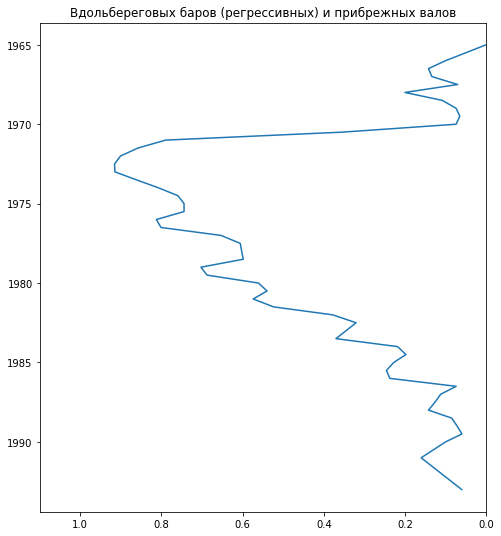

In [35]:
pattern = facies[facies_idx].iloc[:, 0].to_numpy()
depth = facies[facies_idx].iloc[:, 1].to_numpy()
pattern_name = facies[facies_idx].iloc[0, 3]

augmented_curves = [pattern] + generate_augmented_curves(
    pattern, augmentations, n_augmentations=3, n_curves=N_AUGMENTATIONS, length_threshold=10
)

plot_well_log(depth, pattern, title=pattern_name);

Посмотрим на несколько аугментированных кривых:

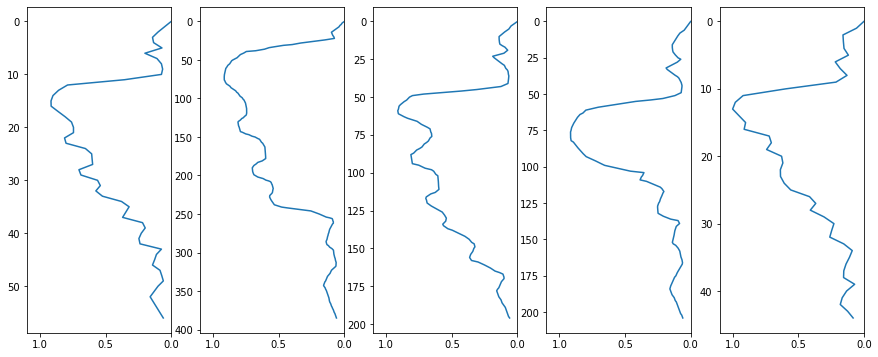

In [36]:
n_cols = 5

fig, axes = plt.subplots(1, n_cols, figsize=(n_cols*3, 6))

for i, curve in enumerate(augmented_curves[ : n_cols]):
    plot_well_log(depth=np.arange(curve.shape[0]), sp=curve, ax=axes[i])

In [37]:
plt.figure(figsize=(8, 5))
similar_curves = check_augmented_curves(pattern, augmented_curves)

<Figure size 576x360 with 0 Axes>

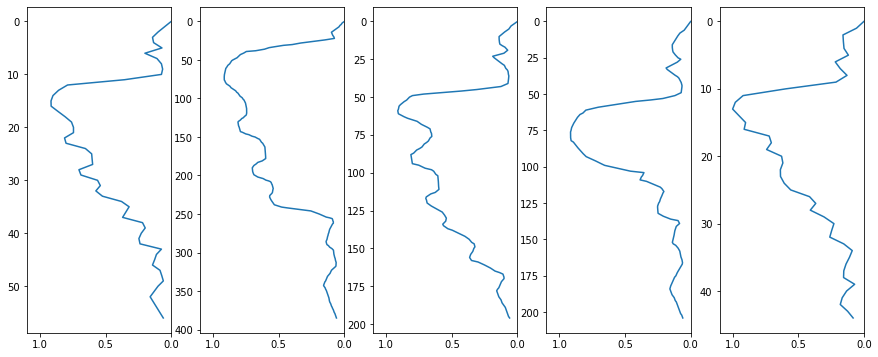

In [38]:
n_cols = 5

fig, axes = plt.subplots(1, n_cols, figsize=(n_cols*3, 6))

for i, curve in enumerate(similar_curves[ : n_cols]):
    plot_well_log(depth=np.arange(curve.shape[0]), sp=curve, ax=axes[i])

Теперь можем сохранить аугментированные кривые. Для этого удобно использовать JSON или pickle. Воспользуемся вторым вариантом

Сгенерируем остальные аугментированные паттерны:

  0%|          | 0/33 [00:00<?, ?it/s]

Головных частей разрывных течений


C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


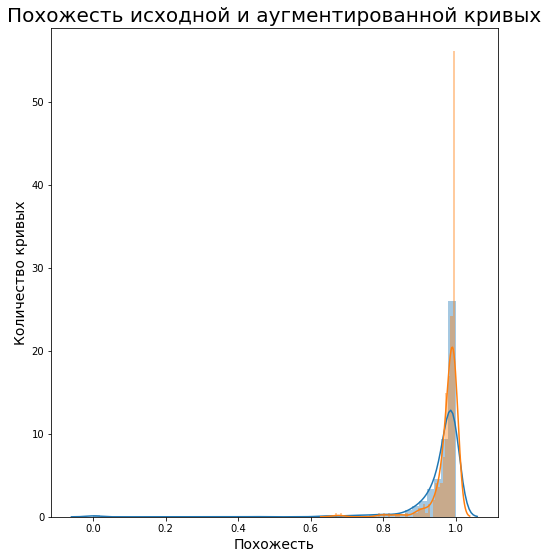

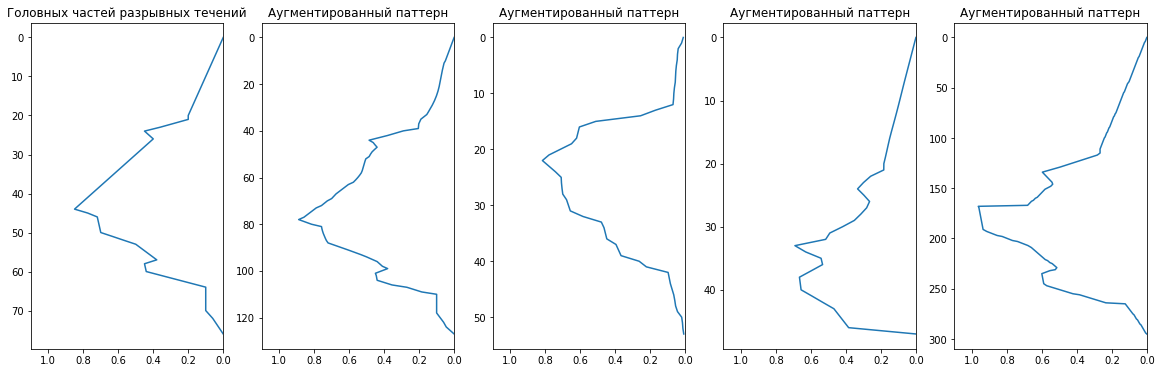

--------------------
Барьерных островов


C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


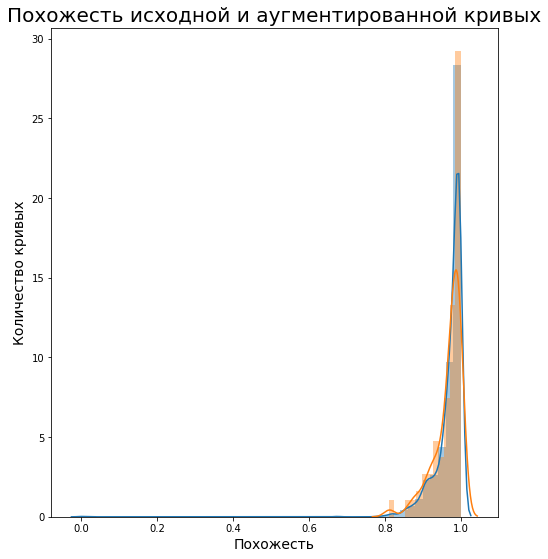

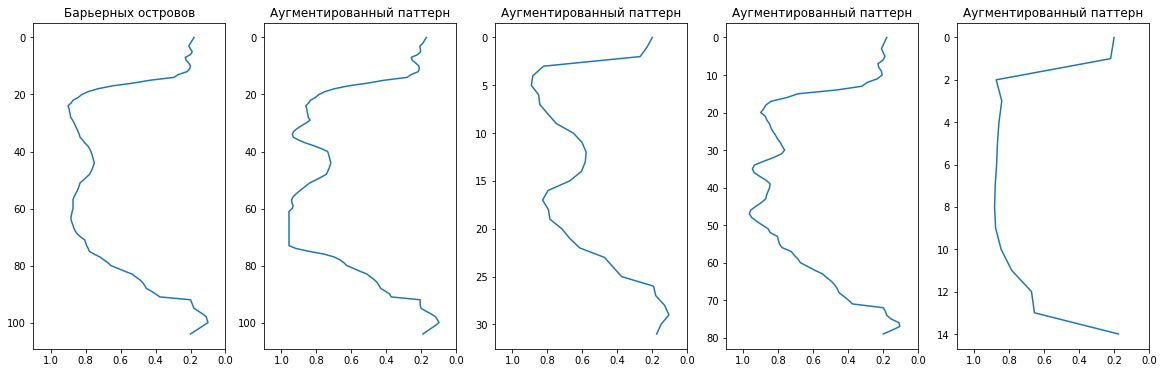

--------------------
Устьевых баров


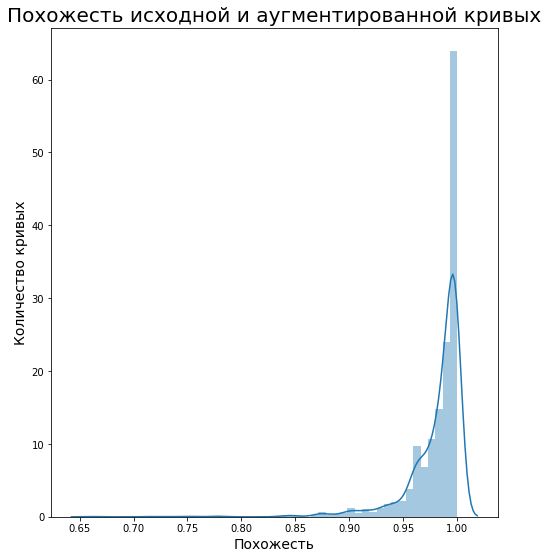

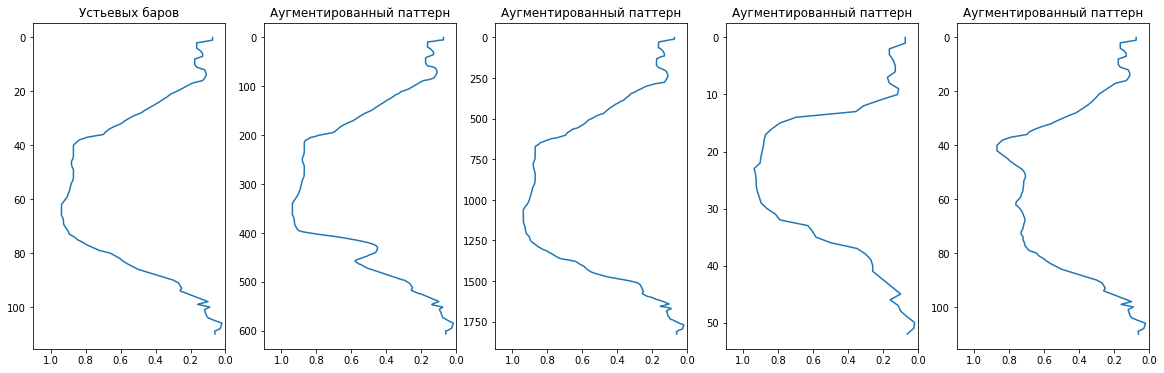

--------------------
Вдольбереговых баров (регрессивных) и прибрежных валов


C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


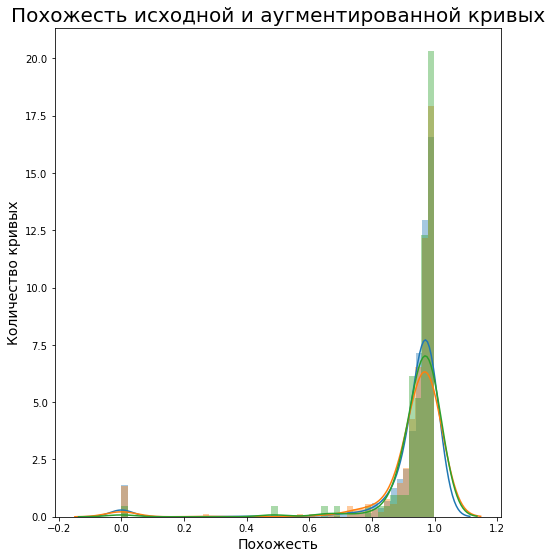

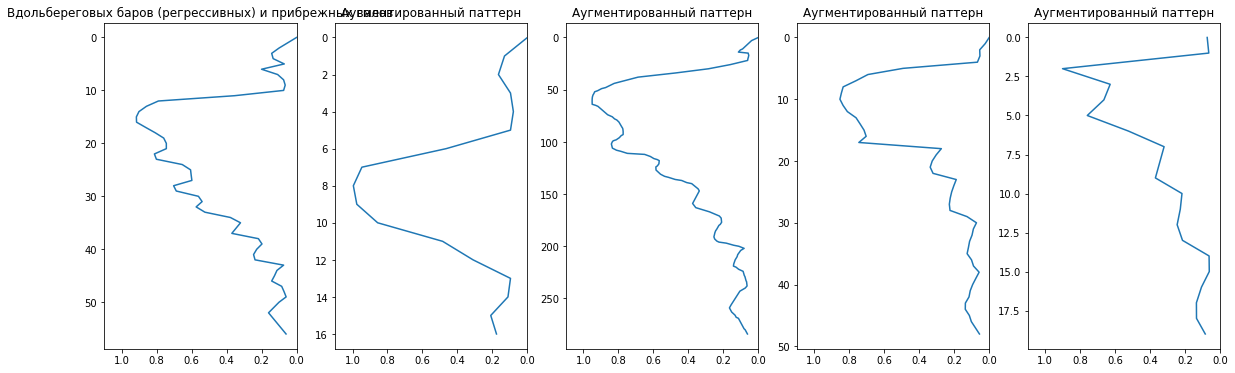

--------------------
Забаровых лагун и вдольбереговых промоин


C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


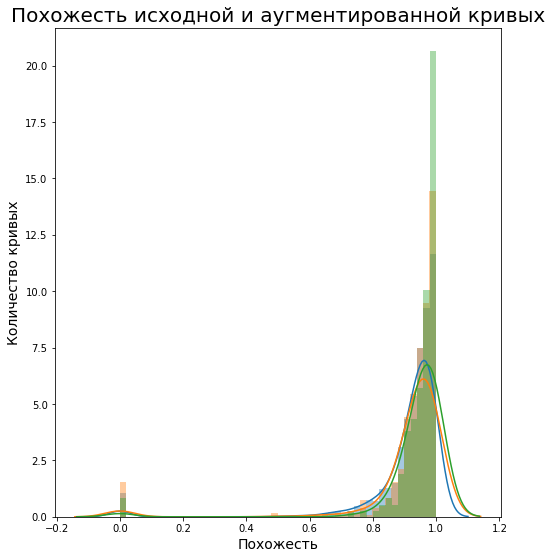

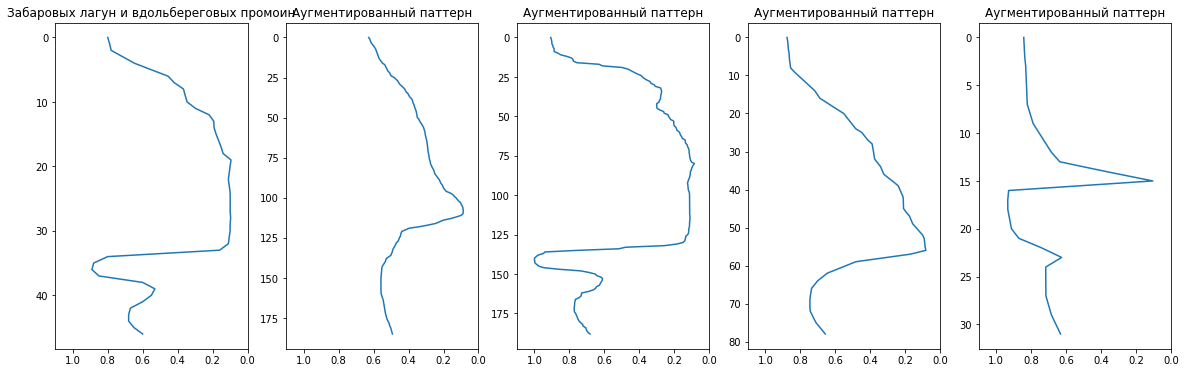

--------------------
Открытого моря и крупных морских заливов


C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


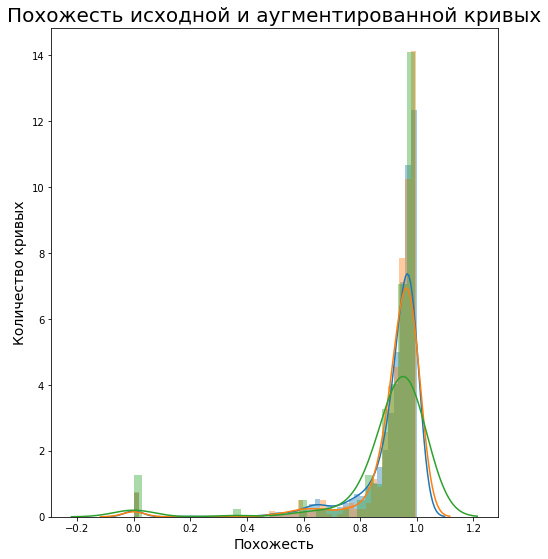

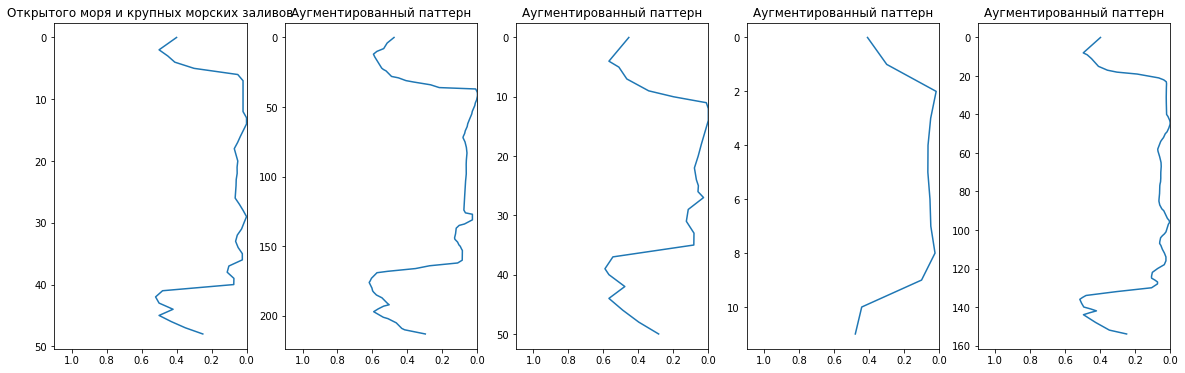

--------------------
Промоин разрывных течений


C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


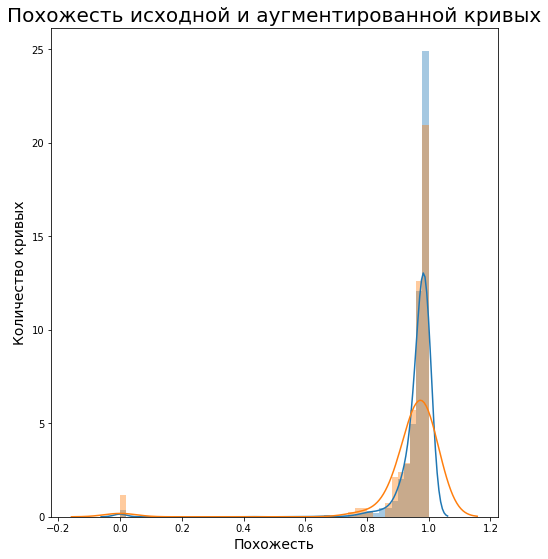

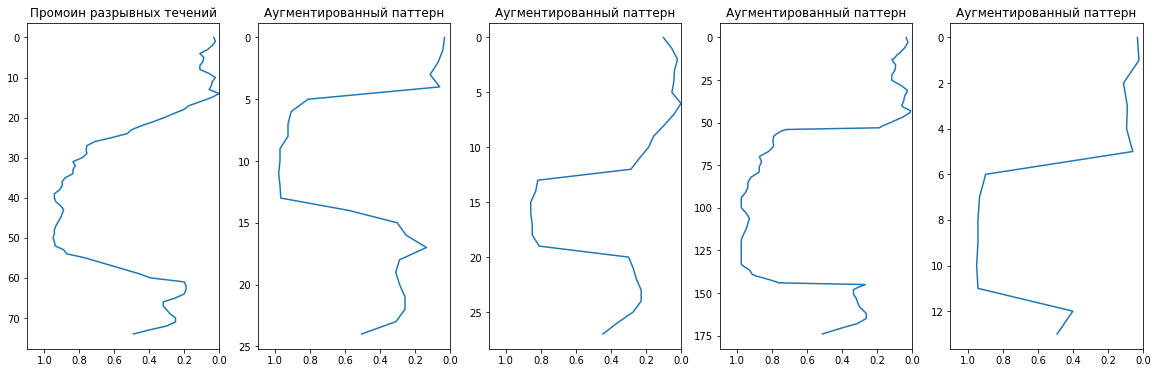

--------------------
Пляжей


C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


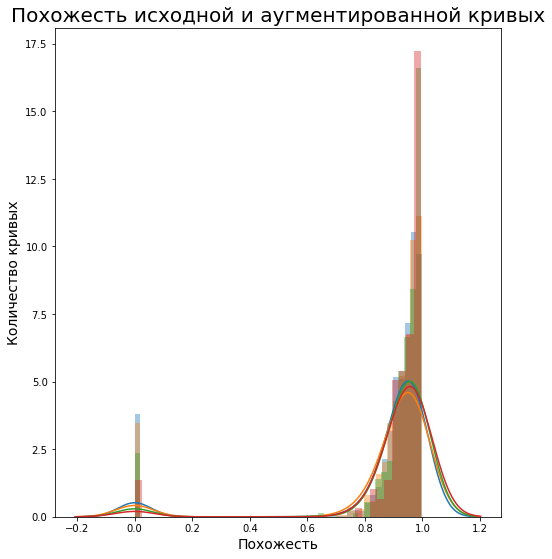

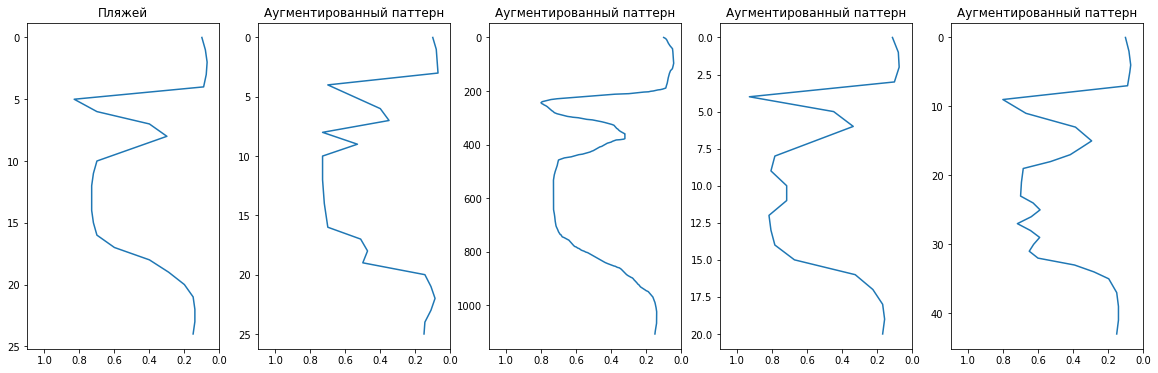

--------------------
Вдольбереговых баров (трансгрессивных) и прибрежных валов


C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


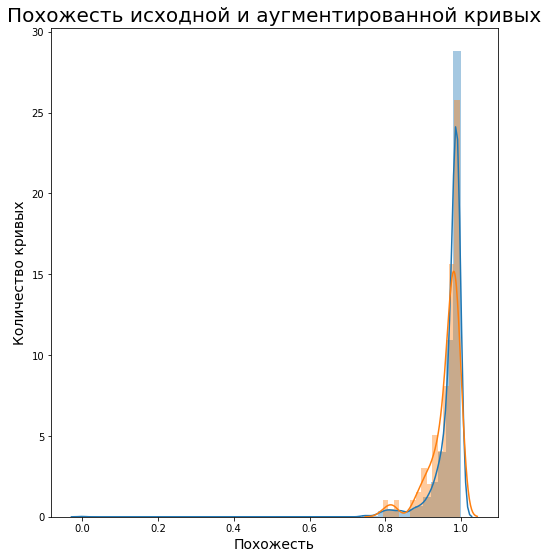

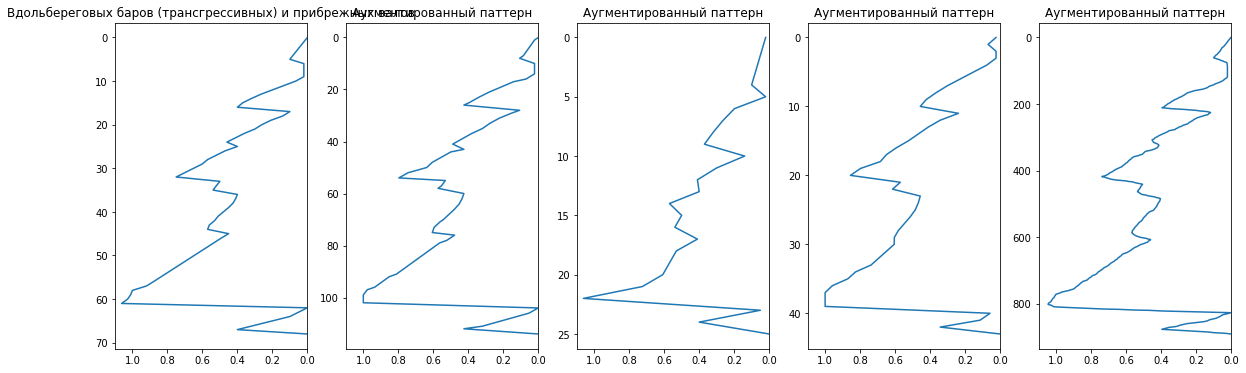

--------------------
Гребней штормовых волн и приливных течений


C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


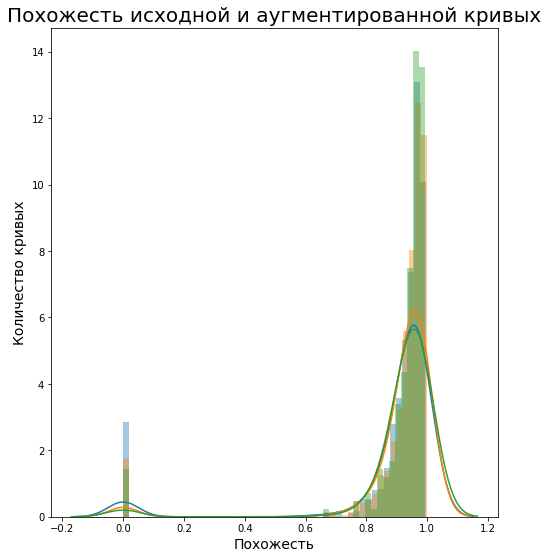

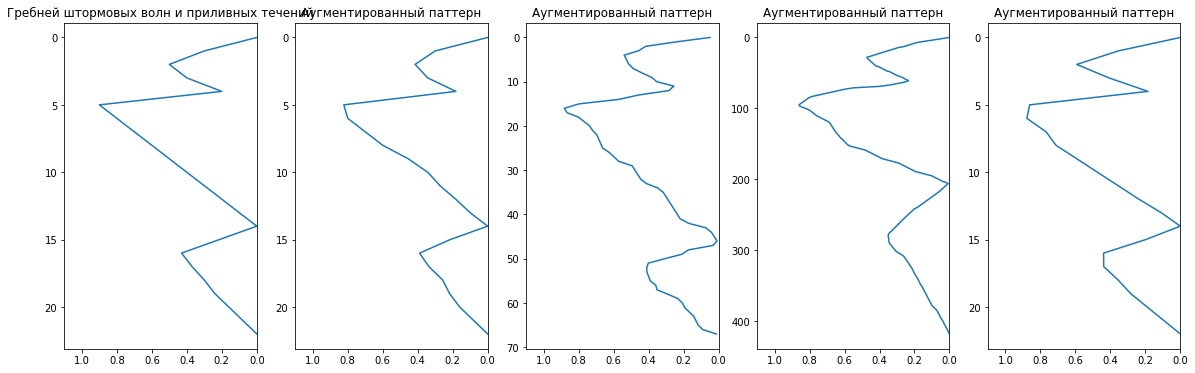

--------------------
Русловых отмелей спрямленных рек


C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


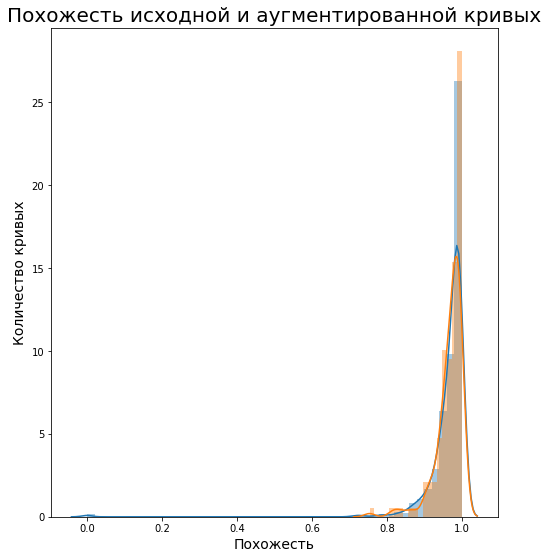

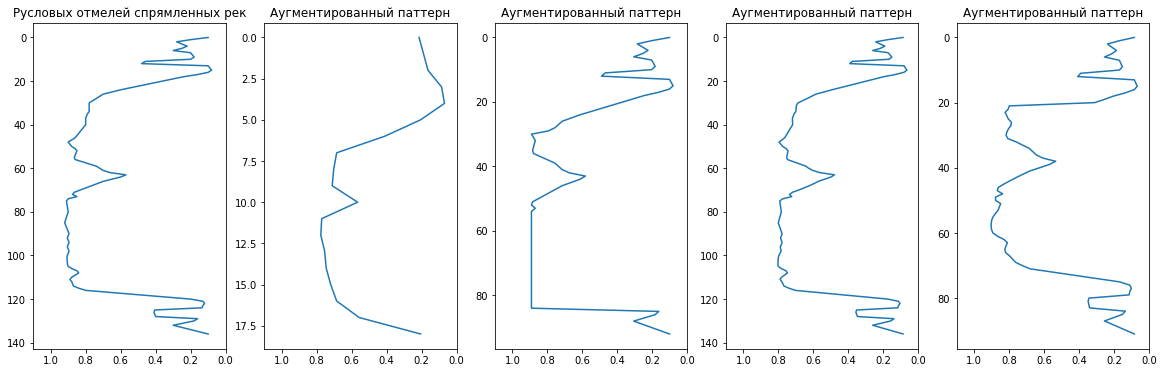

--------------------
Русловых отмелей фуркирующих рек (горного типа) и временных потоков


C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


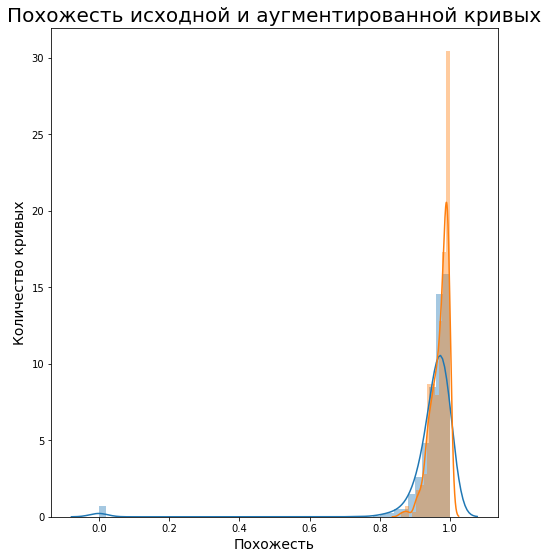

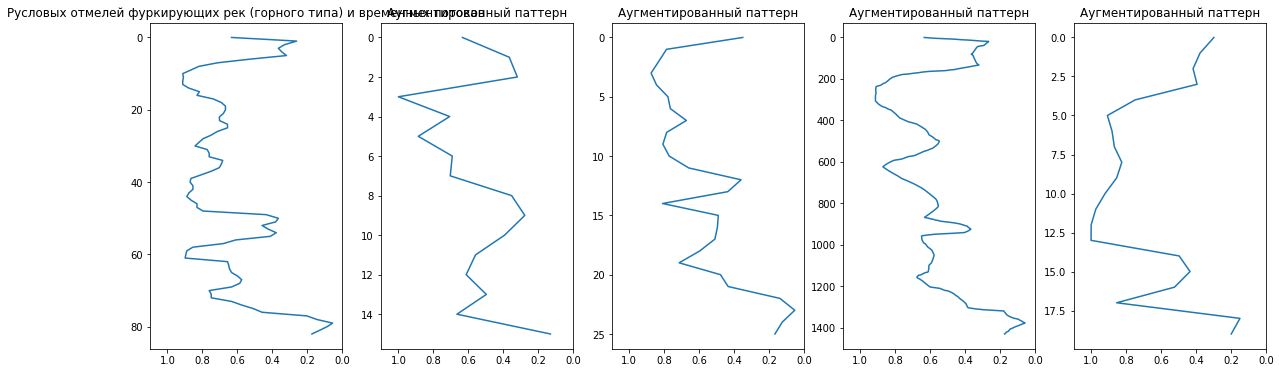

--------------------
Русловых отмелей равнинных меандрирующих рек


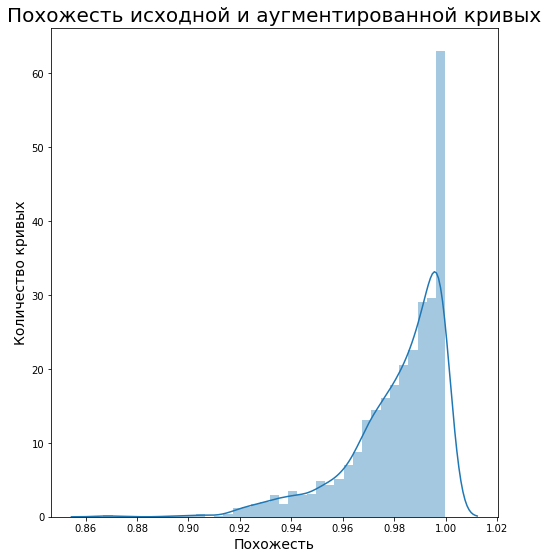

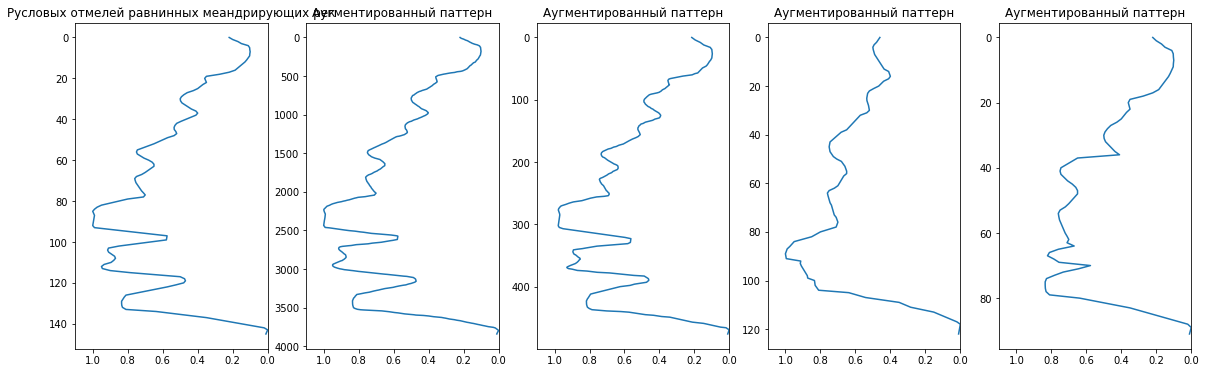

--------------------
Пески разливов


C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


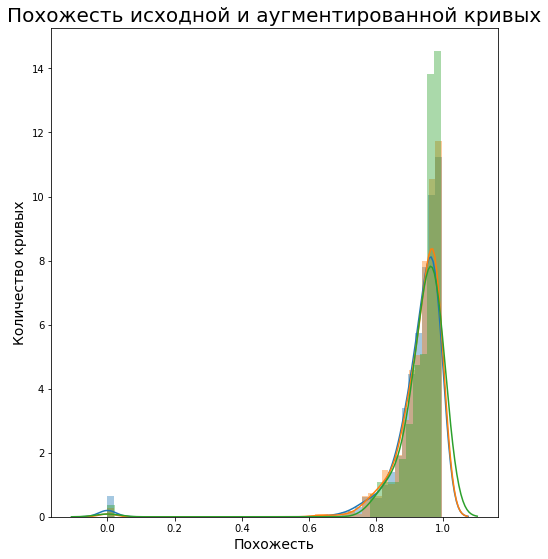

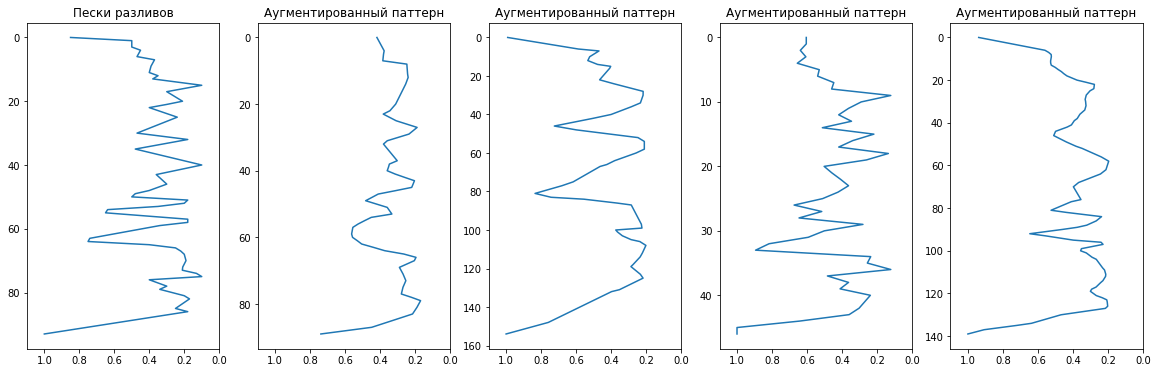

--------------------
Пойменных озер и болот


C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


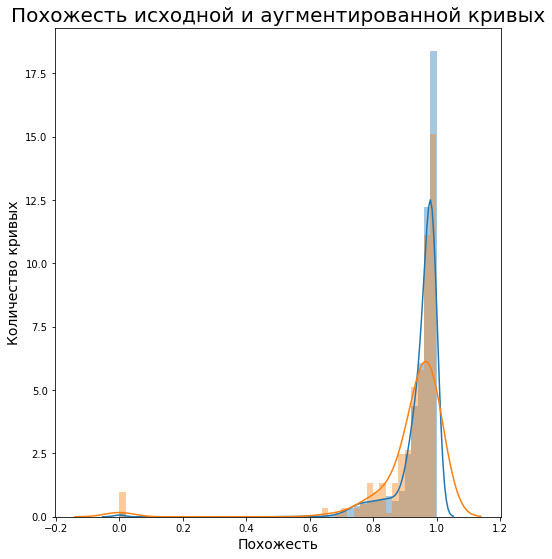

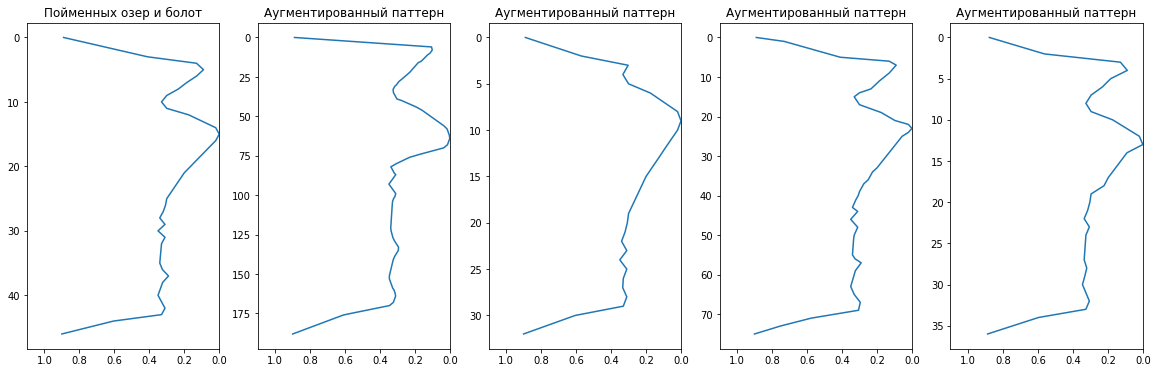

--------------------
Береговых валов


C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


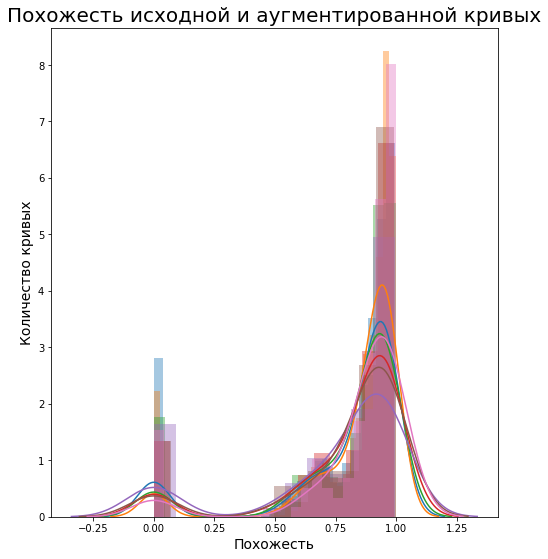

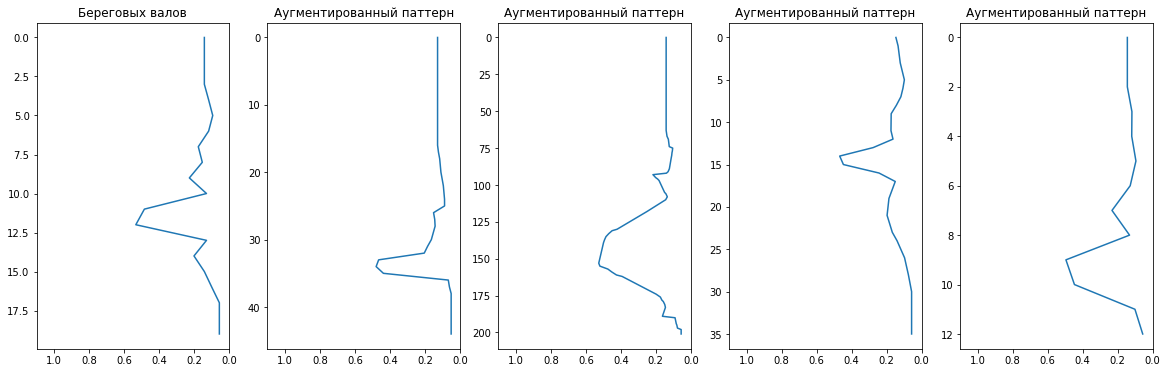

--------------------
Временно заливаемых участков пойм


C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


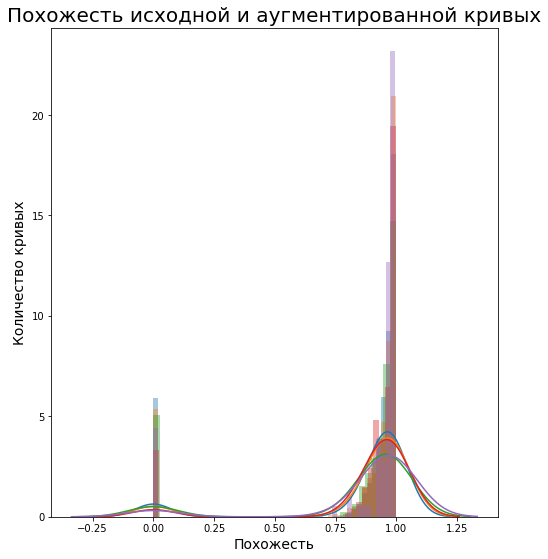

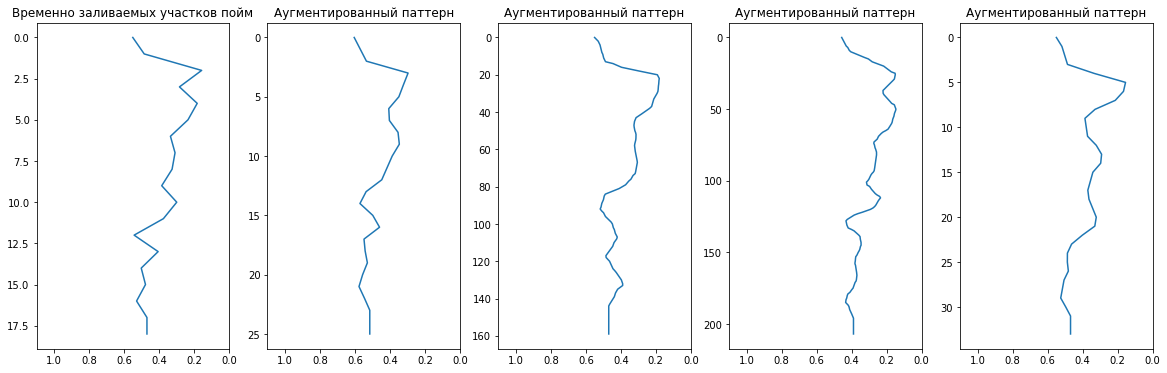

--------------------
Приморских болот (маршей, лайд и др.)


C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


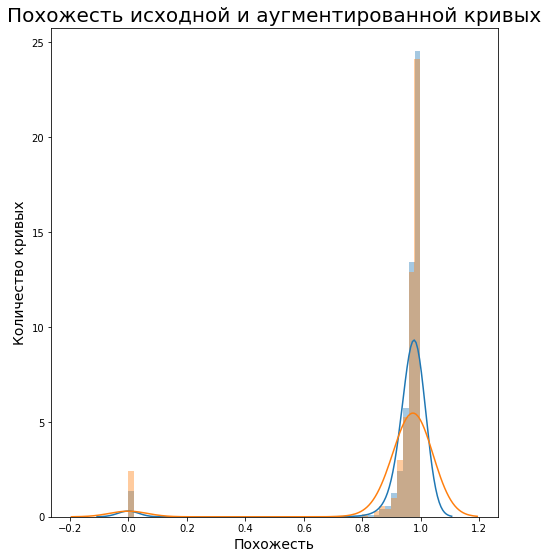

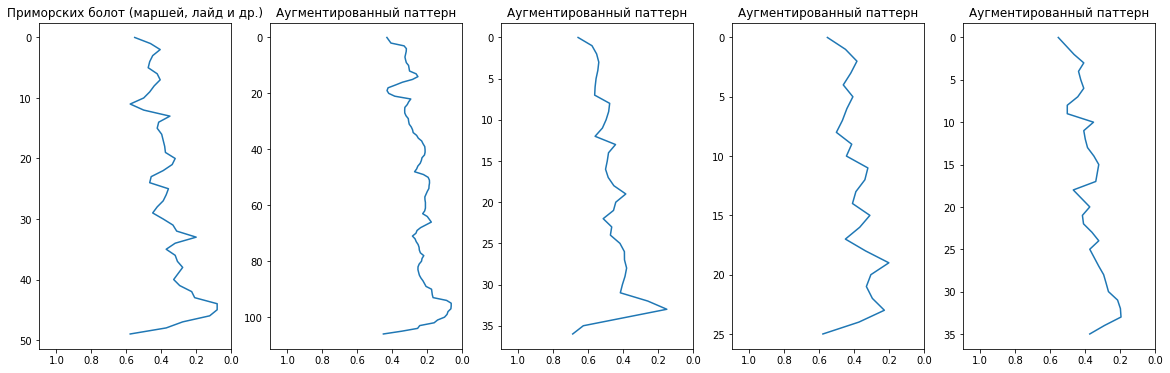

--------------------
Каньоны и каналы стока (питающие)


C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


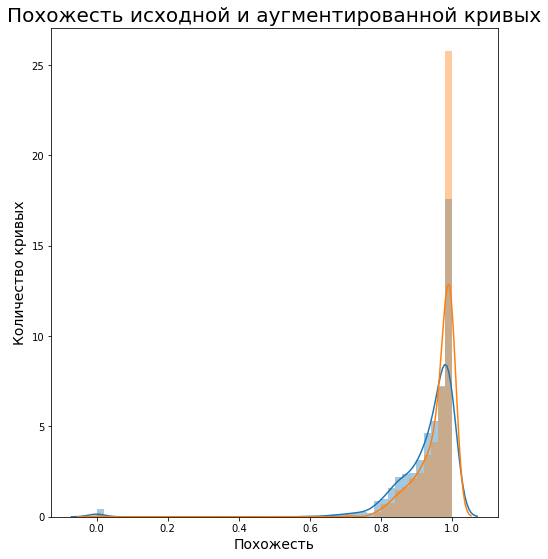

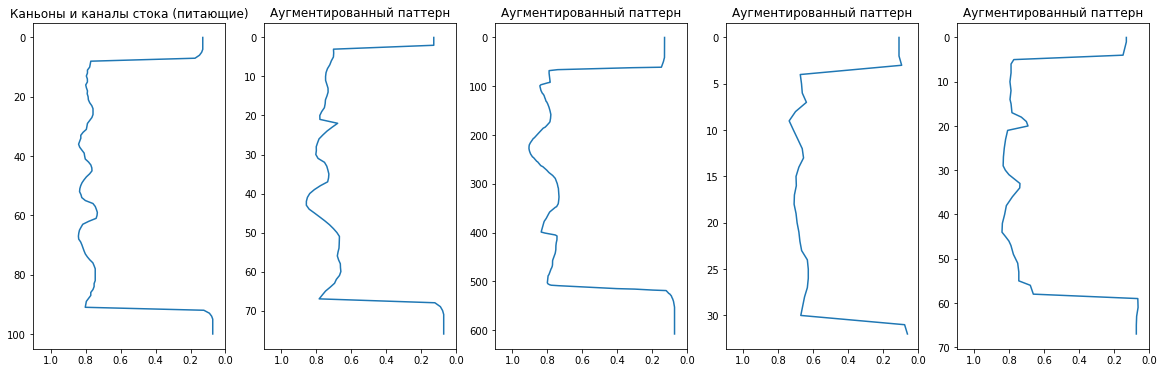

--------------------
Проксимальные турбидиты и зерновые потоки


C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


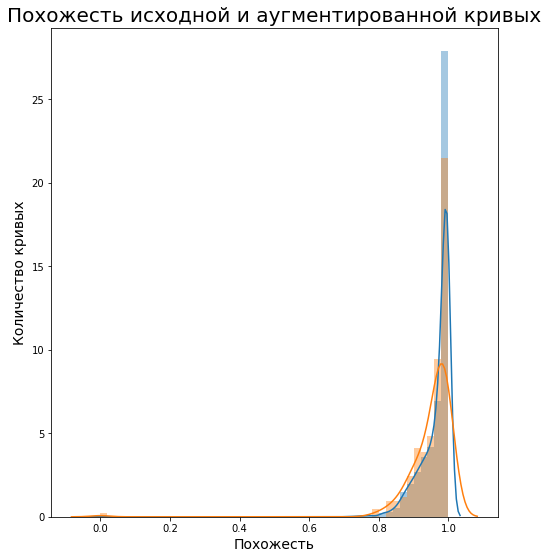

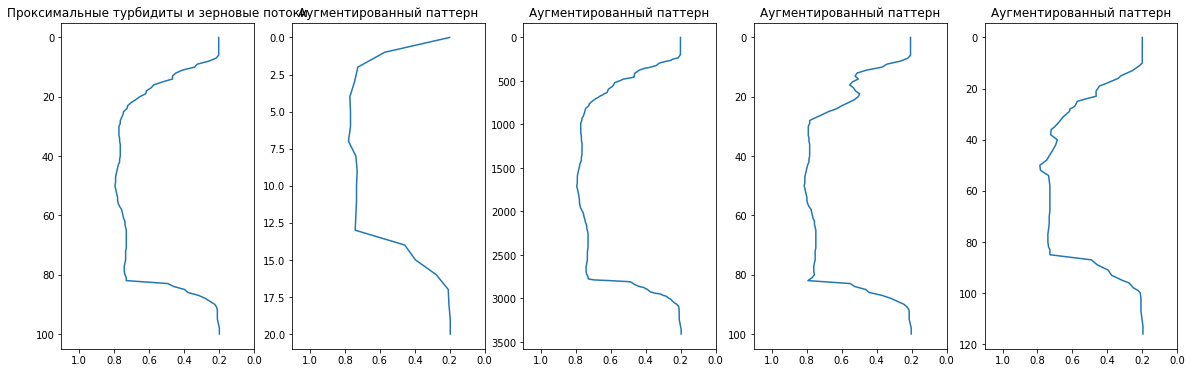

--------------------
Средние (переходные) турбидиты


C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


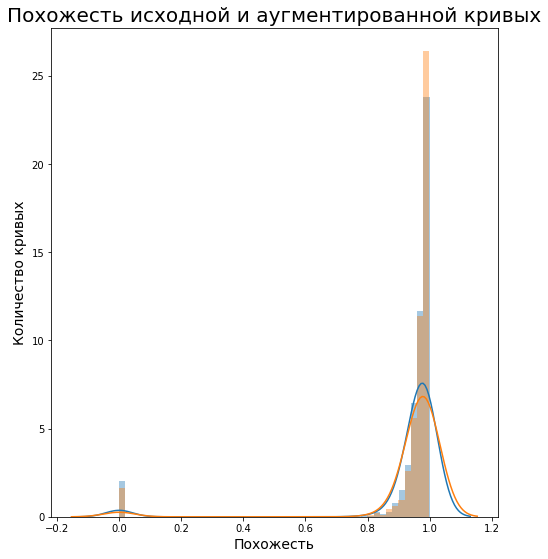

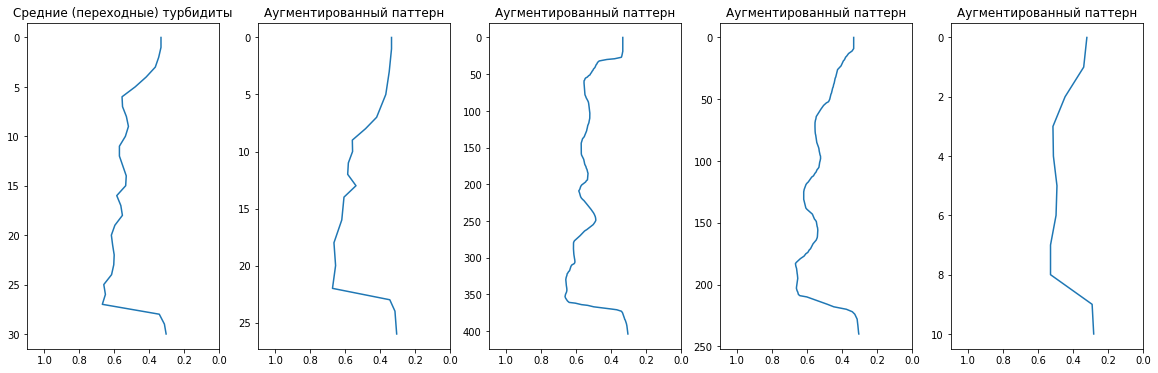

--------------------
Дистальные турбидиты


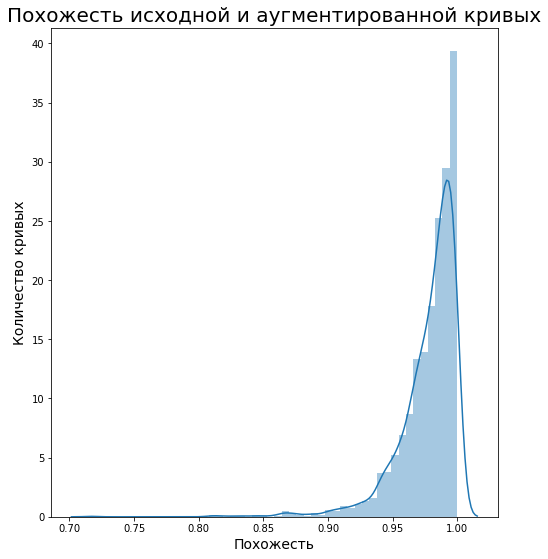

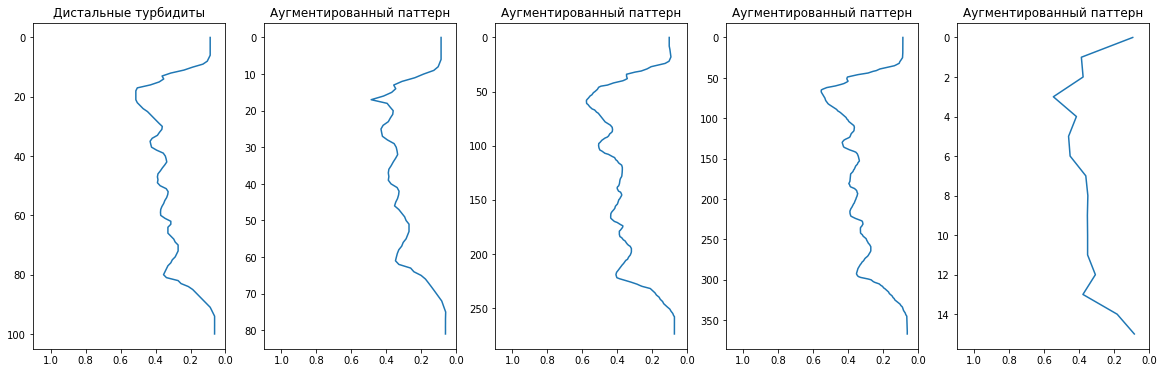

--------------------
Дно бассейна


C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


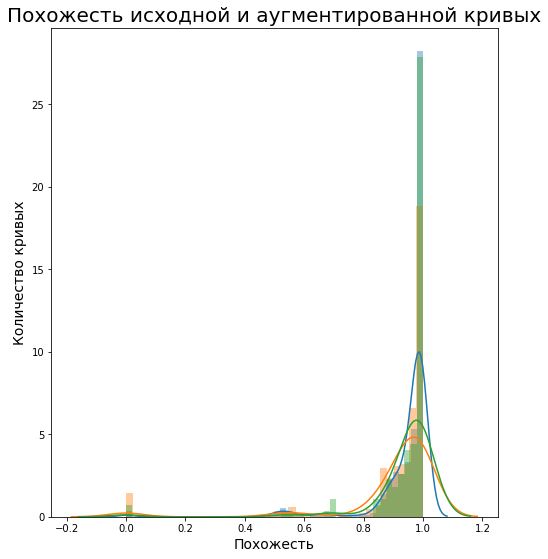

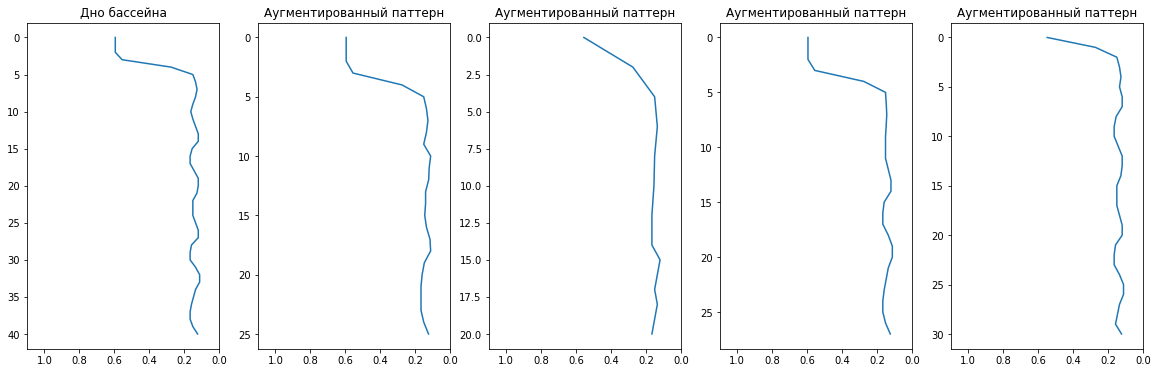

--------------------
Фации склона


C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


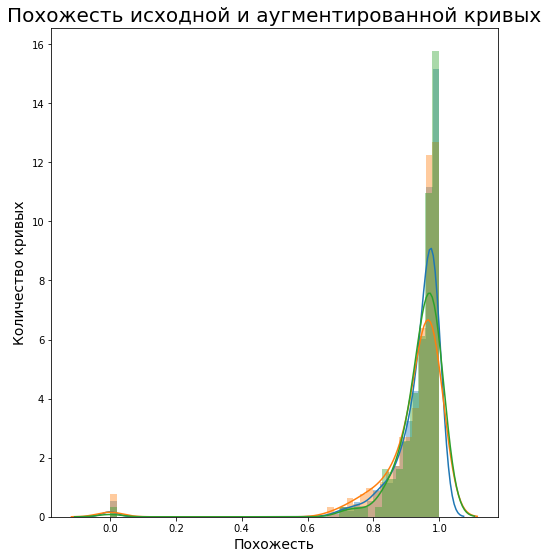

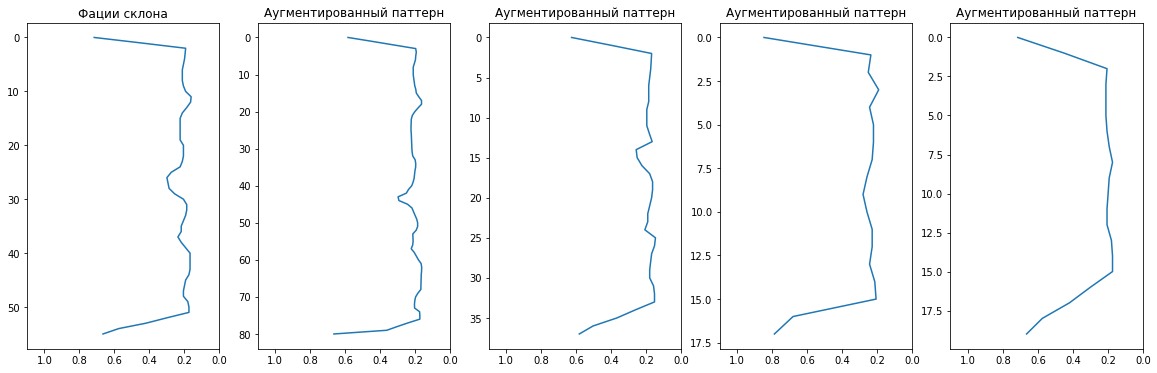

--------------------
Околоканальный вал


C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


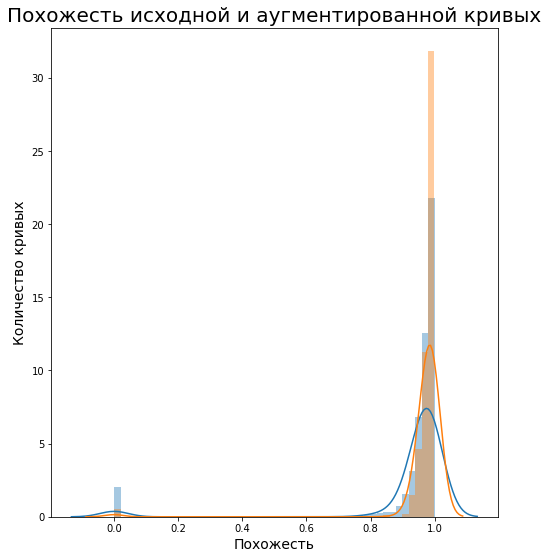

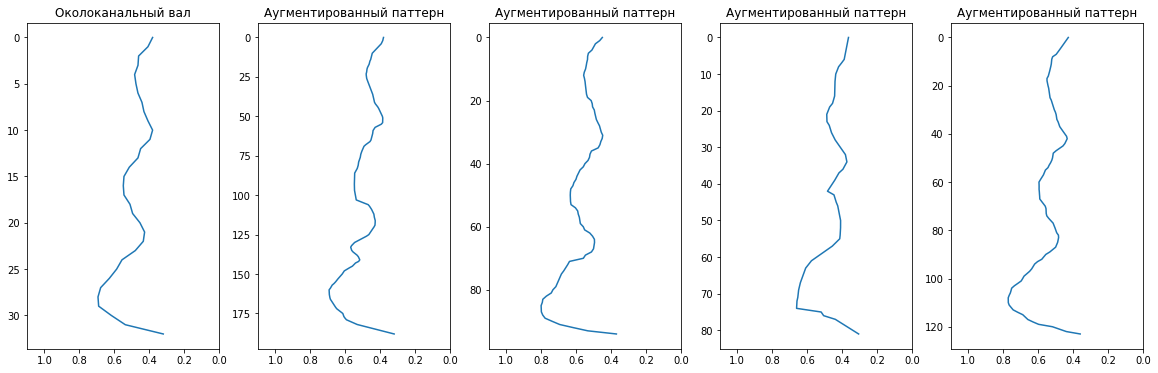

--------------------
Верхний веер склона


C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


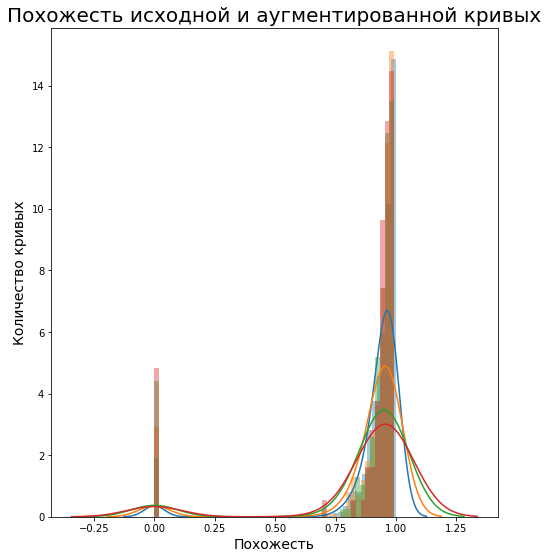

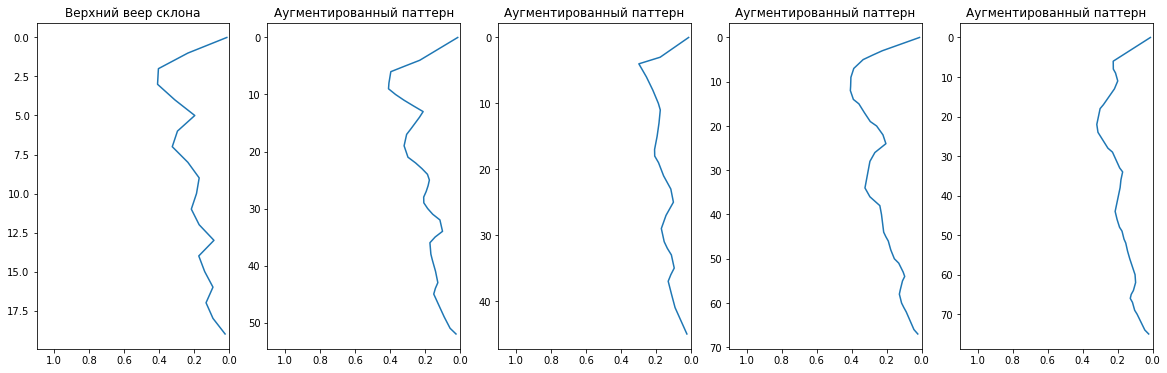

--------------------
Оползни


C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


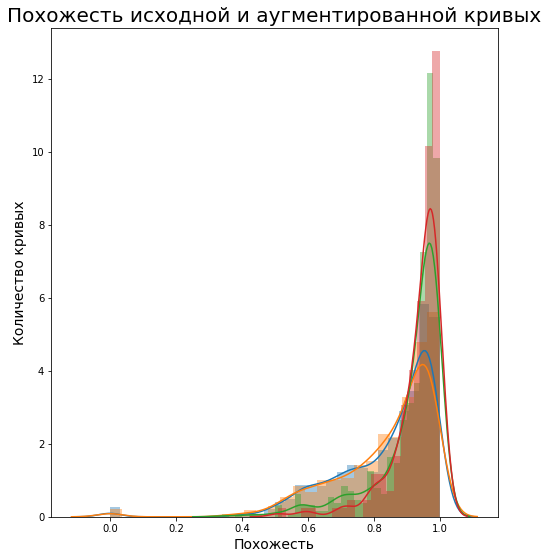

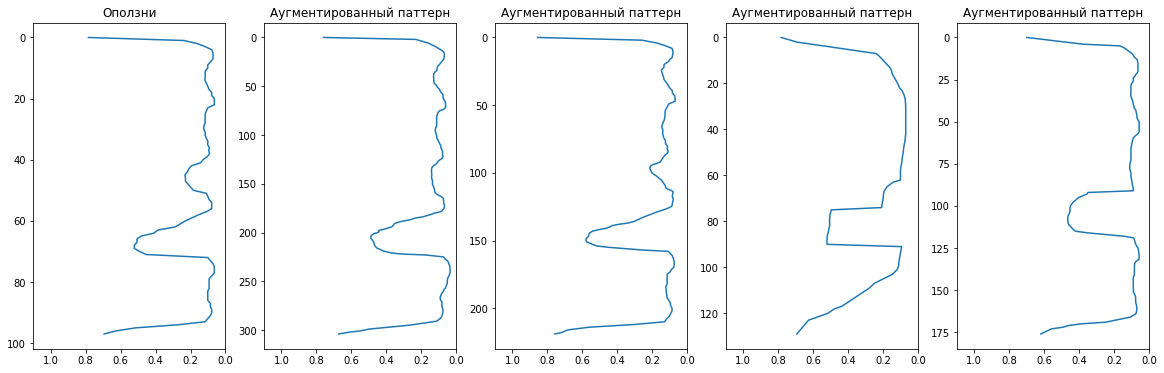

--------------------
Дельтовый канал


C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


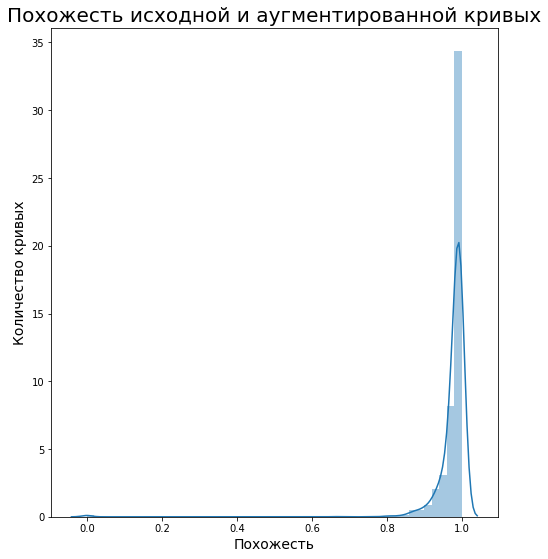

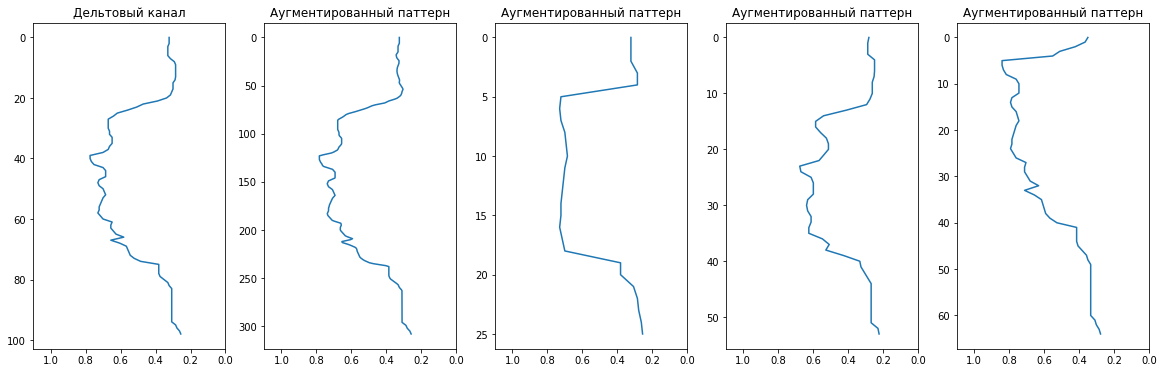

--------------------
Проксимальная часть дельты


C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


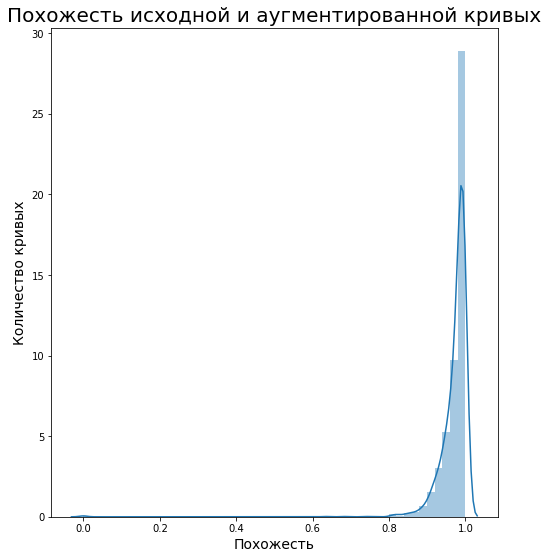

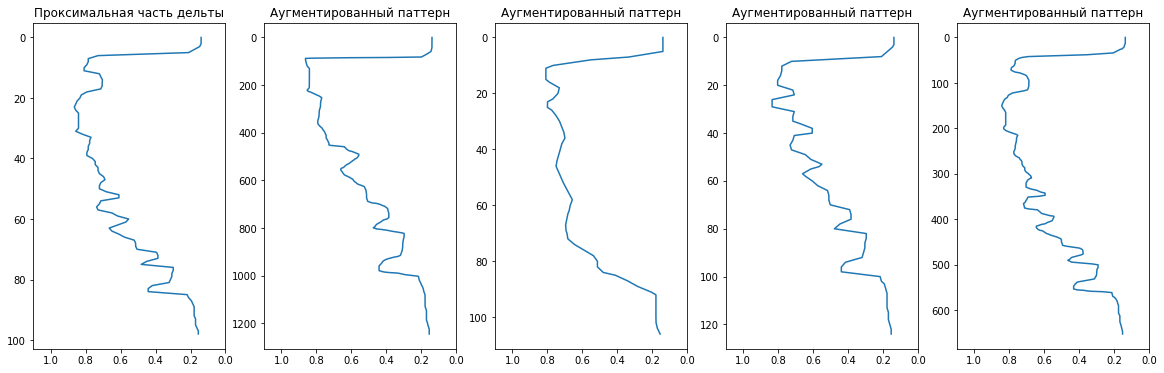

--------------------
Средняя часть дельты


C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


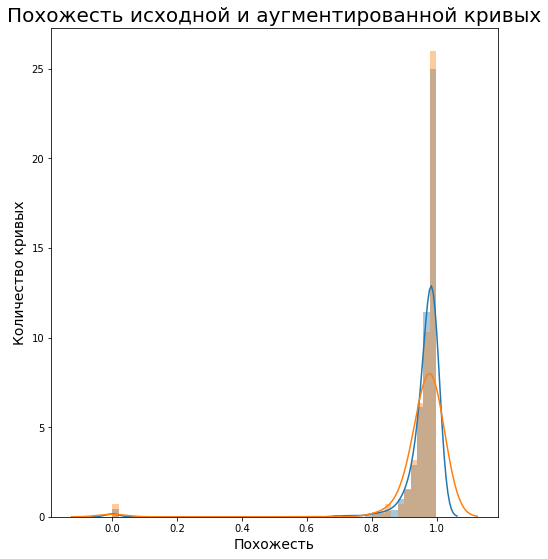

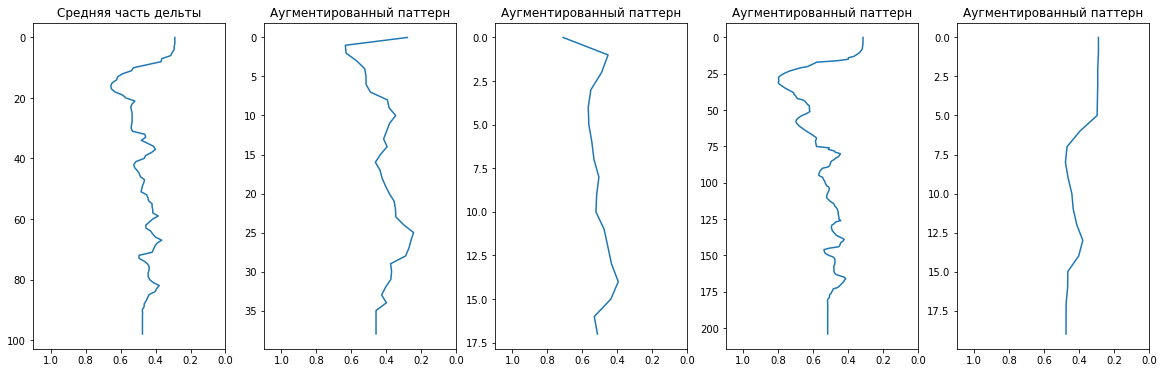

--------------------
Дистальная часть дельты


C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


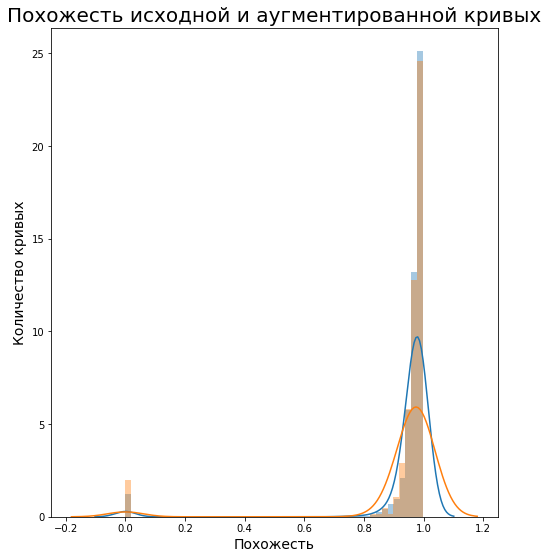

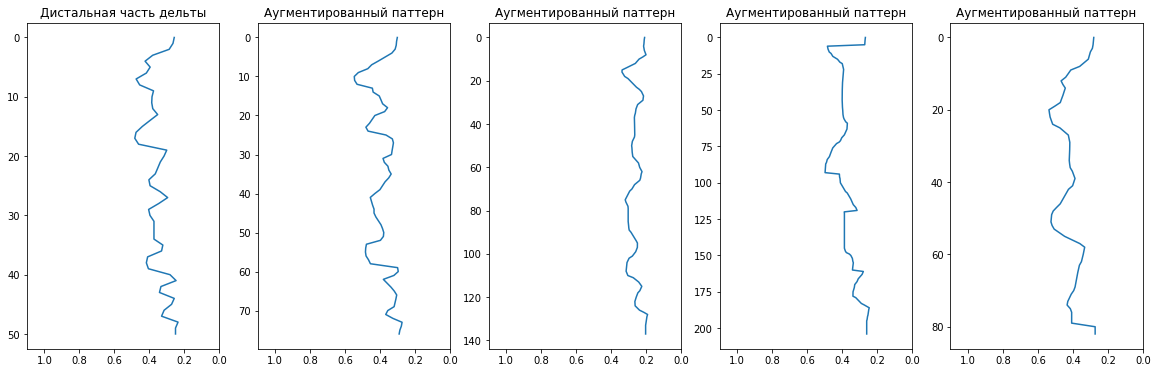

--------------------
Продельта


C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


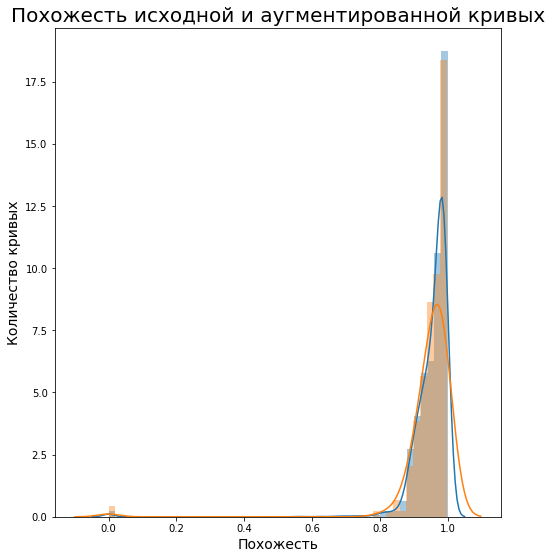

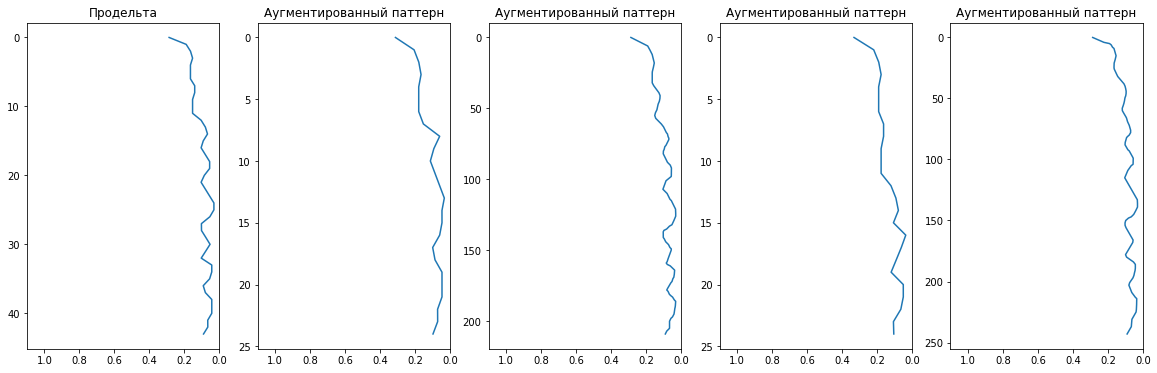

--------------------
Дюн


C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


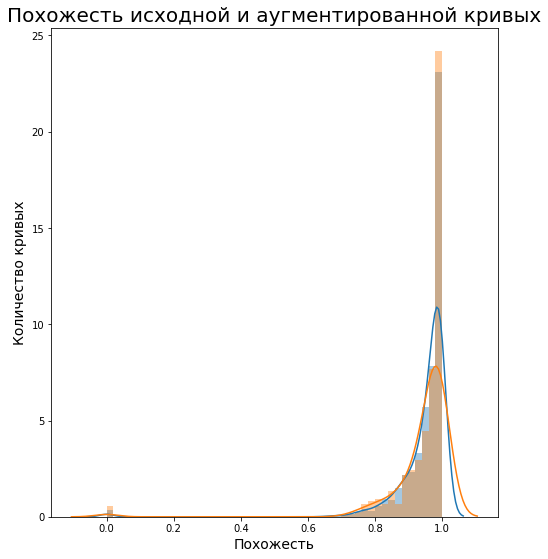

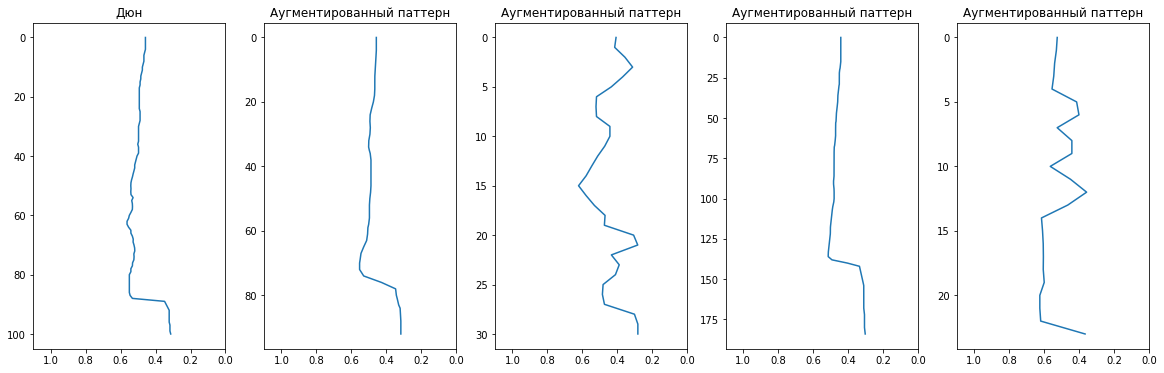

--------------------


In [19]:
SAVE_PATH = Path("data/augmented/")
MAX_ITER = 25

for curve in tqdm(facies):
    pattern_name = curve.iloc[0, 3]
    print(pattern_name)
    pattern = np.array(curve.iloc[:, 0])
    
    similar_curves = [pattern]
    iteration = 0
    
    while len(similar_curves) < N_AUGMENTATIONS and iteration < MAX_ITER:
        augmented_curves =  generate_augmented_curves(
            pattern,
            augmentations,
            n_curves=N_AUGMENTATIONS - len(similar_curves) + 100,
            n_augmentations=np.random.randint(2, 6),
            length_threshold=10
        )
        new_similar_curves = check_augmented_curves(pattern, augmented_curves)
        
        n_curves_required = N_AUGMENTATIONS - len(similar_curves)
        
        similar_curves.extend(new_similar_curves[: n_curves_required])
        
        iteration += 1
    
    n_cols = 5

    fig, axes = plt.subplots(1, n_cols, figsize=(n_cols*4, 6))
    for i, augmented_curve in enumerate(similar_curves[ : n_cols]):
        plot_well_log(depth=np.arange(augmented_curve.shape[0]), sp=augmented_curve, ax=axes[i])
    axes[0].set_title(pattern_name)
    for i in range(1, n_cols):
        axes[i].set_title("Аугментированный паттерн")
    plt.show()
    
    if similar_curves:
        file_path = SAVE_PATH / f"{pattern_name}.pkl"
        with open(file_path, "wb") as f:
            pickle.dump(similar_curves, f)
        
    print('-' * 20)

Можно генерировать аугментированные кривые на основе любых других массивов чисел. Для этого можно воспользоваться функцией `generate_augmented_curves()`

## Демонстрация работы аугментаций

In [103]:
def visualize_augmentation(
    pattern,
    pattern_name,
    augmentation,
    augmentation_name,
    same_plot=False,
    **augmentation_parameters
):
    n_cols = 1 if same_plot else 2
    figsize = (6, 5) if same_plot else (9, 5)
    
    fig, axes = plt.subplots(ncols=n_cols, figsize=figsize, sharey=True)

    pattern_ax = axes if same_plot else axes[0]
    pattern_title = "" if same_plot else "Исходная кривая"
    
    plot_well_log(
        depth=np.arange(pattern.shape[0]),
        sp=pattern,
        title=pattern_title,
        ax=pattern_ax,
        label="Исходная кривая"
    )
    
    augmented_pattern = augmentation(pattern, **augmentation_parameters)
    
    ax = axes if same_plot else axes[1]
    title = augmentation_name
    
    plot_well_log(
        depth=np.arange(augmented_pattern.shape[0]),
        sp=augmented_pattern,
        title=title,
        ax=ax,
        label="Аугментированная кривая"
    )
    
    pattern_ax.invert_yaxis()
    fig.suptitle(pattern_name, fontweight="bold")
    if same_plot:
        plt.legend();
    
    plt.show()

In [104]:
pattern = facies[facies_idx].iloc[:, 0].to_numpy()
pattern_name = facies[facies_idx].iloc[0, 3]

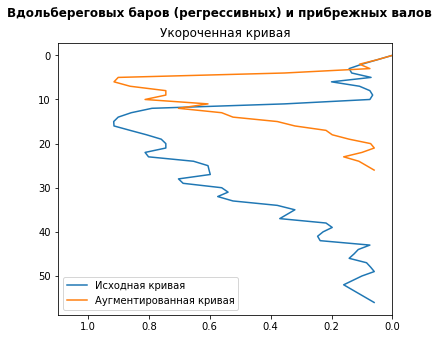

In [105]:
visualize_augmentation(
    pattern,
    pattern_name,
    drop_random_points,
    augmentation_name="Укороченная кривая",
    keep_probability=0.5,
    same_plot=True
)

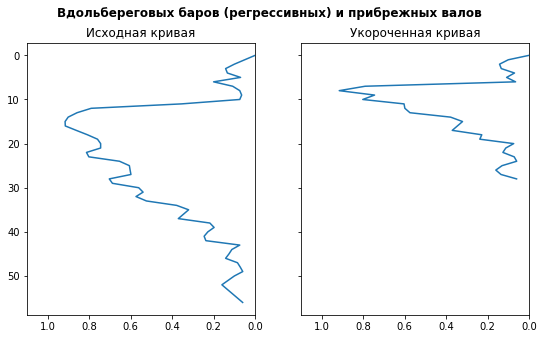

In [106]:
visualize_augmentation(
    pattern,
    pattern_name,
    drop_random_points,
    augmentation_name="Укороченная кривая",
    keep_probability=0.5
)

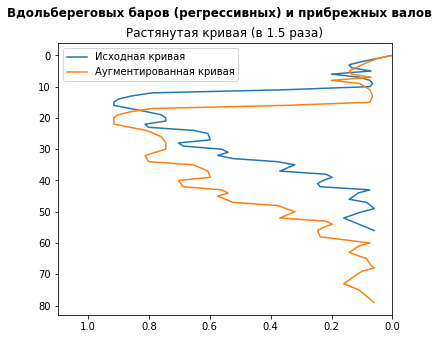

In [107]:
visualize_augmentation(
    pattern,
    pattern_name,
    insert_points,
    augmentation_name="Растянутая кривая (в 1.5 раза)",
    insertion_probability=0.5,
    same_plot=True
)

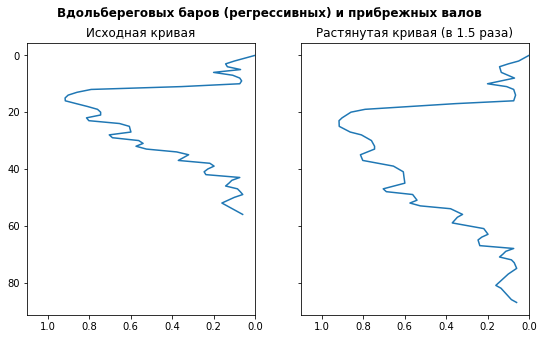

In [108]:
visualize_augmentation(
    pattern,
    pattern_name,
    insert_points,
    augmentation_name="Растянутая кривая (в 1.5 раза)",
    insertion_probability=0.5
)

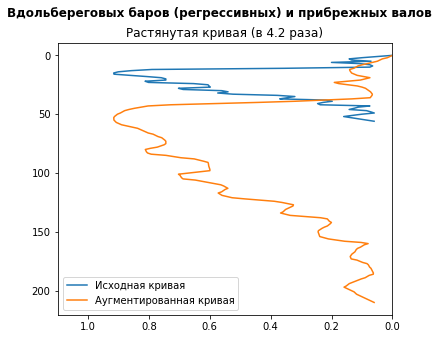

In [109]:
visualize_augmentation(
    pattern,
    pattern_name,
    stretch_function,
    augmentation_name="Растянутая кривая (в 4.2 раза)",
    stretching_coef=3.2,
    same_plot=True
)

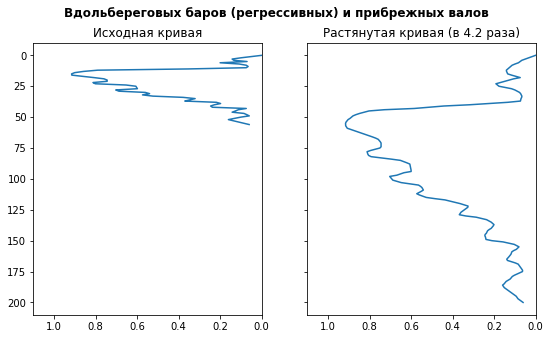

In [110]:
visualize_augmentation(
    pattern,
    pattern_name,
    stretch_function,
    augmentation_name="Растянутая кривая (в 4.2 раза)",
    stretching_coef=3.2
)

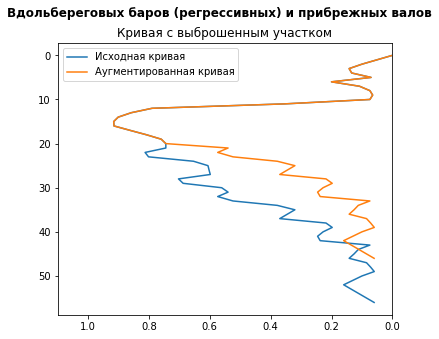

In [111]:
visualize_augmentation(
    pattern,
    pattern_name,
    remove_random_region,
    augmentation_name="Кривая с выброшенным участком",
    region_size=10,
    same_plot=True
)

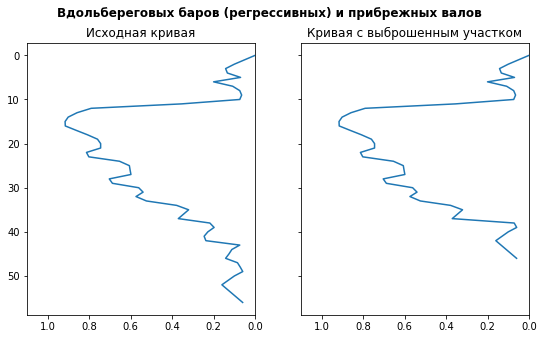

In [112]:
visualize_augmentation(
    pattern,
    pattern_name,
    remove_random_region,
    augmentation_name="Кривая с выброшенным участком",
    region_size=10
)

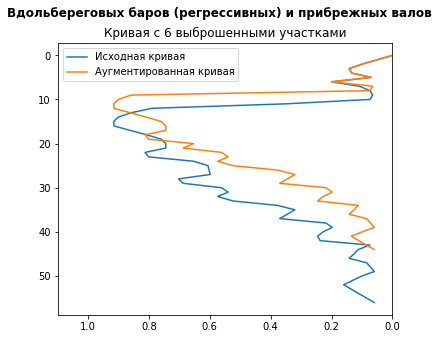

In [113]:
visualize_augmentation(
    pattern,
    pattern_name,
    remove_random_regions,
    augmentation_name="Кривая с 6 выброшенными участками",
    fraction=0.05,
    n_regions=6,
    same_plot=True
)

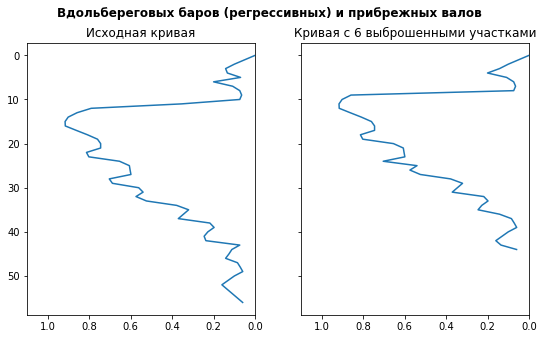

In [114]:
visualize_augmentation(
    pattern,
    pattern_name,
    remove_random_regions,
    augmentation_name="Кривая с 6 выброшенными участками",
    fraction=0.05,
    n_regions=6
)

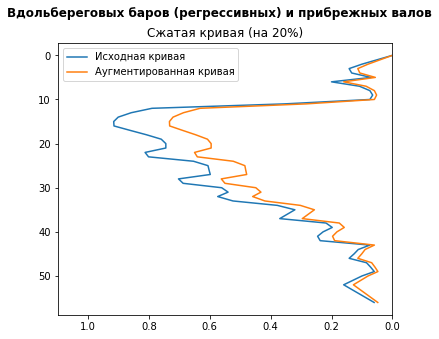

In [115]:
visualize_augmentation(
    pattern,
    pattern_name,
    squeeze_function,
    augmentation_name="Сжатая кривая (на 20%)",
    coef=0.8,
    same_plot=True
)

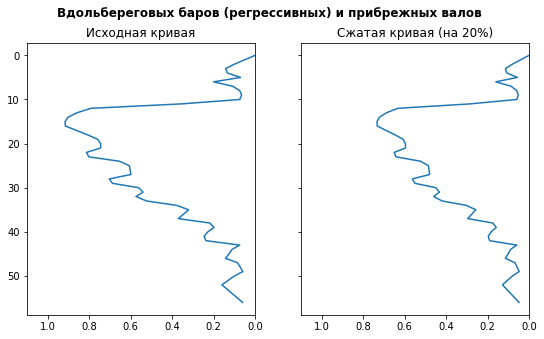

In [116]:
visualize_augmentation(
    pattern,
    pattern_name,
    squeeze_function,
    augmentation_name="Сжатая кривая (на 20%)",
    coef=0.8
)

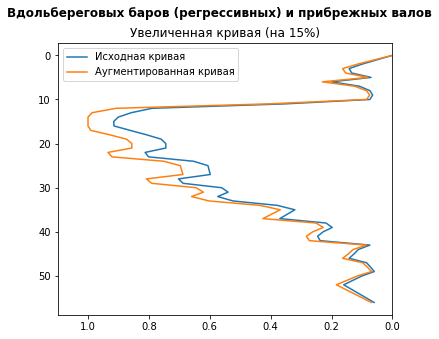

In [117]:
visualize_augmentation(
    pattern,
    pattern_name,
    squeeze_function,
    augmentation_name="Увеличенная кривая (на 15%)",
    coef=1.15,
    same_plot=True
)

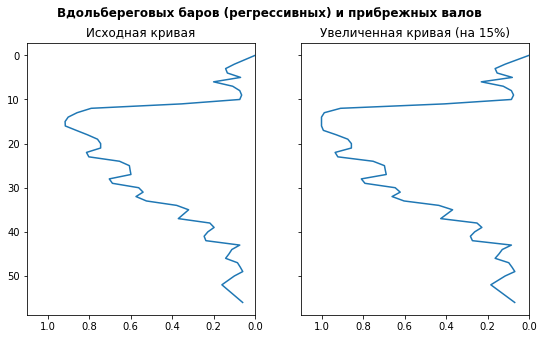

In [118]:
visualize_augmentation(
    pattern,
    pattern_name,
    squeeze_function,
    augmentation_name="Увеличенная кривая (на 15%)",
    coef=1.15
)

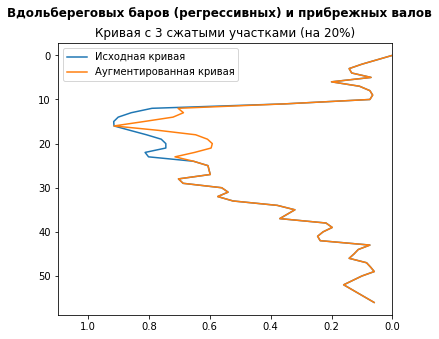

In [119]:
visualize_augmentation(
    pattern,
    pattern_name,
    squeeze_random_regions,
    augmentation_name="Кривая с 3 сжатыми участками (на 20%)",
    fraction=0.1,
    n_regions=3,
    coef=0.8,
    same_plot=True
)

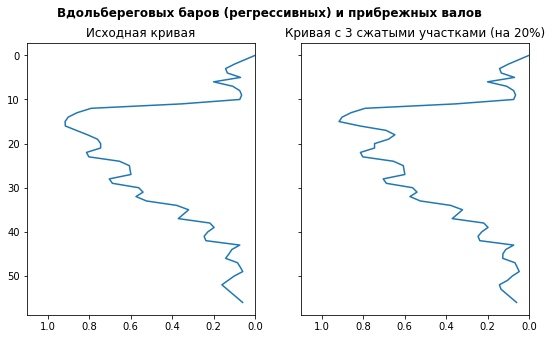

In [120]:
visualize_augmentation(
    pattern,
    pattern_name,
    squeeze_random_regions,
    augmentation_name="Кривая с 3 сжатыми участками (на 20%)",
    fraction=0.1,
    n_regions=3,
    coef=0.8
)

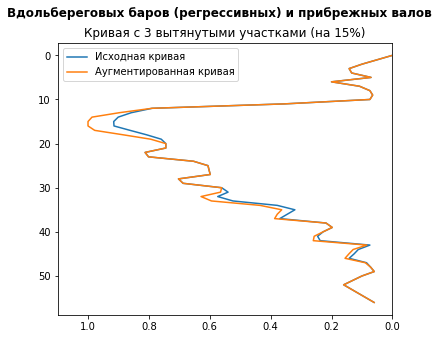

In [123]:
visualize_augmentation(
    pattern,
    pattern_name,
    squeeze_random_regions,
    augmentation_name="Кривая с 3 вытянутыми участками (на 15%)",
    fraction=.15,
    n_regions=3,
    coef=1.15,
    same_plot=True
)

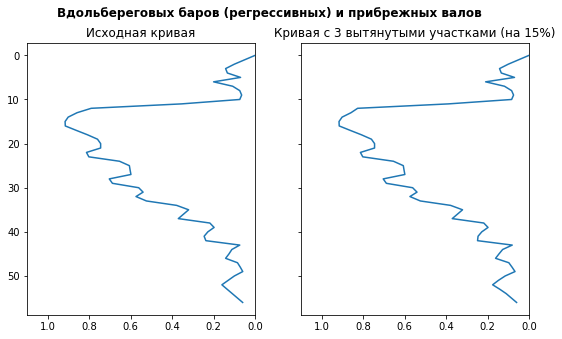

In [124]:
visualize_augmentation(
    pattern,
    pattern_name,
    squeeze_random_regions,
    augmentation_name="Кривая с 3 вытянутыми участками (на 15%)",
    fraction=.15,
    n_regions=3,
    coef=1.15
)

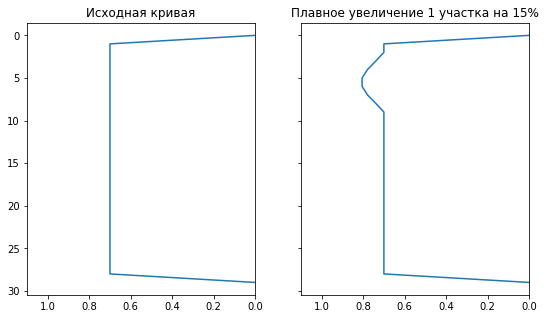

In [125]:
curve = np.ones(30) - .3
curve[0] = 0
curve[29] = 0

visualize_augmentation(
    curve,
    "",
    squeeze_random_regions,
    augmentation_name="Плавное увеличение 1 участка на 15%",
    fraction=.25,
    n_regions=1,
    coef=1.15
)

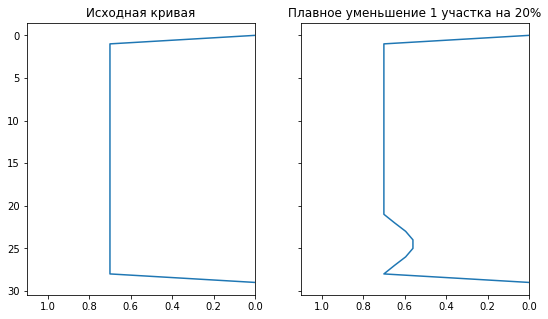

In [126]:
curve = np.ones(30) - .3
curve[0] = 0
curve[29] = 0

visualize_augmentation(
    curve,
    "",
    squeeze_random_regions,
    augmentation_name="Плавное уменьшение 1 участка на 20%",
    fraction=.25,
    n_regions=1,
    coef=.8
)

In [31]:
augmented_pattern = drop_random_points(pattern, keep_probability=.5)

Text(0.5, 1.0, 'Выровненные при помощи DTW кривые')

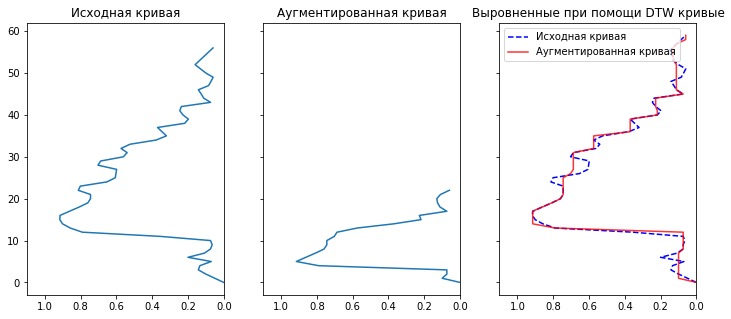

In [32]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 5), sharey=True)

plot_well_log(depth=np.arange(pattern.shape[0]), sp=pattern, title="Исходная кривая", ax=axes[0])

plot_well_log(
    depth=np.arange(augmented_pattern.shape[0]),
    sp=augmented_pattern,
    title="Аугментированная кривая",
    ax=axes[1]
)

aligned_pattern, aligned_augmented_pattern = align_arrays_with_DTW(pattern, augmented_pattern)

axes[2].plot(aligned_pattern, np.arange(aligned_pattern.shape[0]), "b--", alpha=1, label="Исходная кривая")
axes[2].plot(
    aligned_augmented_pattern, 
    np.arange(aligned_augmented_pattern.shape[0]),
    "r-",
    alpha=.8, 
    label="Аугментированная кривая"
)
axes[2].set_xlim(1.1, 0)
axes[2].legend()
axes[2].set_title("Выровненные при помощи DTW кривые")

In [33]:
dtw_correlation_metric(pattern, augmented_pattern)

0.9840801623207682

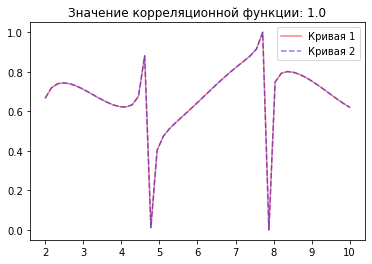

In [34]:
plt.figure(figsize=(6, 4))

x = np.linspace(2, 10, 50)
arr_1 = np.sin(x) + np.tan(x) / x
arr_1 -= min(arr_1)
arr_1 /= max(arr_1)

arr_2 = arr_1.copy()
similarity = round(dtw_correlation_metric(arr_1, arr_2), 2)

plt.plot(x, arr_1, "r-", alpha=.5, label="Кривая 1")
plt.plot(x, arr_2, "b--", alpha=.5, label="Кривая 2")
plt.title(f"Значение корреляционной функции: {similarity}")
plt.legend()

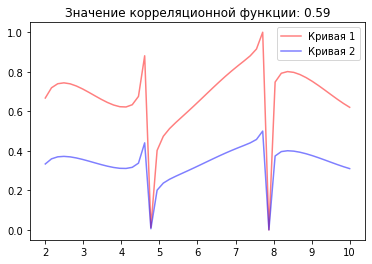

In [35]:
plt.figure(figsize=(6, 4))

x = np.linspace(2, 10, 50)
arr_1 = np.sin(x) + np.tan(x) / x
arr_1 -= min(arr_1)
arr_1 /= max(arr_1)

arr_2 = arr_1.copy() / 2

similarity = round(dtw_correlation_metric(arr_1, arr_2), 2)

plt.plot(x, arr_1, "r-", alpha=.5, label="Кривая 1")
plt.plot(x, arr_2, "b-", alpha=.5, label="Кривая 2")
plt.title(f"Значение корреляционной функции: {similarity}")
plt.legend()

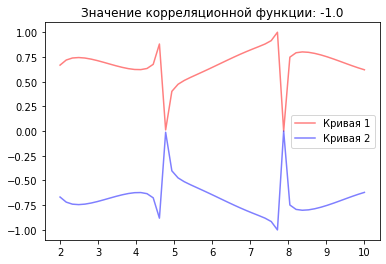

In [36]:
plt.figure(figsize=(6, 4))

x = np.linspace(2, 10, 50)
arr_1 = np.sin(x) + np.tan(x) / x
arr_1 -= min(arr_1)
arr_1 /= max(arr_1)

arr_2 = -arr_1.copy()

similarity = round(dtw_correlation_metric(arr_1, arr_2), 2)

plt.plot(x, arr_1, "r-", alpha=.5, label="Кривая 1")
plt.plot(x, arr_2, "b-", alpha=.5, label="Кривая 2")
plt.title(f"Значение корреляционной функции: {similarity}")
plt.legend()

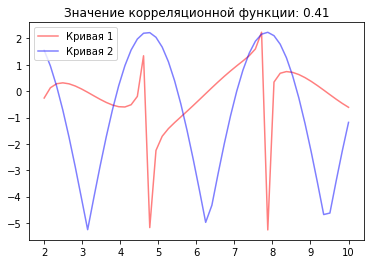

In [37]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

plt.figure(figsize=(6, 4))

x = np.linspace(2, 10, 50)
arr_1 = np.sin(x) + np.tan(x) / x
arr_1 -= min(arr_1)
arr_1 /= max(arr_1)

arr_1 = scaler.fit_transform(arr_1.reshape(-1, 1)).flatten()


arr_2 = abs(np.sin(x))
arr_2 = scaler.transform(arr_2.reshape(-1, 1)).flatten()

similarity = round(dtw_correlation_metric(arr_1, arr_2), 2)

plt.plot(x, arr_1, "r-", alpha=.5, label="Кривая 1")
plt.plot(x, arr_2, "b-", alpha=.5, label="Кривая 2")
plt.title(f"Значение корреляционной функции: {similarity}")
plt.legend()

# Аугментация данных с экспертной разметкой

In [15]:
REAL_DATA_PATH = Path("C:/Users/vladi/PycharmProjects/patterns_search/data/real/")

In [16]:
with open(REAL_DATA_PATH / "data_экспертные_фации.pkl", "rb") as f:
    expert_data = pickle.load(f)
expert_data

UWI   Top Bottom Thickness ind_top ind_bot  \
0     101P_y-kin pre_2  None   None      None    None    None   
1     101P_y-kin pre_3  None   None      None    None    None   
2     101P_y-kin pre_4  None   None      None    None    None   
3        105_unt pre_2  None   None      None    None    None   
4        107_unt pre_1  None   None      None    None    None   
...                ...   ...    ...       ...     ...     ...   
1475  92_sr-ugut pre_3  None   None      None    None    None   
1476  92_sr-ugut pre_4  None   None      None    None    None   
1477      9_ugut pre_1  None   None      None    None    None   
1478      9_ugut pre_2  None   None      None    None    None   
1479      9_ugut pre_3  None   None      None    None    None   

                                                     sp  \
0     [146.25, 146.625, 146.91000366, 147.17300415, ...   
1     [106.11799622, 105.375, 104.81300354, 103.8600...   
2     [135.11999512, 137.89500427, 139.13999939, 140...   
3     [139.05000305, 138.78900146, 138.63400269, 138...   
4     [113.917099, 113.74120331, 113.51339722, 113.2...   
...                                                 ...   
1475  [83.10269928, 82.309700012, 81.675300598, 81.6...   
1476  [102.29239655, 102.84750366, 103.40249634, 104...   
1477  [122.41000366, 122.41000366, 122.59999847, 122...   
1478  [119.12000275, 117.84999847, 117.72000122, 118...   
1479  [121.13999939, 123.11000061, 123.73999786, 122...   

                                                   dept  \
0     [2891.68, 2891.78, 2891.88, 2891.98, 2892.08, ...   
1     [2901.18, 2901.28, 2901.38, 2901.48, 2901.58, ...   
2     [2915.28, 2915.38, 2915.48, 2915.58, 2915.68, ...   
3     [2888.6, 2888.8, 2889.0, 2889.2, 2889.4, 2889....   
4     [2913.02, 2913.22, 2913.42, 2913.62, 2913.82, ...   
...                                                 ...   
1475  [2956.1, 2956.2, 2956.3, 2956.4, 2956.5, 2956....   
1476  [2961.6, 2961.7, 2961.8, 2961.9, 2962.0, 2962....   
1477  [2817.0, 2817.2, 2817.4, 2817.6, 2817.8, 2818....   
1478  [2819.8, 2820.0, 2820.2, 2820.4, 2820.6, 2820....   
1479  [2828.4, 2828.6, 2828.8, 2829.0, 2829.2, 2829....   

                                                     gr code  \
0     [14.472000122, 14.248999596, 14.510000229, 14....   16   
1     [2.7430000305, 2.6610000134, 2.5799999237, 2.5...   20   
2     [12.479999542, 13.137999535, 13.199000359, 13....   -1   
3     [9.045999527, 9.3760004044, 9.5240001678, 9.57...   11   
4     [10.939889908, 9.3810997009, 8.3849496841, 9.0...   -1   
...                                                 ...  ...   
1475  [7.428899765, 7.1371002197, 6.9340000153, 6.80...   15   
1476  [10.182700157, 10.201800346, 10.2208004, 10.33...   11   
1477  [9.2700004578, 8.9899997711, 8.2299995422, 8.4...   -1   
1478  [8.4399995804, 8.5, 8.8599996567, 8.6400003433...   11   
1479  [10.119999886, 10.859999657, 10.390000343, 10....   -1   

                                                    Asp  \
0     [0.06808442040224216, 0.06340142753994193, 0.0...   
1     [0.5692521197397042, 0.5785306423929739, 0.585...   
2     [0.20707570949666199, 0.1724214480506141, 0.15...   
3     [0.36326344942569744, 0.40985419506051546, 0.4...   
4     [0.0, 0.0953261050746228, 0.2187848849456947, ...   
...                                                 ...   
1475  [0.958713838019819, 0.981650594681903, 1.0, 1....   
1476  [0.40366992503975685, 0.38761397490556015, 0.3...   
1477  [0.10137154692887695, 0.10137154692887695, 0.0...   
1478  [0.35213390487307916, 0.44893304765873476, 0.4...   
1479  [0.1981706889523377, 0.048018100976258804, 0.0...   

                                                    Agr    UWI_uniq  
0     [0.04305140782568384, 0.06099624770555012, 0.0...  101P_y-kin  
1     [0.9868833905040784, 0.9934819273030715, 1.0, ...  101P_y-kin  
2     [0.20334758330959646, 0.15039836060086542, 0.1...  101P_y-kin  
3     [0.997477398343677, 0.9419777562537535, 0.9170...     10

In [17]:
expert_data.columns

Index(['UWI', 'Top', 'Bottom', 'Thickness', 'ind_top', 'ind_bot', 'sp', 'dept',
       'gr', 'code', 'Asp', 'Agr', 'UWI_uniq'],
      dtype='object')

In [18]:
expert_data["code"] = expert_data["code"].replace(
    patterns_codes_to_names
)

In [19]:
expert_data

UWI   Top Bottom Thickness ind_top ind_bot  \
0     101P_y-kin pre_2  None   None      None    None    None   
1     101P_y-kin pre_3  None   None      None    None    None   
2     101P_y-kin pre_4  None   None      None    None    None   
3        105_unt pre_2  None   None      None    None    None   
4        107_unt pre_1  None   None      None    None    None   
...                ...   ...    ...       ...     ...     ...   
1475  92_sr-ugut pre_3  None   None      None    None    None   
1476  92_sr-ugut pre_4  None   None      None    None    None   
1477      9_ugut pre_1  None   None      None    None    None   
1478      9_ugut pre_2  None   None      None    None    None   
1479      9_ugut pre_3  None   None      None    None    None   

                                                     sp  \
0     [146.25, 146.625, 146.91000366, 147.17300415, ...   
1     [106.11799622, 105.375, 104.81300354, 103.8600...   
2     [135.11999512, 137.89500427, 139.13999939, 140...   
3     [139.05000305, 138.78900146, 138.63400269, 138...   
4     [113.917099, 113.74120331, 113.51339722, 113.2...   
...                                                 ...   
1475  [83.10269928, 82.309700012, 81.675300598, 81.6...   
1476  [102.29239655, 102.84750366, 103.40249634, 104...   
1477  [122.41000366, 122.41000366, 122.59999847, 122...   
1478  [119.12000275, 117.84999847, 117.72000122, 118...   
1479  [121.13999939, 123.11000061, 123.73999786, 122...   

                                                   dept  \
0     [2891.68, 2891.78, 2891.88, 2891.98, 2892.08, ...   
1     [2901.18, 2901.28, 2901.38, 2901.48, 2901.58, ...   
2     [2915.28, 2915.38, 2915.48, 2915.58, 2915.68, ...   
3     [2888.6, 2888.8, 2889.0, 2889.2, 2889.4, 2889....   
4     [2913.02, 2913.22, 2913.42, 2913.62, 2913.82, ...   
...                                                 ...   
1475  [2956.1, 2956.2, 2956.3, 2956.4, 2956.5, 2956....   
1476  [2961.6, 2961.7, 2961.8, 2961.9, 2962.0, 2962....   
1477  [2817.0, 2817.2, 2817.4, 2817.6, 2817.8, 2818....   
1478  [2819.8, 2820.0, 2820.2, 2820.4, 2820.6, 2820....   
1479  [2828.4, 2828.6, 2828.8, 2829.0, 2829.2, 2829....   

                                                     gr  \
0     [14.472000122, 14.248999596, 14.510000229, 14....   
1     [2.7430000305, 2.6610000134, 2.5799999237, 2.5...   
2     [12.479999542, 13.137999535, 13.199000359, 13....   
3     [9.045999527, 9.3760004044, 9.5240001678, 9.57...   
4     [10.939889908, 9.3810997009, 8.3849496841, 9.0...   
...                                                 ...   
1475  [7.428899765, 7.1371002197, 6.9340000153, 6.80...   
1476  [10.182700157, 10.201800346, 10.2208004, 10.33...   
1477  [9.2700004578, 8.9899997711, 8.2299995422, 8.4...   
1478  [8.4399995804, 8.5, 8.8599996567, 8.6400003433...   
1479  [10.119999886, 10.859999657, 10.390000343, 10....   

                                          code  \
0                   Промоин разрывных течений   
1                               Устьевых баров   
2                                           -1   
3     Открытого моря и крупных морских заливов   
4                                           -1   
...                                        ...   
1475                                   Пляжей   
1476  Открытого моря и крупных морских заливов   
1477                                        -1   
1478  Открытого моря и крупных морских заливов   
1479                                        -1   

                                                    Asp  \
0     [0.06808442040224216, 0.06340142753994193, 0.0...   
1     [0.5692521197397042, 0.5785306423929739, 0.585...   
2     [0.20707570949666199, 0.1724214480506141, 0.15...   
3     [0.36326344942569744, 0.40985419506051546, 0.4...   
4     [0.0, 0.0953261050746228, 0.2187848849456947, ...   
...                                                 ...   
1475  [0.958713838019819, 0.981650594681903, 1.0, 1....   
1476  [0.40366992503975685, 0.38761397

In [20]:
expert_data = expert_data[~expert_data["code"].isin([-1, 2, 4, 1, 7, 12, 18])]

In [21]:
expert_data["code"].value_counts()

Устьевых баров                                   208
Открытого моря и крупных морских заливов          98
Забаровых лагун и вдольбереговых промоин          69
Промоин разрывных течений                        67
Продельта                                         50
Барьерных островов                                48
Русловых отмелей равнинных меандрирующих рек      5
Пляжей                                            2
Дистальные турбидиты                               1
Name: code, dtype: int64

In [22]:
expert_patterns = defaultdict(list)

for _, row in expert_data.iterrows():
    sp = row.sp
    code = row.code
    
    expert_patterns[code].append(normalize(sp))

Минимальная длина: 22
Максимальная длина: 152
Медианная длина: 60.0


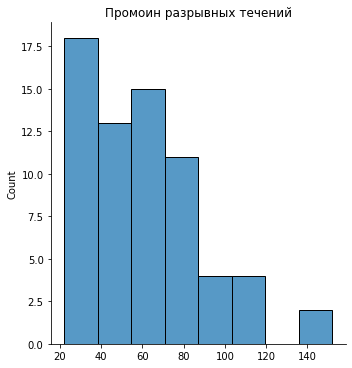

Минимальная длина: 13
Максимальная длина: 265
Медианная длина: 63.0


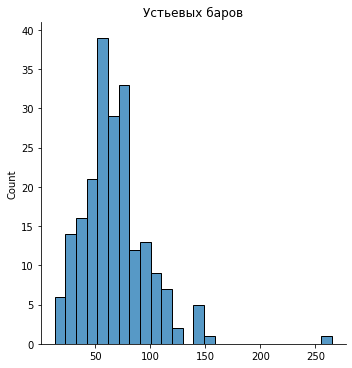

Минимальная длина: 11
Максимальная длина: 340
Медианная длина: 27.0


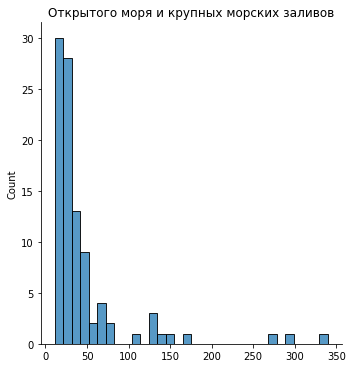

Минимальная длина: 17
Максимальная длина: 392
Медианная длина: 37.0


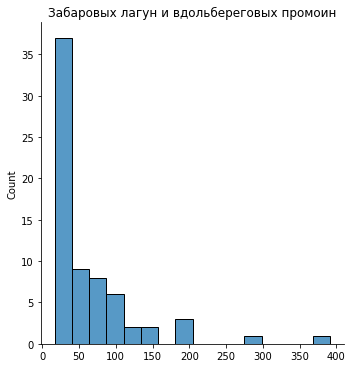

Минимальная длина: 16
Максимальная длина: 424
Медианная длина: 102.5


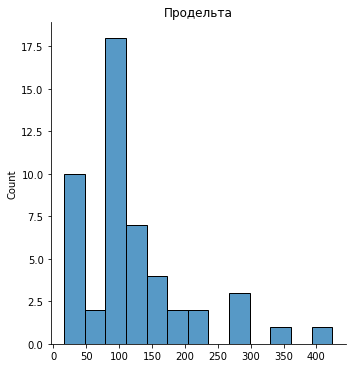

Минимальная длина: 59
Максимальная длина: 145
Медианная длина: 69.0


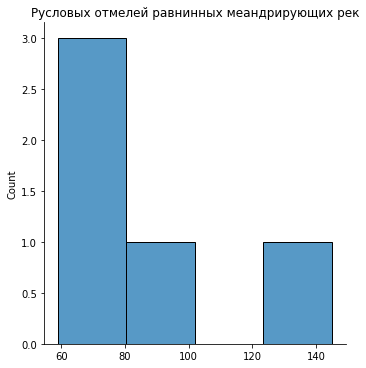

Минимальная длина: 54
Максимальная длина: 418
Медианная длина: 124.0


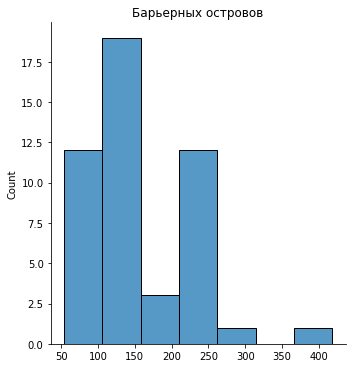

Минимальная длина: 15
Максимальная длина: 15
Медианная длина: 15.0


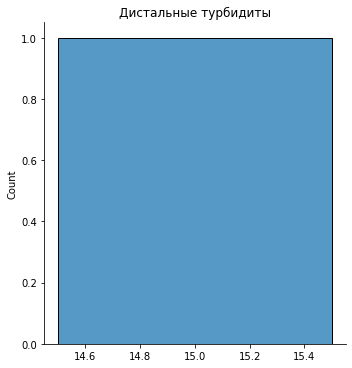

Минимальная длина: 28
Максимальная длина: 55
Медианная длина: 41.5


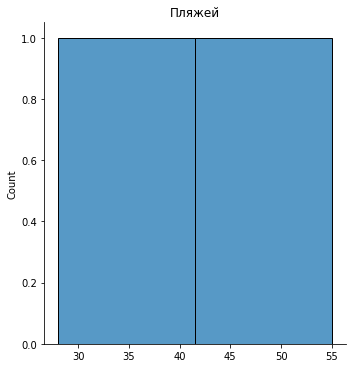

In [23]:
for pattern in expert_patterns:
    lengths = []
    
    for curve in expert_patterns[pattern]:
        lengths.append(len(curve))
        
    print("Минимальная длина:", min(lengths))
    print("Максимальная длина:", max(lengths))
    print("Медианная длина:", np.median(lengths))
        
    sns.displot(lengths)
    plt.title(pattern)
    plt.show()

Некоторые кривые содержат едва более десятка измерений. Это слишком мало, чтобы ещё больше их укорачивать. Создадим для них отдельный список аугментаций, а также определим, какие именно кривые мы считаем слишком короткими

In [27]:
SHORT_CURVES_THRESHOLD = 50  # Для более коротких кривых не будут применяться укорачивающие аугментации
N_AUGMENTED_CURVES = 1000  # Сколько получится кривых каждого вида 
N_AUGMENTATIONS = 5 # До стольки аугментаций будет применяться к каждой кривой

In [28]:
for pattern in expert_patterns:
    print(pattern)
    print(f"{len(expert_patterns[pattern])} кривых")
    print()

Промоин разрывных течений
67 кривых

Устьевых баров
208 кривых

Открытого моря и крупных морских заливов
98 кривых

Забаровых лагун и вдольбереговых промоин
69 кривых

Продельта
50 кривых

Русловых отмелей равнинных меандрирующих рек
5 кривых

Барьерных островов
48 кривых

Дистальные турбидиты
1 кривых

Пляжей
2 кривых



In [29]:
augmented_expert_patterns = defaultdict(list)

for pattern in tqdm(expert_patterns):
    
    for curve in tqdm(expert_patterns[pattern]):
        if len(curve) < SHORT_CURVES_THRESHOLD:
            augmentations_to_use = short_curves_augmentations
        else:
            augmentations_to_use = augmentations
        
        augmented_curves = generate_augmented_curves(
            curve,
            augmentations=augmentations_to_use,
            n_curves=N_AUGMENTED_CURVES // len(expert_patterns[pattern]),
            n_augmentations=np.random.randint(2, N_AUGMENTATIONS + 1),
            length_threshold=10
        )
        similar_curves = check_augmented_curves(curve, augmented_curves)
        augmented_expert_patterns[pattern].extend(similar_curves)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


  0%|          | 0/208 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [30]:
for pattern, curves in augmented_expert_patterns.items():
    print(pattern)
    print(len(curves))
    print()

Промоин разрывных течений
871

Устьевых баров
747

Открытого моря и крупных морских заливов
876

Забаровых лагун и вдольбереговых промоин
837

Продельта
864

Русловых отмелей равнинных меандрирующих рек
941

Барьерных островов
913

Дистальные турбидиты
776

Пляжей
971



In [31]:
augmented_expert_patterns_df = dict_to_pandas(augmented_expert_patterns, recode=True)
augmented_expert_patterns_df

UWI  Top Bottom Thickness ind_top ind_bot  \
0     NaN  NaN    NaN       NaN     NaN     NaN   
1     NaN  NaN    NaN       NaN     NaN     NaN   
2     NaN  NaN    NaN       NaN     NaN     NaN   
3     NaN  NaN    NaN       NaN     NaN     NaN   
4     NaN  NaN    NaN       NaN     NaN     NaN   
...   ...  ...    ...       ...     ...     ...   
7791  NaN  NaN    NaN       NaN     NaN     NaN   
7792  NaN  NaN    NaN       NaN     NaN     NaN   
7793  NaN  NaN    NaN       NaN     NaN     NaN   
7794  NaN  NaN    NaN       NaN     NaN     NaN   
7795  NaN  NaN    NaN       NaN     NaN     NaN   

                                                     sp dept   gr  code  Asp  \
0     [0.01, 0.0, 0.0, 0.0, 0.01, 0.01, 0.02, 0.63, ...  NaN  NaN    16  NaN   
1     [0.01, 0.0, 0.0, 0.01, 0.12, 0.18, 0.3, 0.55, ...  NaN  NaN    16  NaN   
2     [0.02, 0.11, 0.22, 0.71, 0.98, 1.0, 1.0, 1.0, ...  NaN  NaN    16  NaN   
3     [0.01, 0.01, 0.0, 0.0, 0.06, 0.17, 0.23, 0.43,...  NaN  NaN    16  NaN   
4     [0.01, 0.01, 0.0, 0.0, 0.0, 0.4, 0.46, 0.76, 0...  NaN  NaN    16  NaN   
...                                                 ...  ...  ...   ...  ...   
7791  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...  NaN  NaN    15  NaN   
7792  [0.93, 0.97, 0.98, 1.0, 1.0, 1.0, 0.99, 0.98, ...  NaN  NaN    15  NaN   
7793  [0.83, 0.86, 0.89, 0.89, 0.88, 0.86, 0.83, 0.7...  NaN  NaN    15  NaN   
7794  [0.93, 1.0, 1.0, 0.99, 0.96, 0.95, 0.84, 0.65,...  NaN  NaN    15  NaN   
7795  [0.93, 0.97, 1.0, 1.0, 0.69, 0.65, 0.58, 0.56,...  NaN  NaN    15  NaN   

      Agr UWI_uniq  
0     NaN      NaN  
1     NaN      NaN  
2     NaN      NaN  
3     NaN      NaN  
4     NaN      NaN  
...   ...      ...  
7791  NaN      NaN  
7792  NaN      NaN  
7793  NaN      NaN  
7794  NaN      NaN  
7795  NaN      NaN  

[7796 rows x 13 columns]

In [32]:
augmented_expert_patterns_df["code"].value_counts()

15    971
8     941
5     913
11    876
16    871
17    864
13    837
10    776
20    747
Name: code, dtype: int64

In [33]:
save_path = REAL_DATA_PATH / "expert_augmented"
save_path.mkdir(exist_ok=True)

with open(save_path / "augmented_filtered_expert_data.pkl", "wb") as f:
    pickle.dump(dict_to_pandas(augmented_expert_patterns, recode=True), f)

# Генерация данных для выделения границ фаций

In [17]:
df_path = Path("C:/Users/vladi/PycharmProjects/patterns_search/data/real/expert_selected/expert.pkl")

In [18]:
import pickle5 as pickle  # This file uses pickle protocol 5, so a simple pickle will cause an error

with open(df_path, "rb") as f:
    df = pickle.loads(f.read())

In [19]:
df

UWI   Top Bottom Thickness ind_top ind_bot  \
0     101P_y-kin pre_2  None   None      None    None    None   
1     101P_y-kin pre_3  None   None      None    None    None   
2     101P_y-kin pre_4  None   None      None    None    None   
3        105_unt pre_2  None   None      None    None    None   
4        107_unt pre_1  None   None      None    None    None   
...                ...   ...    ...       ...     ...     ...   
1475  92_sr-ugut pre_3  None   None      None    None    None   
1476  92_sr-ugut pre_4  None   None      None    None    None   
1477      9_ugut pre_1  None   None      None    None    None   
1478      9_ugut pre_2  None   None      None    None    None   
1479      9_ugut pre_3  None   None      None    None    None   

                                                     sp  \
0     [146.25, 146.625, 146.91000366, 147.17300415, ...   
1     [106.11799622, 105.375, 104.81300354, 103.8600...   
2     [135.11999512, 137.89500427, 139.13999939, 140...   
3     [139.05000305, 138.78900146, 138.63400269, 138...   
4     [113.917099, 113.74120331, 113.51339722, 113.2...   
...                                                 ...   
1475  [83.10269928, 82.309700012, 81.675300598, 81.6...   
1476  [102.29239655, 102.84750366, 103.40249634, 104...   
1477  [122.41000366, 122.41000366, 122.59999847, 122...   
1478  [119.12000275, 117.84999847, 117.72000122, 118...   
1479  [121.13999939, 123.11000061, 123.73999786, 122...   

                                                   dept  \
0     [2891.68, 2891.78, 2891.88, 2891.98, 2892.08, ...   
1     [2901.18, 2901.28, 2901.38, 2901.48, 2901.58, ...   
2     [2915.28, 2915.38, 2915.48, 2915.58, 2915.68, ...   
3     [2888.6, 2888.8, 2889.0, 2889.2, 2889.4, 2889....   
4     [2913.02, 2913.22, 2913.42, 2913.62, 2913.82, ...   
...                                                 ...   
1475  [2956.1, 2956.2, 2956.3, 2956.4, 2956.5, 2956....   
1476  [2961.6, 2961.7, 2961.8, 2961.9, 2962.0, 2962....   
1477  [2817.0, 2817.2, 2817.4, 2817.6, 2817.8, 2818....   
1478  [2819.8, 2820.0, 2820.2, 2820.4, 2820.6, 2820....   
1479  [2828.4, 2828.6, 2828.8, 2829.0, 2829.2, 2829....   

                                                     gr code  \
0     [14.472000122, 14.248999596, 14.510000229, 14....   16   
1     [2.7430000305, 2.6610000134, 2.5799999237, 2.5...   20   
2     [12.479999542, 13.137999535, 13.199000359, 13....  NaN   
3     [9.045999527, 9.3760004044, 9.5240001678, 9.57...   11   
4     [10.939889908, 9.3810997009, 8.3849496841, 9.0...  NaN   
...                                                 ...  ...   
1475  [7.428899765, 7.1371002197, 6.9340000153, 6.80...   15   
1476  [10.182700157, 10.201800346, 10.2208004, 10.33...   11   
1477  [9.2700004578, 8.9899997711, 8.2299995422, 8.4...  NaN   
1478  [8.4399995804, 8.5, 8.8599996567, 8.6400003433...   11   
1479  [10.119999886, 10.859999657, 10.390000343, 10....  NaN   

                                                    Asp  \
0     [0.06808442040224216, 0.06340142753994193, 0.0...   
1     [0.5692521197397042, 0.5785306423929739, 0.585...   
2     [0.20707570949666199, 0.1724214480506141, 0.15...   
3     [0.36326344942569744, 0.40985419506051546, 0.4...   
4     [0.0, 0.0953261050746228, 0.2187848849456947, ...   
...                                                 ...   
1475  [0.958713838019819, 0.981650594681903, 1.0, 1....   
1476  [0.40366992503975685, 0.38761397490556015, 0.3...   
1477  [0.10137154692887695, 0.10137154692887695, 0.0...   
1478  [0.35213390487307916, 0.44893304765873476, 0.4...   
1479  [0.1981706889523377, 0.048018100976258804, 0.0...   

                                                    Agr  
0     [0.04305140782568384, 0.06099624770555012, 0.0...  
1     [0.9868833905040784, 0.9934819273030715, 1.0, ...  
2     [0.20334758330959646, 0.15039836060086542, 0.1...  
3     [0.997477398343677, 0.9419777562537535, 0.9170...  
4     [0.4629327792260911, 0.704412115911483, 0.8587

In [20]:
df["code"][df["code"].isin([1, 2])] = 20

In [21]:
curves_counts = df["code"].value_counts()
curves_counts

20.0    313
11.0     98
4.0      71
13.0     69
16.0     67
17.0     50
5.0      48
18.0     19
7.0       8
8.0       5
15.0      2
12.0      1
10.0      1
Name: code, dtype: int64

Text(0, 0.5, 'Количество примеров')

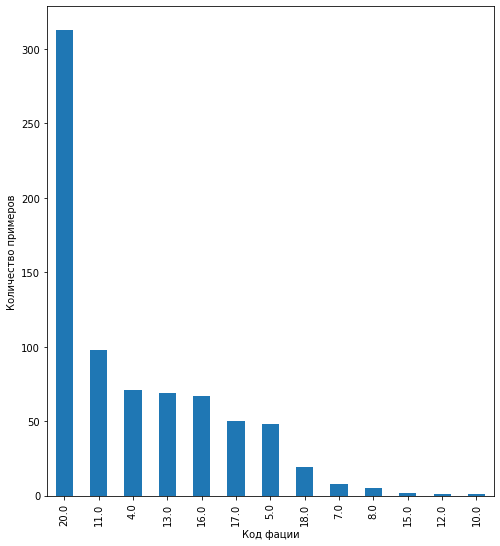

In [22]:
curves_counts.plot(kind="bar")
plt.xlabel("Код фации")
plt.ylabel("Количество примеров")

In [23]:
df = df.dropna(subset=["code"])
df["code"].unique()

array([16.0, 20.0, 11.0, 13.0, 17.0, 4.0, 7.0, 12.0, 8.0, 18.0, 5.0, 10.0,
       15.0], dtype=object)

In [24]:
bad_curves_df = pd.read_excel(
    "C:/Users/vladi/PycharmProjects/patterns_search/data/real/expert_selected/Валидация кривых.xlsx",
    engine="openpyxl",
)
bad_curves_df

Page
0      2
1      5
2      6
3      7
4      9
..   ...
92   639
93   643
94   646
95   703
96   716

[97 rows x 1 columns]

In [25]:
df = df[~df.index.isin(bad_curves_df["Page"])]

In [26]:
df["code"].value_counts()

20.0    286
11.0     93
13.0     67
16.0     65
4.0      64
17.0     50
5.0      47
18.0     19
7.0       8
8.0       5
15.0      2
12.0      1
10.0      1
Name: code, dtype: int64

In [27]:
train_df, test_df = train_test_split(df, test_size=.25)

In [62]:
df.to_pickle("C:/Users/vladi/PycharmProjects/patterns_search/data/real/expert_selected/expert_filtered.pkl")
train_df.to_pickle(
    "C:/Users/vladi/PycharmProjects/patterns_search/data/real/expert_selected/expert_filtered_train.pkl"
)
test_df.to_pickle(
    "C:/Users/vladi/PycharmProjects/patterns_search/data/real/expert_selected/expert_filtered_test.pkl"
)

In [28]:
@interact(idx=(0, df.shape[0], 1))
def show_curve_from_df(idx):
    try:
        curve = df.loc[idx]
        plot_well_log(
            depth=curve["dept"],
            sp=normalize(curve["sp"]), 
            title=patterns_codes_to_names[curve["code"]]
        )
        plt.show()
    except KeyError:
        print("Кривой с таким индексом не существует!")

interactive(children=(IntSlider(value=354, description='idx', max=708), Output()), _dom_classes=('widget-inter…

Посмотрим на распределение длин кривых

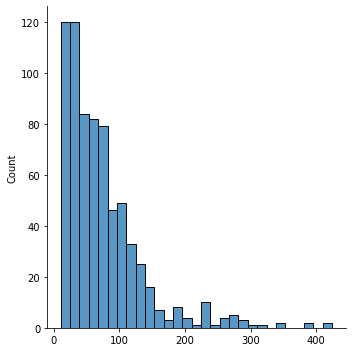

In [29]:
curves_lengths = np.array([len(curve) for curve in df["sp"]])

sns.displot(curves_lengths)

In [30]:
np.mean(curves_lengths < 30)

0.2344632768361582

23,5% кривых имеют длину меньше 30. Будем использовать для них отдельный набор аугментаций, который не уменьшает длину кривой

In [28]:
N_AUGMENTED_CURVES = 500
SHORT_CURVES_THRESHOLD = 30

In [29]:
codes_to_augmentate = train_df["code"].value_counts()
codes_to_augmentate = codes_to_augmentate[codes_to_augmentate > 10]
codes_to_augmentate

20.0    216
11.0     67
16.0     52
13.0     51
4.0      43
5.0      38
17.0     37
18.0     14
Name: code, dtype: int64

In [31]:
augmented_patterns = defaultdict(list)

for code in tqdm(codes_to_augmentate.index):
    code = int(code)
    curves_with_this_code = train_df[train_df["code"] == code]
    
    while len(augmented_patterns[code]) < N_AUGMENTED_CURVES:
        curve_idx = random.choice(curves_with_this_code.index)
        random_curve = curves_with_this_code.loc[curve_idx]
        
        if len(random_curve) < SHORT_CURVES_THRESHOLD:
            augmentations_to_use = short_curves_augmentations
        else:
            augmentations_to_use = augmentations
            
        normalized_curve = normalize(random_curve["sp"])
        
        augmented_curves = generate_augmented_curves(
            normalized_curve,
            augmentations=augmentations_to_use,
            n_curves=5,
            n_augmentations=np.random.randint(1, 5),
            length_threshold=10
        )
        similar_curves = check_augmented_curves(
            normalized_curve,
            augmented_curves,
            similarity_threshold=.65, 
            plot_similarities=False
        )
        
        augmented_patterns[code].extend(similar_curves)        

  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


In [32]:
print("Код", "Количество кривых", sep="\t")

for code, curves in augmented_patterns.items():
    print(code, len(curves), sep="\t")

Код	Количество кривых
20	501
11	502
16	500
13	504
4	500
5	500
17	500
18	500


In [33]:
codes = list(augmented_patterns.keys())

@interact(code_idx=(0, len(augmented_patterns), 1), augmentation_idx=(0, 500, 1))
def visualise_augmented_curves(code_idx, augmentation_idx):
    code = codes[code_idx]
    try:
        curve = augmented_patterns[code][augmentation_idx]
        plot_well_log(depth=np.arange(len(curve)), sp=curve, title=patterns_codes_to_names[code] + f" (code {code})")
    except (KeyError, IndexError):
        print("Кривые закончились!")

interactive(children=(IntSlider(value=4, description='code_idx', max=8), IntSlider(value=250, description='aug…

In [35]:
augmented_df = dict_to_pandas(augmented_patterns, recode=False)
augmented_df

UWI  Top Bottom Thickness ind_top ind_bot  \
0     NaN  NaN    NaN       NaN     NaN     NaN   
1     NaN  NaN    NaN       NaN     NaN     NaN   
2     NaN  NaN    NaN       NaN     NaN     NaN   
3     NaN  NaN    NaN       NaN     NaN     NaN   
4     NaN  NaN    NaN       NaN     NaN     NaN   
...   ...  ...    ...       ...     ...     ...   
4002  NaN  NaN    NaN       NaN     NaN     NaN   
4003  NaN  NaN    NaN       NaN     NaN     NaN   
4004  NaN  NaN    NaN       NaN     NaN     NaN   
4005  NaN  NaN    NaN       NaN     NaN     NaN   
4006  NaN  NaN    NaN       NaN     NaN     NaN   

                                                     sp dept   gr  code  Asp  \
0     [0.88, 0.88, 0.89, 0.9, 0.9, 0.9, 0.91, 0.91, ...  NaN  NaN    20  NaN   
1     [0.98, 0.99, 0.99, 0.99, 1.0, 1.0, 1.0, 1.0, 1...  NaN  NaN    20  NaN   
2     [0.88, 0.88, 0.88, 0.89, 0.89, 0.9, 0.91, 0.92...  NaN  NaN    20  NaN   
3     [0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.96...  NaN  NaN    20  NaN   
4     [0.85, 0.86, 0.87, 0.87, 0.88, 0.89, 0.9, 0.91...  NaN  NaN    20  NaN   
...                                                 ...  ...  ...   ...  ...   
4002  [1.0, 0.87, 0.75, 0.62, 0.5, 0.43, 0.37, 0.3, ...  NaN  NaN    18  NaN   
4003  [1.0, 0.5, 0.37, 0.23, 0.12, 0.0, 0.11, 0.21, ...  NaN  NaN    18  NaN   
4004  [1.0, 0.5, 0.23, 0.12, 0.0, 0.11, 0.21, 0.33, ...  NaN  NaN    18  NaN   
4005  [1.0, 0.5, 0.23, 0.0, 0.11, 0.21, 0.27, 0.33, ...  NaN  NaN    18  NaN   
4006  [1.0, 0.51, 0.24, 0.0, 0.22, 0.34, 0.18, 0.37,...  NaN  NaN    18  NaN   

      Agr UWI_uniq  
0     NaN      NaN  
1     NaN      NaN  
2     NaN      NaN  
3     NaN      NaN  
4     NaN      NaN  
...   ...      ...  
4002  NaN      NaN  
4003  NaN      NaN  
4004  NaN      NaN  
4005  NaN      NaN  
4006  NaN      NaN  

[4007 rows x 13 columns]

In [80]:
augmented_df["code"].value_counts()

13    503
20    503
18    503
11    502
17    500
5     500
16    500
4     500
Name: code, dtype: int64

In [81]:
augmented_df.to_pickle(
    "C:/Users/vladi/PycharmProjects/patterns_search/data/real/expert_selected/augmented_filtered_expert_data.pkl"
)

In [14]:
augmented_df = pd.read_pickle(
    "C:/Users/vladi/PycharmProjects/patterns_search/data/real/expert_selected/augmented_filtered_expert_data.pkl"
)
augmented_df

UWI  Top Bottom Thickness ind_top ind_bot  \
0     NaN  NaN    NaN       NaN     NaN     NaN   
1     NaN  NaN    NaN       NaN     NaN     NaN   
2     NaN  NaN    NaN       NaN     NaN     NaN   
3     NaN  NaN    NaN       NaN     NaN     NaN   
4     NaN  NaN    NaN       NaN     NaN     NaN   
...   ...  ...    ...       ...     ...     ...   
4006  NaN  NaN    NaN       NaN     NaN     NaN   
4007  NaN  NaN    NaN       NaN     NaN     NaN   
4008  NaN  NaN    NaN       NaN     NaN     NaN   
4009  NaN  NaN    NaN       NaN     NaN     NaN   
4010  NaN  NaN    NaN       NaN     NaN     NaN   

                                                     sp dept   gr  code  Asp  \
0     [0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...  NaN  NaN    20  NaN   
1     [0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0....  NaN  NaN    20  NaN   
2     [0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...  NaN  NaN    20  NaN   
3     [0.01, 0.0, 0.0, 0.0, 0.0, 0.01, 0.03, 0.03, 0...  NaN  NaN    20  NaN   
4     [0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...  NaN  NaN    20  NaN   
...                                                 ...  ...  ...   ...  ...   
4006  [0.83, 0.85, 0.86, 0.86, 0.86, 0.85, 0.85, 0.8...  NaN  NaN    18  NaN   
4007  [0.98, 1.0, 1.0, 0.99, 0.96, 0.95, 0.92, 0.87,...  NaN  NaN    18  NaN   
4008  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98,...  NaN  NaN    18  NaN   
4009  [0.83, 0.84, 0.86, 0.86, 0.85, 0.83, 0.82, 0.8...  NaN  NaN    18  NaN   
4010  [0.99, 1.0, 1.0, 1.0, 1.0, 0.97, 0.97, 0.96, 0...  NaN  NaN    18  NaN   

      Agr UWI_uniq  
0     NaN      NaN  
1     NaN      NaN  
2     NaN      NaN  
3     NaN      NaN  
4     NaN      NaN  
...   ...      ...  
4006  NaN      NaN  
4007  NaN      NaN  
4008  NaN      NaN  
4009  NaN      NaN  
4010  NaN      NaN  

[4011 rows x 13 columns]

In [112]:
curve, codes = curves_sequence(
    curves=augmented_df["sp"].to_numpy(),
    codes=augmented_df["code"].to_numpy(),
    n_curves_to_stack=3,
    n_points_in_between=20
)

<AxesSubplot:>

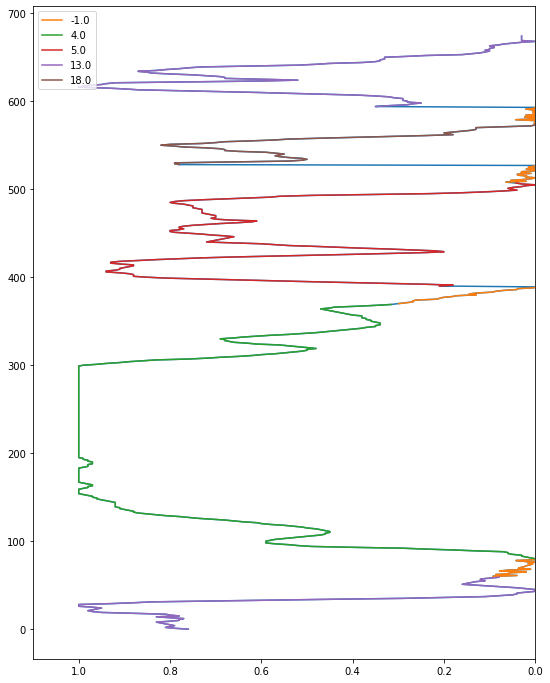

In [117]:
plt.figure(figsize=(9, 12))
plot_curves_stack(curve, codes)

In [44]:
N_STACKS = 100

cols = ['UWI', 'Top', 'Bottom', 'Thickness', 'ind_top', 'ind_bot',
            'sp', 'dept', 'gr', 'code', 'Asp', 'Agr', 'UWI_uniq']

stacks_dict = defaultdict(list)

for _ in range(N_STACKS):
    n_curves_to_stack = np.random.randint(2, 6)
    
    curve, codes = curves_sequence(
        curves=augmented_df["sp"].to_numpy(),
        codes=augmented_df["code"].to_numpy(),
        n_curves_to_stack=n_curves_to_stack
    )
    
    stacks_dict["sp"].append(curve)
    stacks_dict["code"].append(codes)
    
stacks_df = pd.DataFrame(stacks_dict, columns=cols)

In [46]:
stacks_df

UWI  Top Bottom Thickness ind_top ind_bot  \
0   NaN  NaN    NaN       NaN     NaN     NaN   
1   NaN  NaN    NaN       NaN     NaN     NaN   
2   NaN  NaN    NaN       NaN     NaN     NaN   
3   NaN  NaN    NaN       NaN     NaN     NaN   
4   NaN  NaN    NaN       NaN     NaN     NaN   
..  ...  ...    ...       ...     ...     ...   
95  NaN  NaN    NaN       NaN     NaN     NaN   
96  NaN  NaN    NaN       NaN     NaN     NaN   
97  NaN  NaN    NaN       NaN     NaN     NaN   
98  NaN  NaN    NaN       NaN     NaN     NaN   
99  NaN  NaN    NaN       NaN     NaN     NaN   

                                                   sp dept   gr  \
0   [0.95, 0.97, 0.98, 0.99, 1.0, 1.0, 1.0, 1.0, 1...  NaN  NaN   
1   [0.11, 0.06, 0.0, 0.0, 0.0, 0.03, 0.05, 0.08, ...  NaN  NaN   
2   [0.81, 0.82, 0.83, 0.83, 0.83, 0.83, 0.83, 0.8...  NaN  NaN   
3   [0.47, 0.6, 0.75, 0.88, 0.92, 1.0, 1.0, 1.0, 1...  NaN  NaN   
4   [0.0, 0.07, 0.11, 0.14, 0.18, 0.21, 0.25, 0.29...  NaN  NaN   
..                                                ...  ...  ...   
95  [0.0, 0.06, 0.12, 0.16, 0.19, 0.21, 0.24, 0.26...  NaN  NaN   
96  [0.0, 0.07, 0.14, 0.16, 0.19, 0.21, 0.24, 0.25...  NaN  NaN   
97  [0.04, 0.02, 0.01, 0.01, 0.0, 0.03, 0.07, 0.11...  NaN  NaN   
98  [0.91, 0.94, 0.95, 0.97, 0.97, 0.98, 0.99, 1.0...  NaN  NaN   
99  [0.0, 0.11, 0.22, 0.33, 0.45, 0.53, 0.62, 0.72...  NaN  NaN   

                                                 code  Asp  Agr UWI_uniq  
0   [18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18....  NaN  NaN      NaN  
1   [11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11....  NaN  NaN      NaN  
2   [4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, ...  NaN  NaN      NaN  
3   [11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11....  NaN  NaN      NaN  
4   [16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16....  NaN  NaN      NaN  
..                                                ...  ...  ...      ...  
95  [18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18....  NaN  NaN      NaN  
96  [16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16....  NaN  NaN      NaN  
97  [18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18....  NaN  NaN      NaN  
98  [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...  NaN  NaN      NaN  
99  [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...  NaN  NaN      NaN  

[100 rows x 13 columns]

In [56]:
@interact(curve_idx=(0, N_STACKS, 1))
def show_curve(curve_idx):
    import warnings
    import matplotlib
    warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
    row = stacks_df.loc[curve_idx]
    plot_curves_stack(curve=row["sp"], codes=row["code"])

interactive(children=(IntSlider(value=50, description='curve_idx'), Output()), _dom_classes=('widget-interact'…

In [57]:
stacks_df.to_pickle(
    "C:/Users/vladi/PycharmProjects/patterns_search/data/real/expert_selected/stacked_auugmented_curves.pkl"
)

# Аугментация реальных данных

In [17]:
df = pd.read_pickle('C:/Users/vladi/PycharmProjects/patterns_search/data/real/data_экспертные_фации.pkl')

In [18]:
df = df[~df['code'].isin([-1, 10, 12, 15, 8, 7])]

In [19]:
df.head()

UWI   Top Bottom Thickness ind_top ind_bot  \
0  101P_y-kin pre_2  None   None      None    None    None   
1  101P_y-kin pre_3  None   None      None    None    None   
3     105_unt pre_2  None   None      None    None    None   
6   108PL_chi pre_2  None   None      None    None    None   
8    10PL_chi pre_2  None   None      None    None    None   

                                                  sp  \
0  [146.25, 146.625, 146.91000366, 147.17300415, ...   
1  [106.11799622, 105.375, 104.81300354, 103.8600...   
3  [139.05000305, 138.78900146, 138.63400269, 138...   
6  [155.96379089, 156.17610168, 156.42930603, 156...   
8  [27.163000107, 26.906999588, 26.662000656, 26....   

                                                dept  \
0  [2891.68, 2891.78, 2891.88, 2891.98, 2892.08, ...   
1  [2901.18, 2901.28, 2901.38, 2901.48, 2901.58, ...   
3  [2888.6, 2888.8, 2889.0, 2889.2, 2889.4, 2889....   
6  [3093.6, 3093.8, 3094.0, 3094.2, 3094.4, 3094....   
8  [2896.0, 2896.2, 2896.4, 2896.6, 2896.8, 2897....   

                                                  gr code  \
0  [14.472000122, 14.248999596, 14.510000229, 14....   16   
1  [2.7430000305, 2.6610000134, 2.5799999237, 2.5...   20   
3  [9.045999527, 9.3760004044, 9.5240001678, 9.57...   11   
6  [14.228699684, 13.665599823, 13.370699883, 13....   20   
8  [8.018699646, 8.309800148, 8.309800148, 7.9054...   13   

                                                 Asp  \
0  [0.06808442040224216, 0.06340142753994193, 0.0...   
1  [0.5692521197397042, 0.5785306423929739, 0.585...   
3  [0.36326344942569744, 0.40985419506051546, 0.4...   
6  [0.3145440587829408, 0.31131245607402225, 0.30...   
8  [0.2502974861821776, 0.2648042303573567, 0.278...   

                                                 Agr    UWI_uniq  
0  [0.04305140782568384, 0.06099624770555012, 0.0...  101P_y-kin  
1  [0.9868833905040784, 0.9934819273030715, 1.0, ...  101P_y-kin  
3  [0.997477398343677, 0.9419777562537535, 0.9170...     105_unt  
6  [0.43116708813483595, 0.48066558775004486, 0.5...   108PL_chi  
8  [0.5145755748537768, 0.463670526450796, 0.4636...    10PL_chi

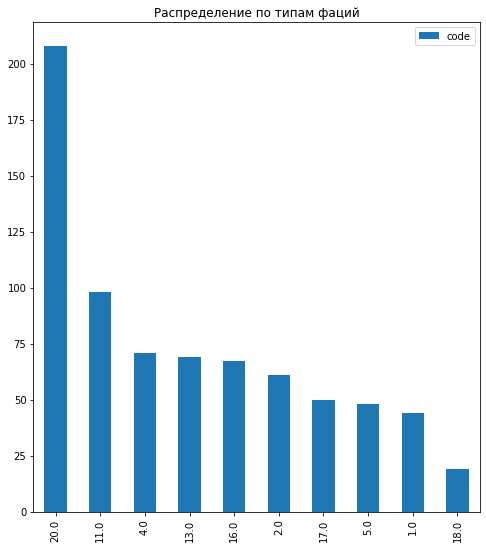

In [20]:
df['code'].value_counts().plot(kind='bar', label='code')
plt.legend()
plt.title('Распределение по типам фаций');

In [21]:
from sklearn.model_selection import train_test_split
X = df[['UWI', 'Asp']]
Y = df['code']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state=42)#, stratifyarray =Y)

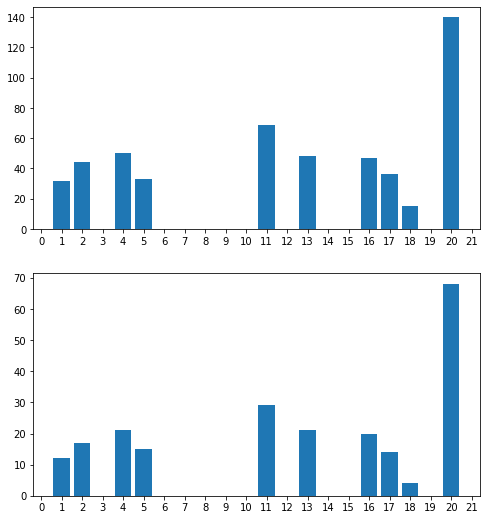

In [24]:
import matplotlib.ticker as ticker
(label_train, count_train) = np.unique(Y_train, return_counts =True)
(label_test, count_test) = np.unique(Y_test, return_counts =True)
fig, ax = plt.subplots(2,1)
ax[0].bar(label_train, count_train)
ax[1].bar(label_test, count_test)
ax[0].xaxis.set_major_locator(ticker.MultipleLocator(1))
ax[1].xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.show()

In [25]:
z = count_train[np.where(label_train==20.0)[0]][0]
N_AUGMENTATIONS = (500-z)//z
N_AUGMENTATIONS

2

In [26]:
Y_train[1]

20.0

In [27]:
# for real data

df = X_test
target = Y_test
count = count_test
label = label_test
N = 300

df_aug = pd.DataFrame(columns = ['UWI', 'Top', 'Bottom', 'Thickness', 'ind_top', 'ind_bot', 'sp', 'dept', 'gr', 'code',  'aug', 'label'])
for index, row in df.iterrows():
    
    df = pd.DataFrame(columns = ['UWI', 'Top', 'Bottom', 'Thickness', 'ind_top', 'ind_bot', 'sp', 'dept', 'gr', 'code',  'aug', 'label'])
    X = row.copy().values
    pattern = X[1]
    #print(pattern)
    pattern_ID = target[index]

    z = count[np.where(label==pattern_ID)[0]][0]
    N_AUGMENTATIONS = (N-z)//z
    #print(N_AUGMENTATIONS)
            
    augmented_curves = generate_augmented_curves(pattern, augmentations, n_augmentations=1, n_curves=N_AUGMENTATIONS)
    #print(augmented_curves)
    similar_curves = check_augmented_curves(pattern, augmented_curves)
    for i in range(len(similar_curves)):
        l = len(similar_curves[i])
        UWI = X[0]+'_'+str(pattern_ID)+'_'+str(i)
        Top = 0
        Bottom = l*0.1
        sp = similar_curves[i]
        dept = np.array([round(x*0.1,1) for x in range(l)])
        code = np.array([pattern_ID for i in range(l)])

        df.loc[i] = [UWI, Top, Bottom, Bottom, 0, 0, sp, dept, sp, code, False, pattern_ID]
        if i == len(similar_curves)-1:
            l = len(pattern)
            sp = pattern
            dept = np.array([round(x*0.1,1) for x in range(l)])
            code = np.array([pattern_ID for i in range(l)])
            df.loc[i+1] = [X[0]+'_'+str(pattern_ID)+'_'+str(i+1), Top, Bottom, Bottom, 0, 0, sp, dept, sp, code, True, pattern_ID]

    df_aug = df_aug.append(df, ignore_index=True)

C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


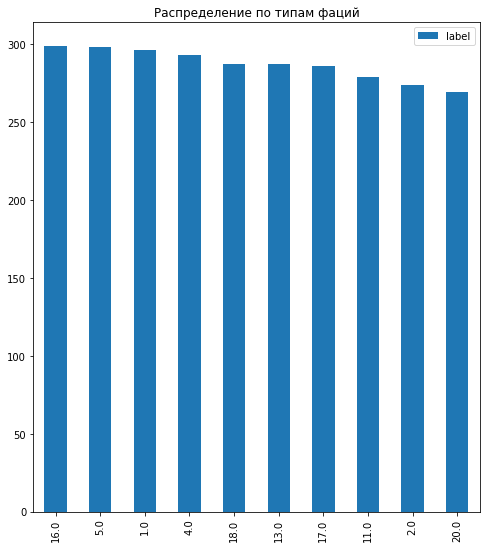

In [28]:
df_aug['label'].value_counts().plot(kind='bar', label='label')
plt.legend()
plt.title('Распределение по типам фаций');

In [ ]:
df_aug.to_pickle('/content/drive/My Drive/HW/expert_aug_test.pkl')

In [ ]:
df2 = pd.read_pickle('/content/drive/My Drive/HW/expert_aug_train.pkl')
df2.info()

# Генерация последовательностей из чистых кривых

In [17]:
CLEAN_DATA_PATH = Path("C:/Users/vladi/PycharmProjects/patterns_search/data/real/clean")

In [23]:
df = pd.read_pickle(CLEAN_DATA_PATH / "real_data_aug.pkl")
print(df.shape)
df.head()

(4889, 12)


UWI Top  Bottom  Thickness ind_top ind_bot  \
0  265P_y-kin_5_0   0    10.8       10.8       0       0   
1  265P_y-kin_5_1   0     9.8        9.8       0       0   
2  265P_y-kin_5_2   0    40.0       40.0       0       0   
3  265P_y-kin_5_3   0    15.3       15.3       0       0   
4  265P_y-kin_5_4   0    13.8       13.8       0       0   

                                                  sp  \
0  [0.624737685136959, 0.6717851800348617, 0.6938...   
1  [0.7159046521815391, 0.7518847662736236, 0.773...   
2  [0.4786146591122119, 0.5033834979129201, 0.528...   
3  [0.4786146591122119, 0.5281523367136285, 0.577...   
4  [0.4786146591122119, 0.5281523367136285, 0.577...   

                                                dept  \
0  [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, ...   
1  [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, ...   
2  [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, ...   
3  [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, ...   
4  [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, ...   

                                                  gr  \
0  [0.624737685136959, 0.6717851800348617, 0.6938...   
1  [0.7159046521815391, 0.7518847662736236, 0.773...   
2  [0.4786146591122119, 0.5033834979129201, 0.528...   
3  [0.4786146591122119, 0.5281523367136285, 0.577...   
4  [0.4786146591122119, 0.5281523367136285, 0.577...   

                                                code   aug label  
0  [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...  True     5  
1  [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...  True     5  
2  [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...  True     5  
3  [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...  True     5  
4  [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...  True     5

In [54]:
N_STACKS = 2000

cols = ['UWI', 'Top', 'Bottom', 'Thickness', 'ind_top', 'ind_bot',
            'sp', 'dept', 'gr', 'code', 'Asp', 'Agr', 'UWI_uniq']

stacks_dict = defaultdict(list)

for _ in range(N_STACKS):
    n_curves_to_stack = np.random.randint(3, 6)
    
    curve, codes = curves_sequence(
        curves=df["sp"].to_numpy(),
        codes=df["code"].to_numpy(),
        n_curves_to_stack=n_curves_to_stack,
        n_points_in_between=np.random.randint(5, 50)
    )
    
    stacks_dict["sp"].append(curve)
    stacks_dict["code"].append(codes)
    
stacks_df = pd.DataFrame(stacks_dict, columns=cols)

In [67]:
stacks_df.to_pickle(CLEAN_DATA_PATH / "augmented_clean_sequences.pkl")

In [55]:
@interact(idx=(0, N_STACKS, 1))
def show_curves_stack(idx):
    codes = stacks_df["code"][idx]
    curve = stacks_df["sp"][idx]
    
    plot_curves_stack(curve, codes)

interactive(children=(IntSlider(value=1000, description='idx', max=2000), Output()), _dom_classes=('widget-int…

In [58]:
@interact(idx=(0, df.shape[0], 1))
def show_curve(idx):
    codes = df["code"][idx]
    curve = df["sp"][idx]
    
    plot_curves_stack(curve, codes)

interactive(children=(IntSlider(value=2444, description='idx', max=4889), Output()), _dom_classes=('widget-int…

# Аугментация каротажей

In [13]:
DF_PATH = Path("C:/Users/vladi/PycharmProjects/patterns_search/data/carotages/train.csv")

In [14]:
df = pd.read_csv(DF_PATH, sep=";")
df

WELL   DEPTH_MD         X_LOC      Y_LOC       Z_LOC  \
0        15/9-13   494.5280  437641.96875  6470972.5 -469.501831   
1        15/9-13   494.6800  437641.96875  6470972.5 -469.653809   
2        15/9-13   494.8320  437641.96875  6470972.5 -469.805786   
3        15/9-13   494.9840  437641.96875  6470972.5 -469.957794   
4        15/9-13   495.1360  437641.96875  6470972.5 -470.109772   
...          ...        ...           ...        ...         ...   
1170506  7/1-2 S  3169.3124           NaN        NaN         NaN   
1170507  7/1-2 S  3169.4644           NaN        NaN         NaN   
1170508  7/1-2 S  3169.6164           NaN        NaN         NaN   
1170509  7/1-2 S  3169.7684           NaN        NaN         NaN   
1170510  7/1-2 S  3169.9204           NaN        NaN         NaN   

                GROUP  FORMATION       CALI  RSHA      RMED  ...        ROP  \
0        NORDLAND GP.        NaN  19.480835   NaN  1.611410  ...  34.636410   
1        NORDLAND GP.        NaN  19.468800   NaN  1.618070  ...  34.636410   
2        NORDLAND GP.        NaN  19.468800   NaN  1.626459  ...  34.779556   
3        NORDLAND GP.        NaN  19.459282   NaN  1.621594  ...  39.965164   
4        NORDLAND GP.        NaN  19.453100   NaN  1.602679  ...  57.483765   
...               ...        ...        ...   ...       ...  ...        ...   
1170506  VESTLAND GP.  Bryne Fm.   8.423170   NaN       NaN  ...  27.674368   
1170507  VESTLAND GP.  Bryne Fm.   8.379244   NaN       NaN  ...  28.024338   
1170508  VESTLAND GP.  Bryne Fm.   8.350248   NaN       NaN  ...  28.091282   
1170509  VESTLAND GP.  Bryne Fm.   8.313779   NaN       NaN  ...  28.019775   
1170510  VESTLAND GP.  Bryne Fm.   8.294910   NaN       NaN  ...  25.985943   

         DTS  DCAL      DRHO  MUDWEIGHT  RMIC       ROPA  RXO  \
0        NaN   NaN -0.574928        NaN   NaN        NaN  NaN   
1        NaN   NaN -0.570188        NaN   NaN        NaN  NaN   
2        NaN   NaN -0.574245        NaN   NaN        NaN  NaN   
3        NaN   NaN -0.586315        NaN   NaN        NaN  NaN   
4        NaN   NaN -0.597914        NaN   NaN        NaN  NaN   
...      ...   ...       ...        ...   ...        ...  ...   
1170506  NaN   NaN -0.001763        NaN   NaN  26.673708  NaN   
1170507  NaN   NaN -0.007600        NaN   NaN  26.840818  NaN   
1170508  NaN   NaN -0.018297        NaN   NaN  27.007942  NaN   
1170509  NaN   NaN -0.011438        NaN   NaN  27.175179  NaN   
1170510  NaN   NaN -0.011398        NaN   NaN  27.342442  NaN   

         FORCE_2020_LITHOFACIES_LITHOLOGY  FORCE_2020_LITHOFACIES_CONFIDENCE  
0                                   65000                                1.0  
1                                   65000                                1.0  
2                                   65000                                1.0  
3                                   65000                                1.0  
4                                   65000                                1.0  
...                                   ...                                ...  
1170506                             30000                                2.0  
1170507                             65030                                2.0  
1170508                             65030                                2.0  
1170509                             65030                                2.0  
1170510                             65030                                2.0  

[1170511 rows x 29 columns]

In [15]:
df.columns

Index(['WELL', 'DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'GROUP', 'FORMATION',
       'CALI', 'RSHA', 'RMED', 'RDEP', 'RHOB', 'GR', 'SGR', 'NPHI', 'PEF',
       'DTC', 'SP', 'BS', 'ROP', 'DTS', 'DCAL', 'DRHO', 'MUDWEIGHT', 'RMIC',
       'ROPA', 'RXO', 'FORCE_2020_LITHOFACIES_LITHOLOGY',
       'FORCE_2020_LITHOFACIES_CONFIDENCE'],
      dtype='object')

In [16]:
df["WELL"].value_counts()

25/2-7      25131
29/6-1      24464
25/7-2      23879
35/11-6     23544
34/2-4      23403
            ...  
25/11-15     2284
34/5-1 S     2273
34/3-1 A     2251
7/1-2 S      2040
16/1-2       1734
Name: WELL, Length: 98, dtype: int64

In [17]:
wells = df["WELL"].unique()
wells

array(['15/9-13', '15/9-15', '15/9-17', '16/1-2', '16/1-6 A', '16/10-1',
       '16/10-2', '16/10-3', '16/10-5', '16/11-1 ST3', '16/2-11 A',
       '16/2-16', '16/2-6', '16/4-1', '16/5-3', '16/7-4', '16/7-5',
       '16/8-1', '17/11-1', '25/11-15', '25/11-19 S', '25/11-5',
       '25/2-13 T4', '25/2-14', '25/2-7', '25/3-1', '25/4-5', '25/5-1',
       '25/5-4', '25/6-1', '25/6-2', '25/6-3', '25/7-2', '25/8-5 S',
       '25/8-7', '25/9-1', '26/4-1', '29/6-1', '30/3-3', '30/3-5 S',
       '30/6-5', '31/2-1', '31/2-19 S', '31/2-7', '31/2-8', '31/2-9',
       '31/3-1', '31/3-2', '31/3-3', '31/3-4', '31/4-10', '31/4-5',
       '31/5-4 S', '31/6-5', '31/6-8', '32/2-1', '33/5-2', '33/6-3 S',
       '33/9-1', '33/9-17', '34/10-19', '34/10-21', '34/10-33',
       '34/10-35', '34/11-1', '34/11-2 S', '34/12-1', '34/2-4',
       '34/3-1 A', '34/4-10 R', '34/5-1 A', '34/5-1 S', '34/7-13',
       '34/7-20', '34/7-21', '34/8-1', '34/8-3', '34/8-7 R', '35/11-1',
       '35/11-10', '35/11-11', '35/11-12

In [24]:
from sklearn.preprocessing import MinMaxScaler

In [25]:
wells_sp = defaultdict(dict)

print(f"Wells before: {len(wells)}")
scaler = MinMaxScaler()

for well in wells:
    well_carotage = df[df["WELL"] == well]
    
    if well_carotage["SP"].isna().sum():
        wells_sp[well]["depth"] = well_carotage["DEPTH_MD"]
        wells_sp[well]["sp"] = 1 - scaler.fit_transform(well_carotage["SP"].to_numpy().reshape(-1, 1)).flatten()
        
wells = list(wells_sp.keys())

print(f"Wells after: {len(wells)}")

Wells before: 56


C:\Users\vladi\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:373: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\vladi\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:374: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\vladi\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:373: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\vladi\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:374: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\vladi\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:373: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\vladi\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:374: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\vladi\Anaconda3\lib\site-packages\sklearn\preprocessing\_data

Wells after: 56


C:\Users\vladi\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:373: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\vladi\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:374: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


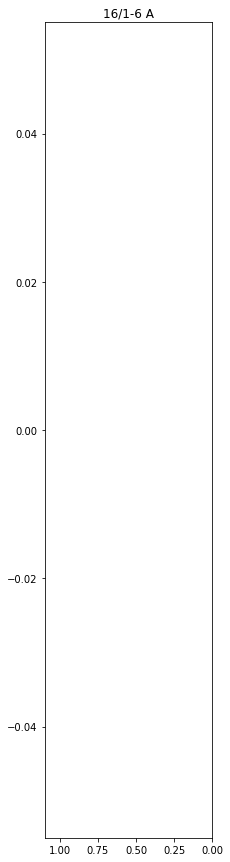

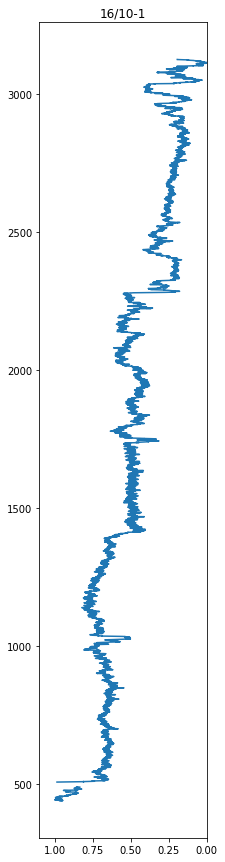

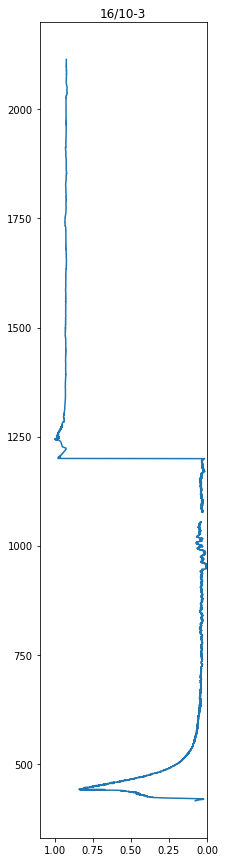

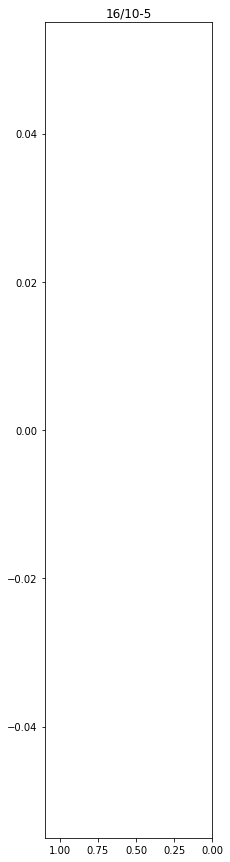

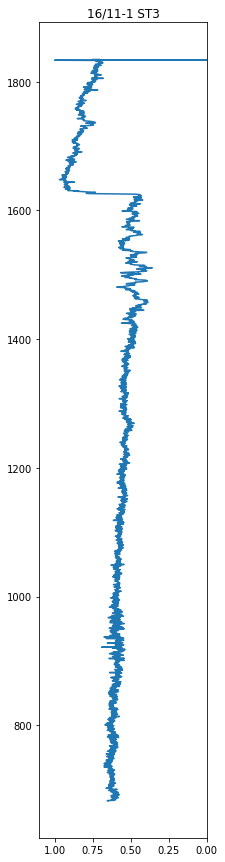

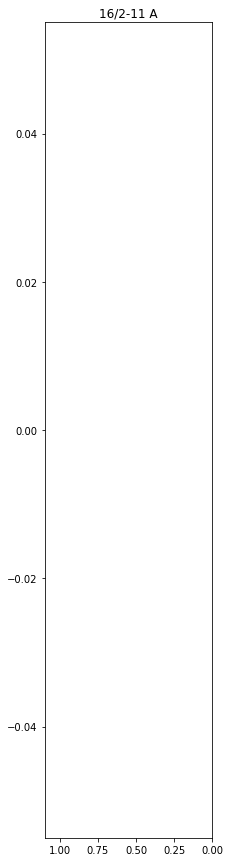

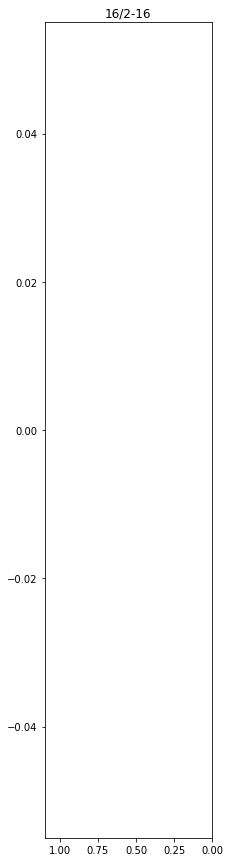

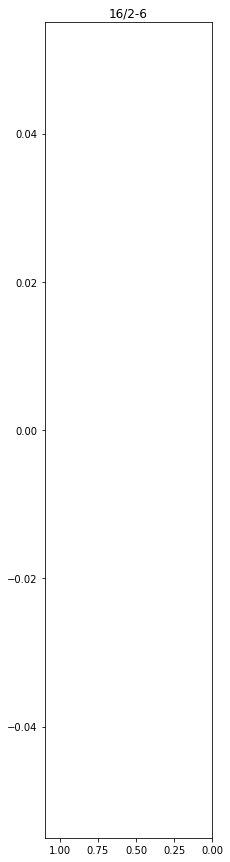

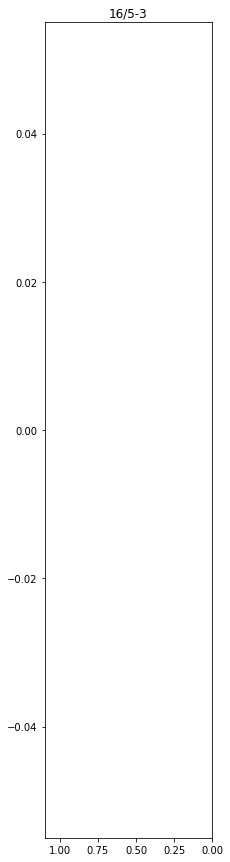

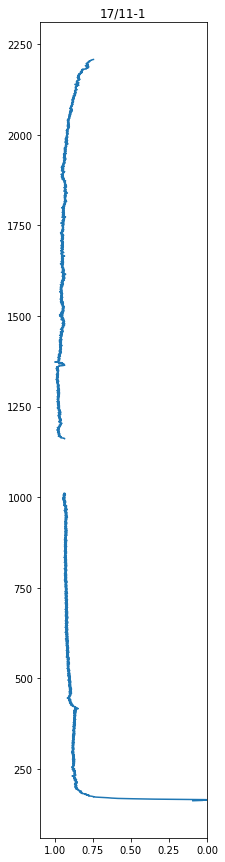

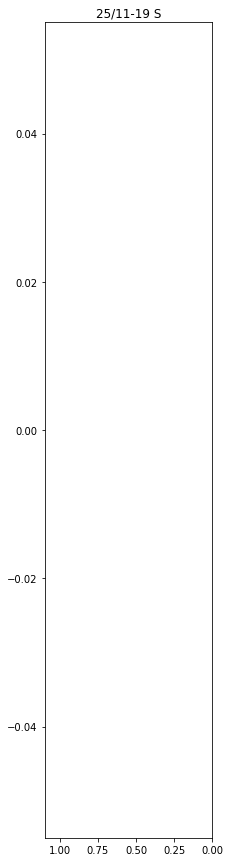

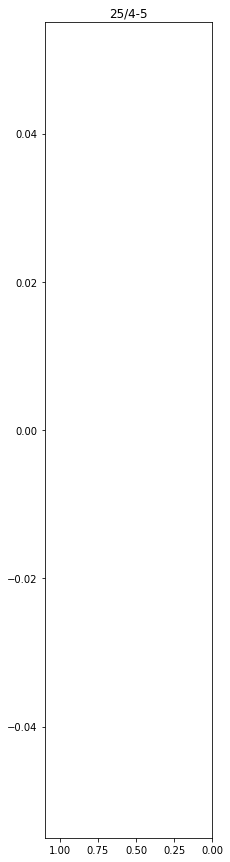

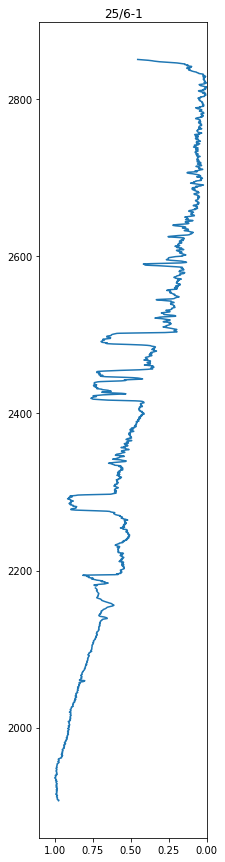

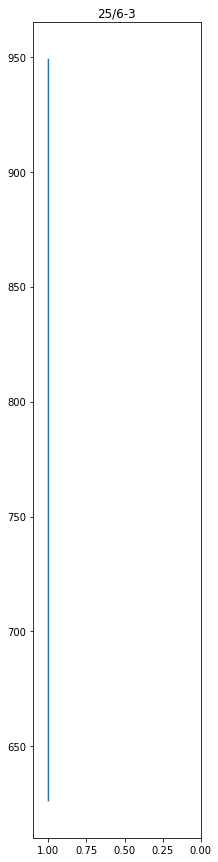

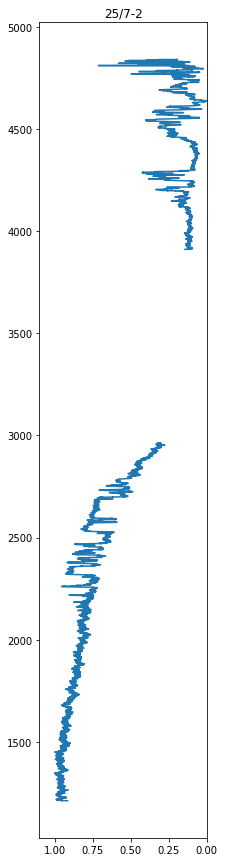

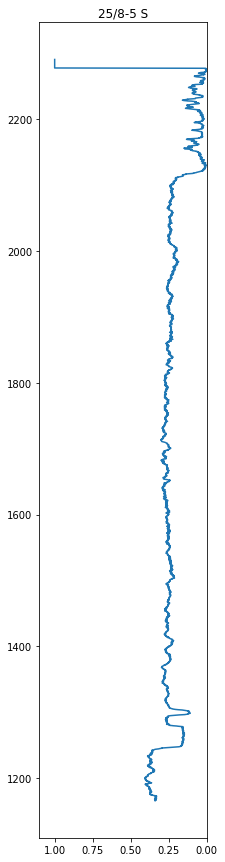

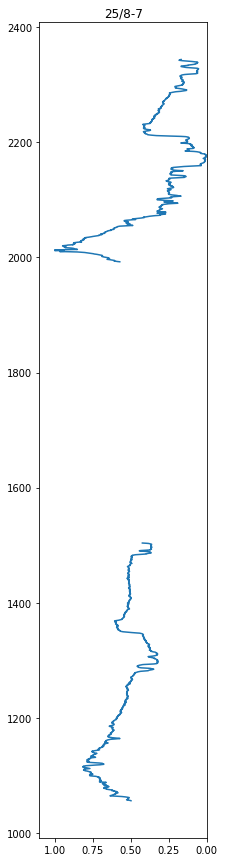

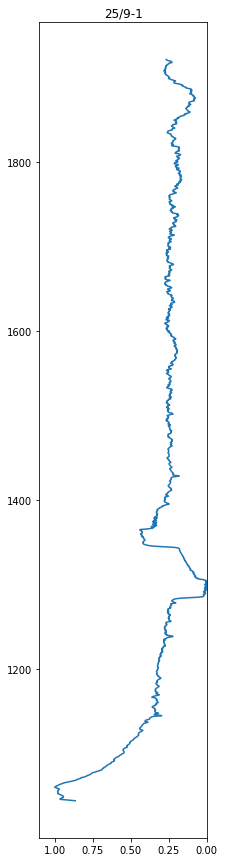

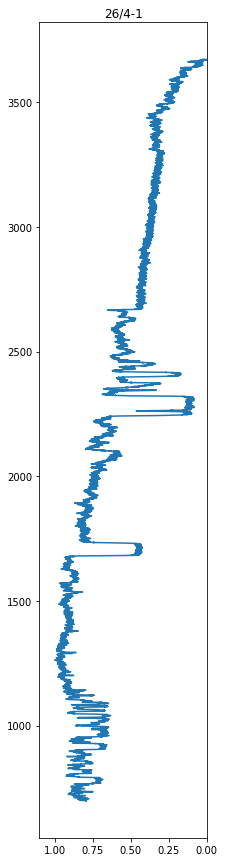

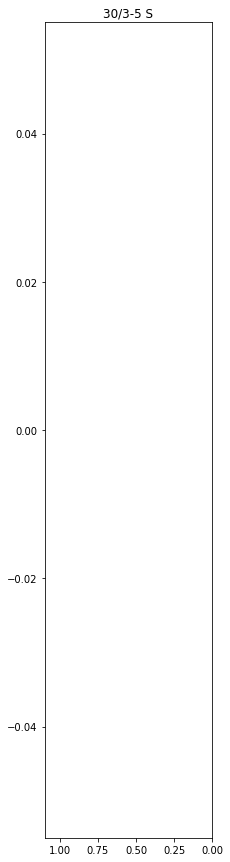

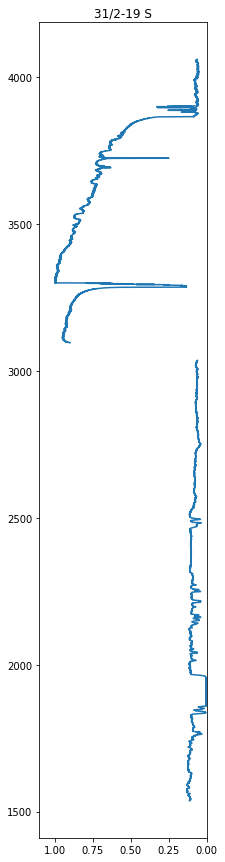

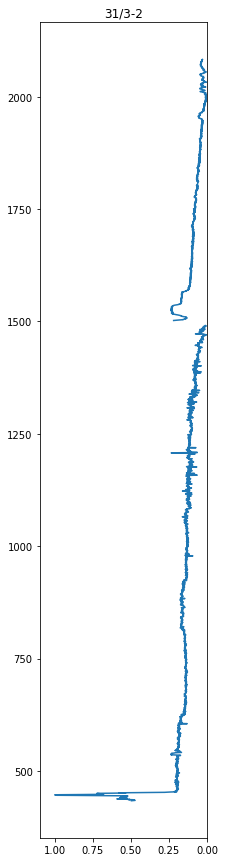

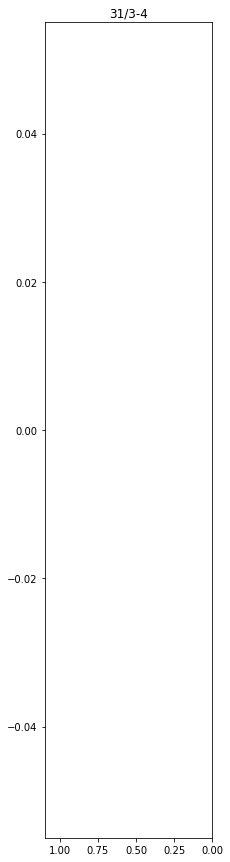

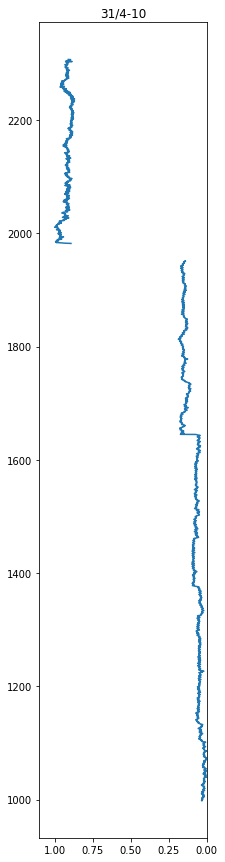

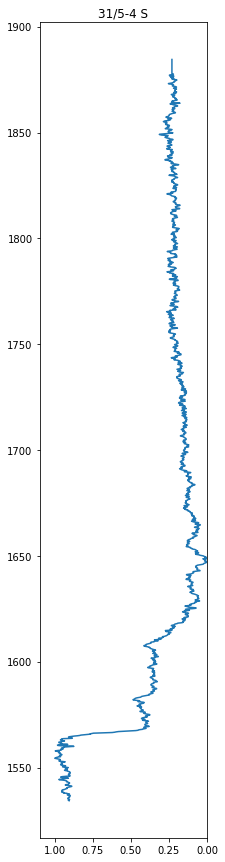

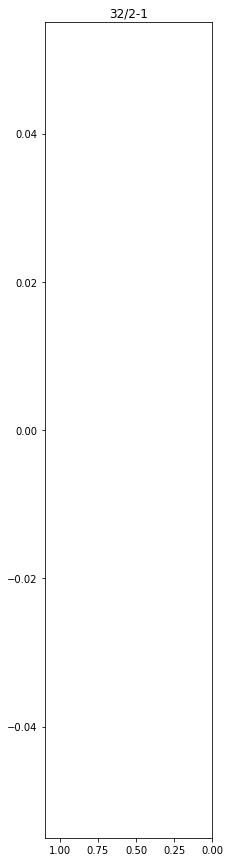

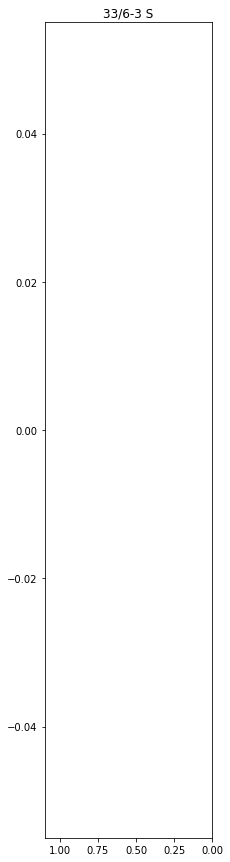

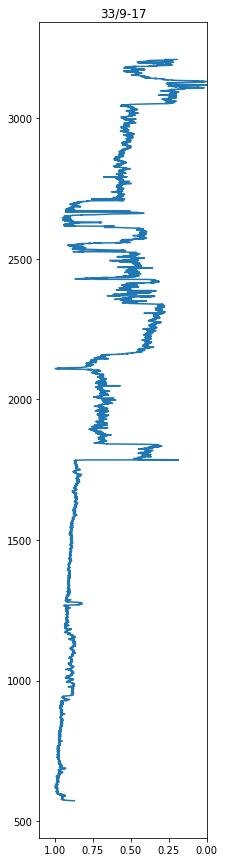

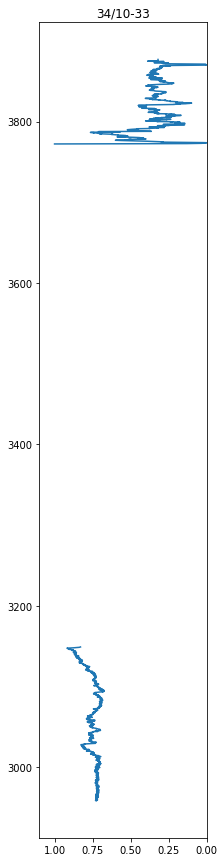

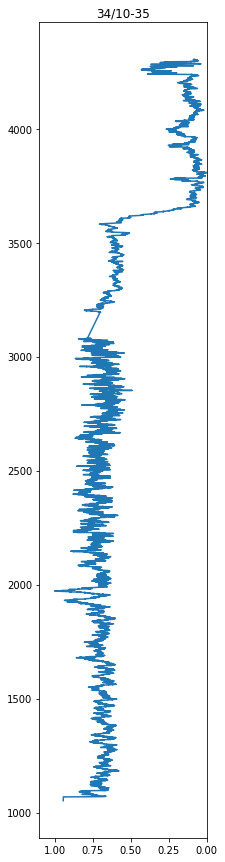

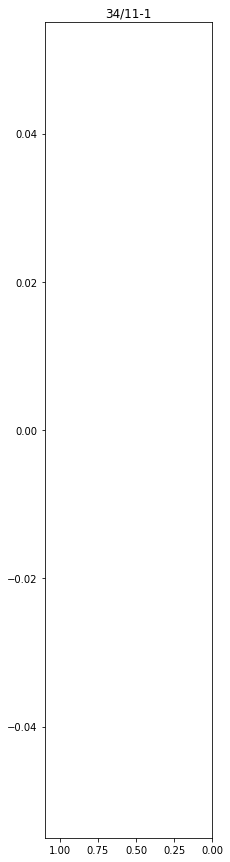

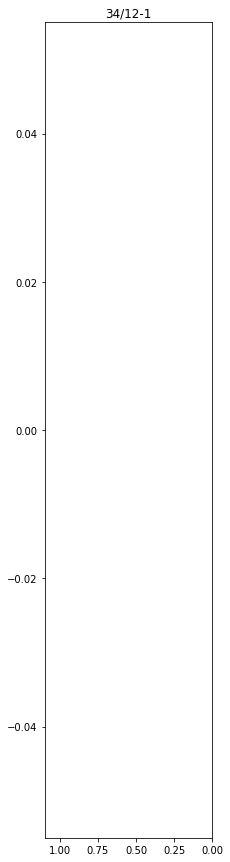

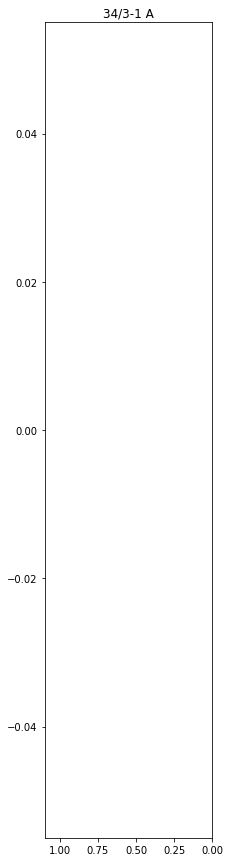

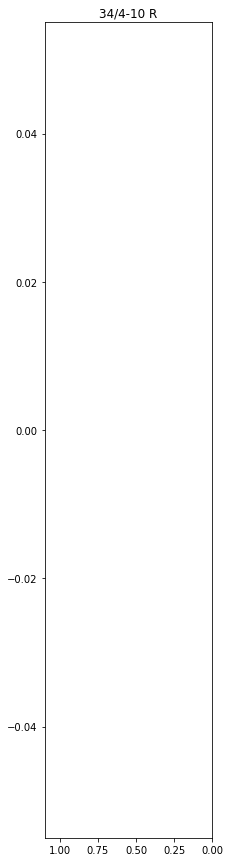

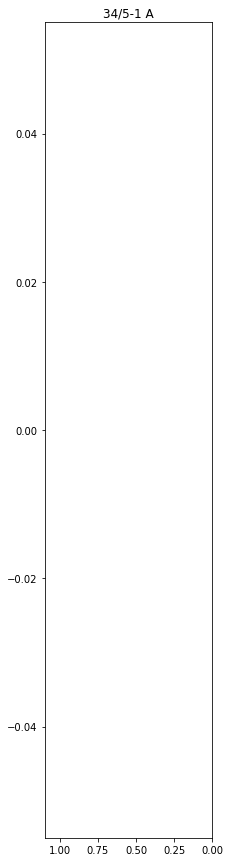

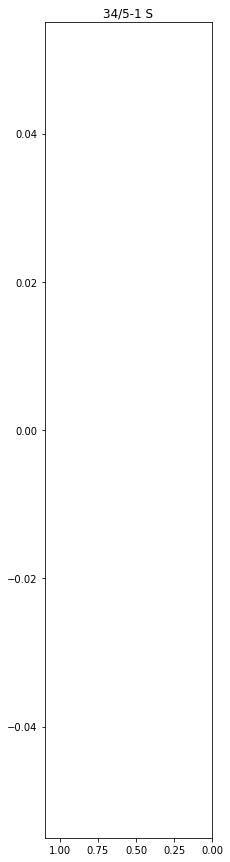

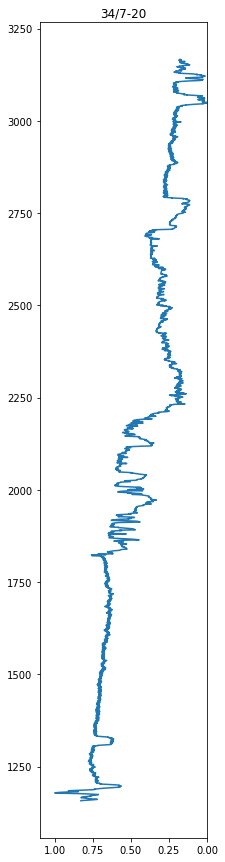

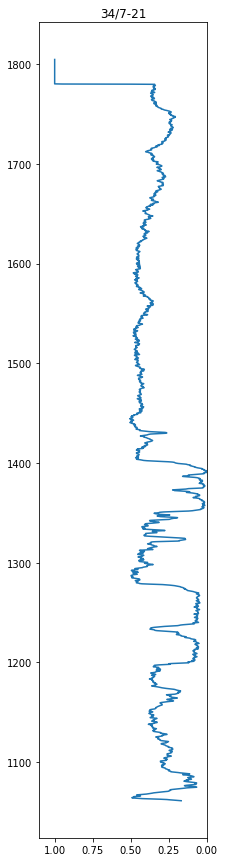

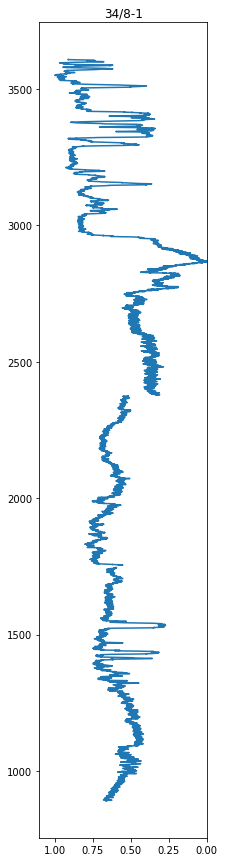

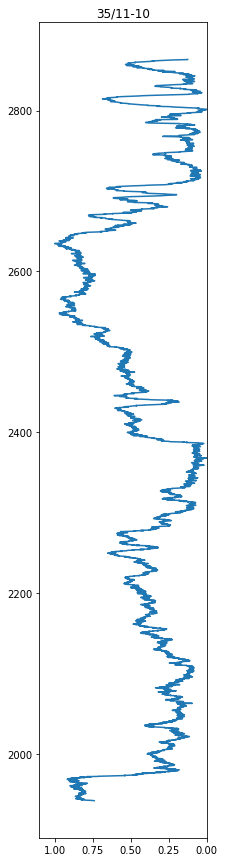

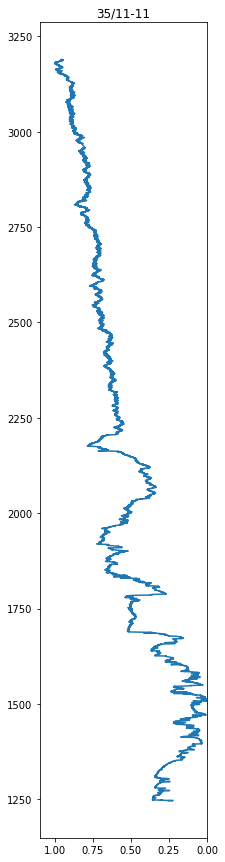

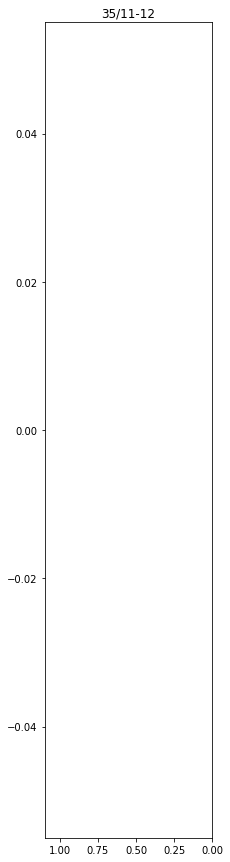

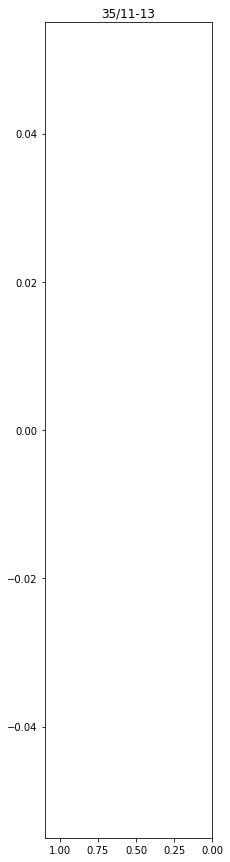

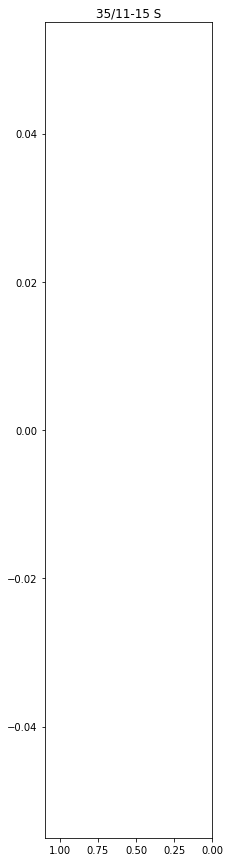

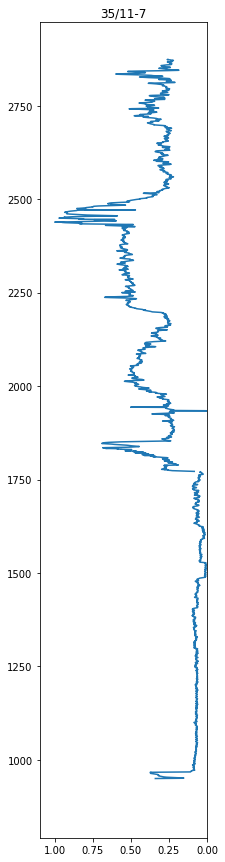

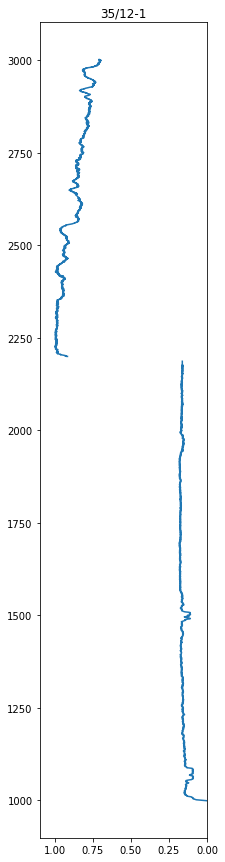

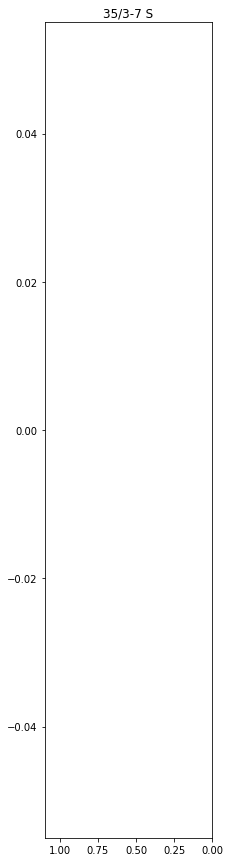

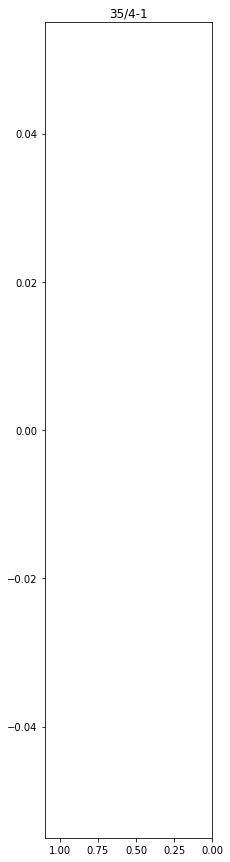

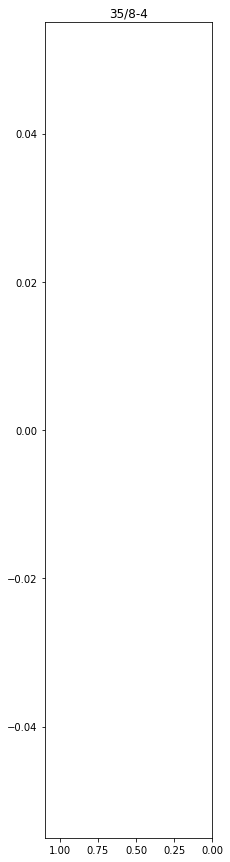

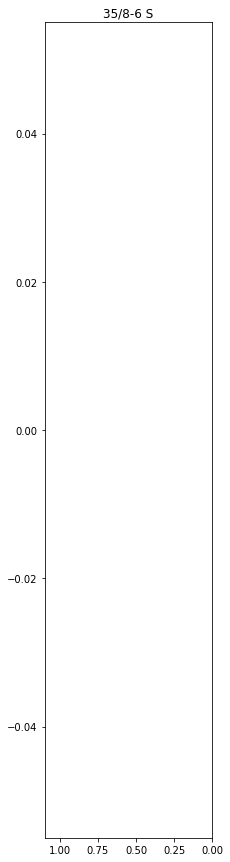

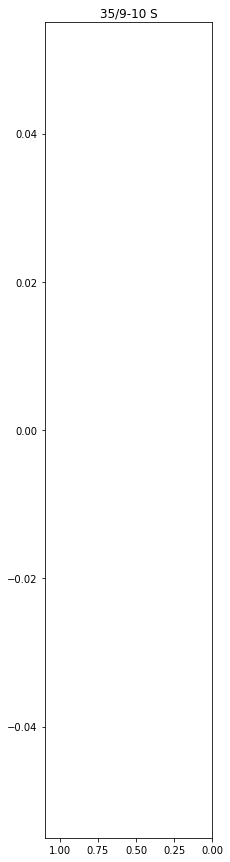

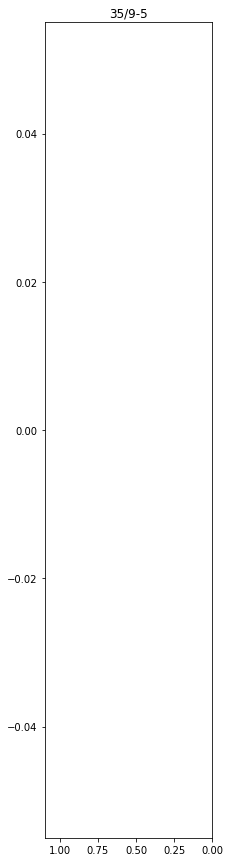

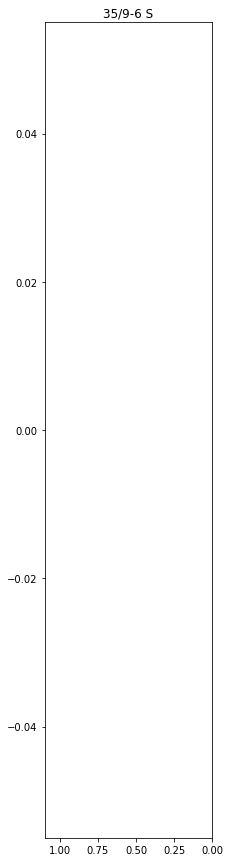

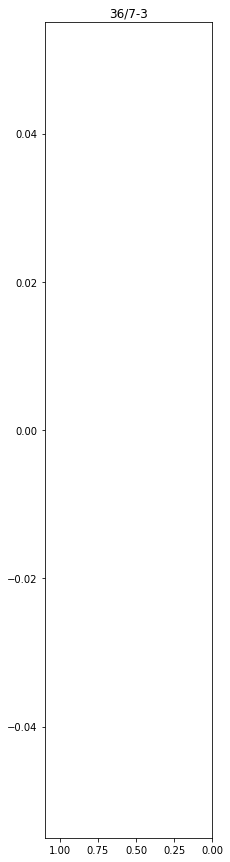

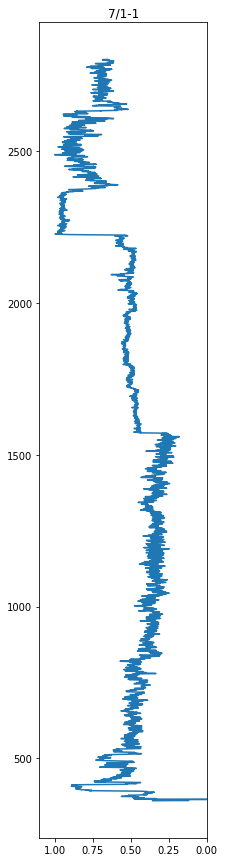

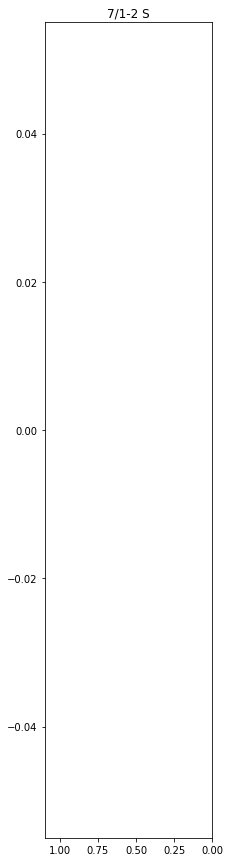

In [26]:
for well in wells:
    plt.figure(figsize=(3, 15))
    plt.plot(wells_sp[well]["sp"], wells_sp[well]["depth"])
    plt.title(well)
    plt.xlim(1.1, 0)
    plt.show()

<AxesSubplot:>

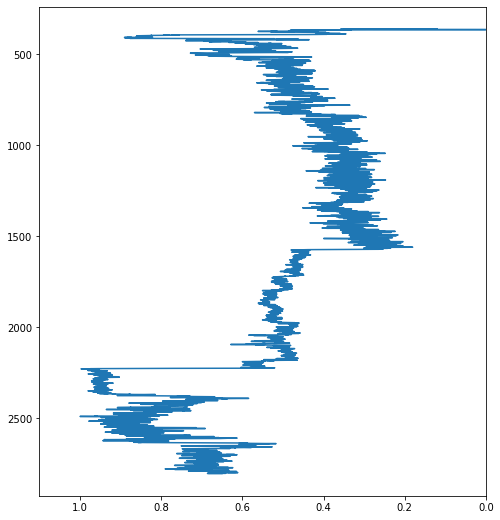

In [33]:
curve = wells_sp["7/1-1"]
plot_well_log(depth=curve["depth"], sp=curve["sp"])

In [34]:
augmentations = [
    Augmentation(
        fun=drop_random_points,
        fun_parameters=[
            AugmentationParameter(
                name="keep_probability",
                generating_function=np.random.uniform,
                generating_parameters={"low": 0.25, "high": 0.8},
            ),
        ]
    ),
    Augmentation(
        fun=remove_random_regions, 
        fun_parameters=[
            AugmentationParameter(
                name="fraction",
                generating_function=np.random.uniform,
                generating_parameters={"low": 0.01, "high": 0.05}
            ),
            AugmentationParameter(
                name="n_regions",
                generating_function=np.random.randint,
                generating_parameters={"low": 3, "high": 25}
            ),
        ]
    ),
    
    Augmentation(
        fun=stretch_function, 
        fun_parameters=[
            AugmentationParameter(
                name="stretching_coef",
                generating_function=np.random.uniform,
                generating_parameters={"low": 1.1, "high": 2}
            ),
        ]
    ),
    
    Augmentation(
        fun=squeeze_function,
        fun_parameters=[
            AugmentationParameter(
                name="coef",
                generating_function=np.random.uniform,
                generating_parameters={"low": .9, "high": 1.05}
            )
        ]
    ),
    
    Augmentation(
        fun=squeeze_random_regions,
        fun_parameters=[
            AugmentationParameter(
                name="fraction",
                generating_function=np.random.uniform,
                generating_parameters={"low": 0.01, "high": 0.1}
            ),
            AugmentationParameter(
                name="n_regions",
                generating_function=np.random.randint,
                generating_parameters={"low": 3, "high": 15},
            ),
            AugmentationParameter(
                name="coef",
                generating_function=np.random.uniform,
                generating_parameters={"low": .9, "high": 1.05}
            )
        ]
    )
]

In [35]:
augmented_curves = generate_augmented_curves(
    pattern=curve["sp"],
    augmentations=augmentations,
    n_curves=10,
    n_augmentations=5,
    length_threshold=1000
)

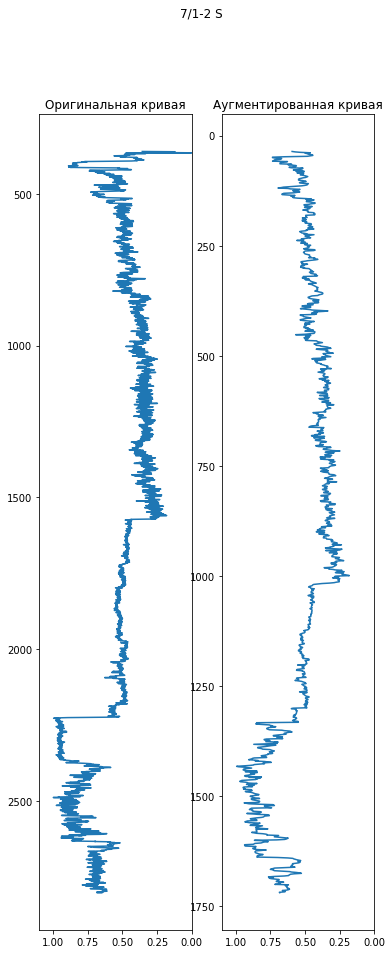

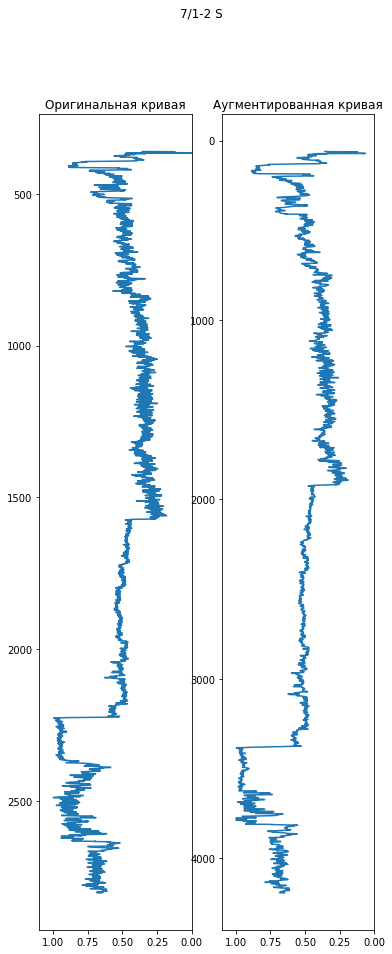

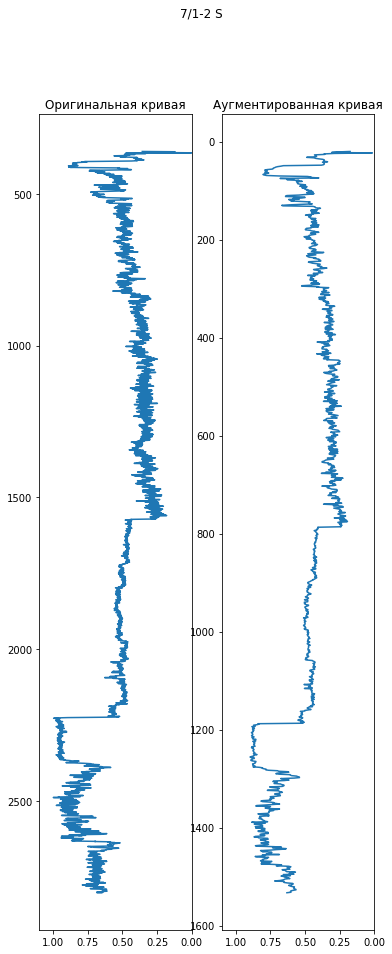

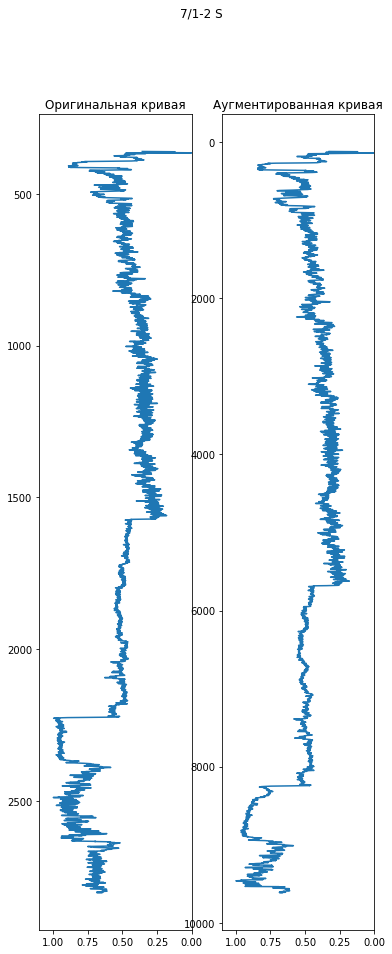

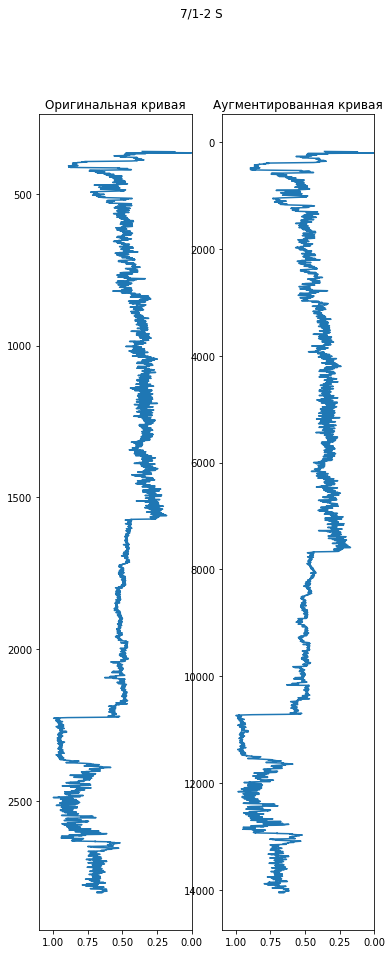

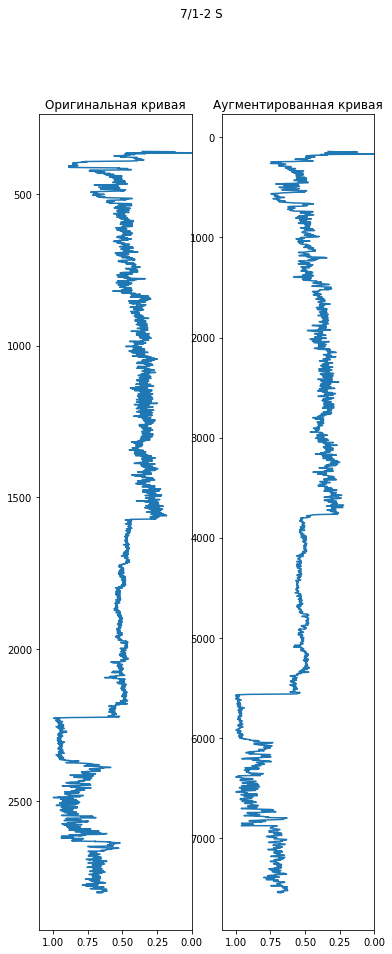

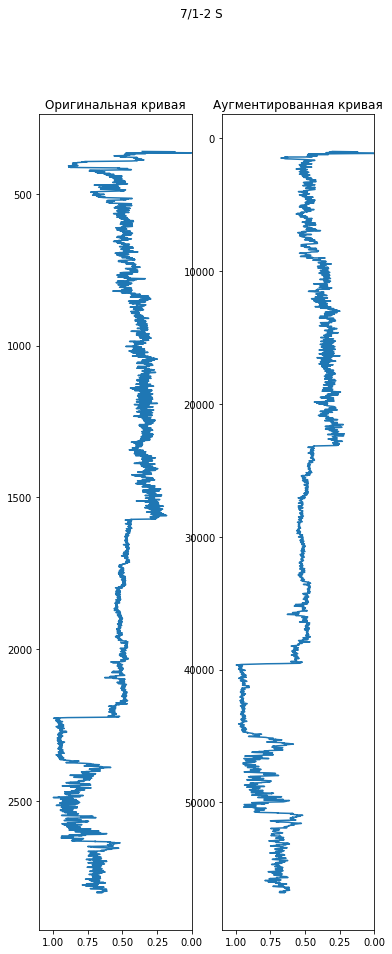

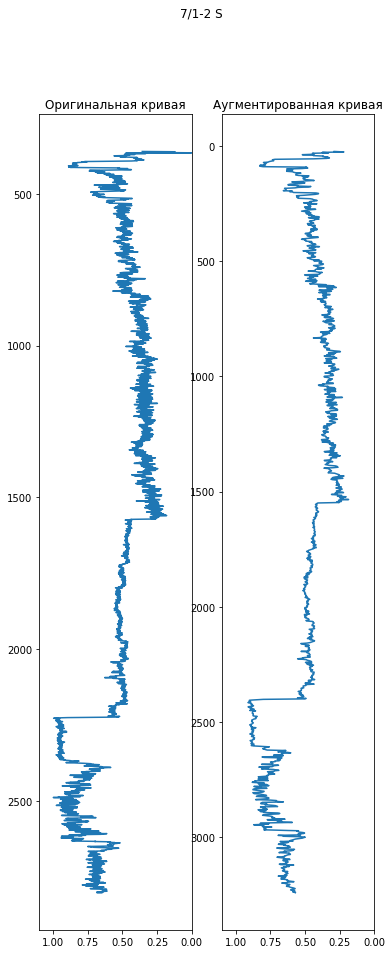

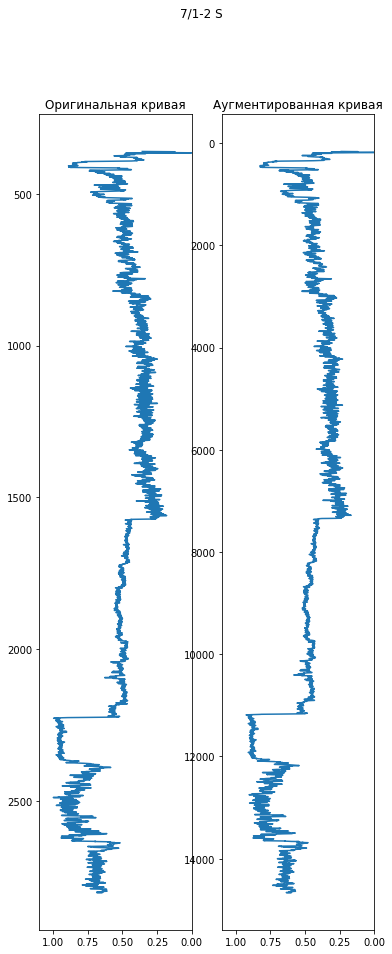

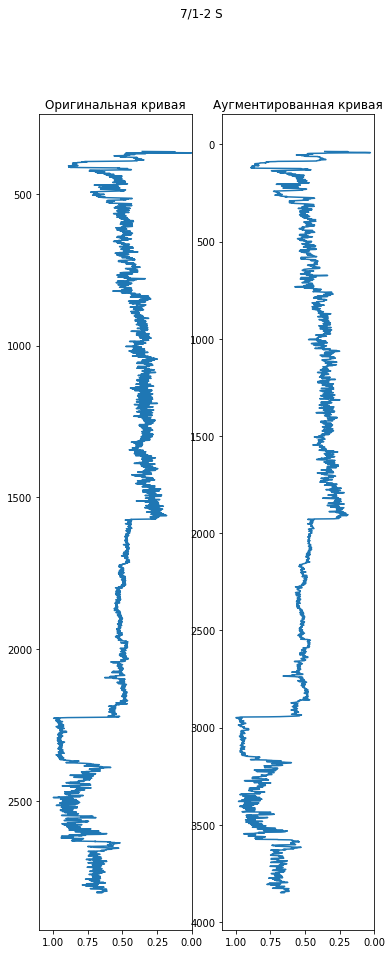

In [38]:
for augmented_curve in augmented_curves:
    fig, axes = plt.subplots(figsize=(6, 15), ncols=2)
    plot_well_log(sp=curve["sp"], depth=curve["depth"], ax=axes[0], title="Оригинальная кривая")
    plot_well_log(sp=augmented_curve, depth=np.arange(len(augmented_curve)), ax=axes[1], title="Аугментированная кривая")
    
    fig.suptitle(well)